In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import wandb

import sys
sys.path.append('../../src/benchmark/')
sys.path.append('../../src/utils/')
from build_model import resnet50_
from utils import split_train_valid, list_to_dict, viz_dataloader, hdf5_dataset
from trainer import Trainer, accuracy

symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)
bs = 3800

# # atom
atom_ds = hdf5_dataset('../../datasets/atom_v5_rot_200k.h5', folder='test', transform=transforms.ToTensor())
atom_dl = DataLoader(atom_ds, batch_size=bs, shuffle=False, num_workers=4)
viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

# # noise
noise_ds = hdf5_dataset('../../datasets/imagenet_atom_noise_v4_rot_10m_100k_subset.h5', folder='noise', transform=transforms.ToTensor())
noise_dl = DataLoader(noise_ds, batch_size=bs, shuffle=False, num_workers=4)
viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

### 1K training dataset size 

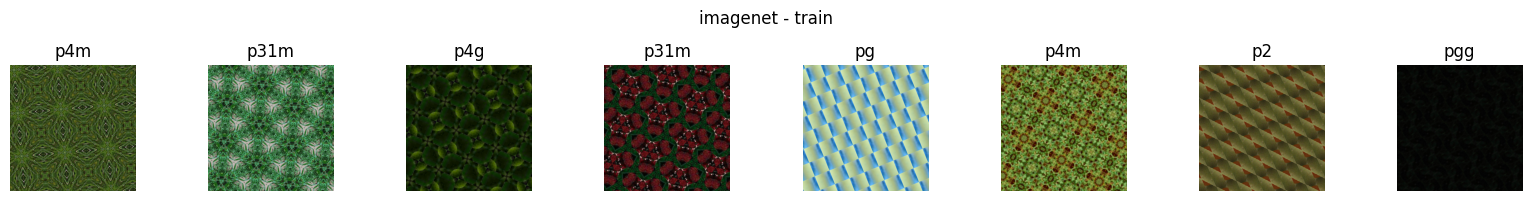

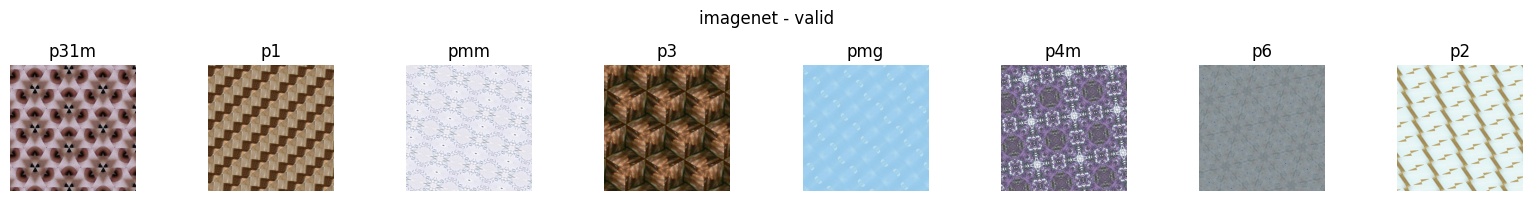

In [ ]:
# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
_, imagenet_ds = split_train_valid(imagenet_ds, 0.9999, seed=42)
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8, seed=42)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
# model.load_state_dict(torch.load('../../saved_models/08282024-resnet50-dataset_v5_size-1k/model_epoch_1500.pth'))
print(outputs.shape)
model = torch.nn.DataParallel(model, device_ids=[3,4,5,6,7,9])
device = torch.device('cuda:3')
# model

torch.Size([2, 17])


In [ ]:
config = {'dataset': '1k datasets',
          'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
          'optimizer': 'Adam',
          'scheduler': 'OneCycleLR'}
NAME = '08282024-resnet50-dataset_v5_size-1k'
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, group='dataset_v5_size_vs_records', save_code=True, config=config, resume='allow')
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yig319. Use `wandb login --relogin` to force relogin


In [ ]:
lr = 1e-3
per_epoch = 100
epoch_start = 0
epochs = 5000
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=1000)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 1/5000


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


train_loss: 3.1054, train_accuracy: 5.25%
Epoch 2/5000


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


train_loss: 3.0799, train_accuracy: 7.00%
Epoch 3/5000


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 3.0859, train_accuracy: 4.55%
Epoch 4/5000


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 3.0403, train_accuracy: 7.82%
Epoch 5/5000


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 3.1200, train_accuracy: 6.07%
Epoch 6/5000


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 3.1031, train_accuracy: 6.77%
Epoch 7/5000


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 3.0787, train_accuracy: 6.30%
Epoch 8/5000


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 3.0662, train_accuracy: 7.70%
Epoch 9/5000


100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


train_loss: 3.0809, train_accuracy: 6.53%
Epoch 10/5000


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


train_loss: 3.0340, train_accuracy: 7.70%
Epoch 11/5000


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


train_loss: 3.0440, train_accuracy: 7.58%
Epoch 12/5000


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 2.9906, train_accuracy: 7.35%
Epoch 13/5000


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 3.0550, train_accuracy: 7.70%
Epoch 14/5000


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 3.0535, train_accuracy: 7.23%
Epoch 15/5000


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


train_loss: 3.0466, train_accuracy: 6.42%
Epoch 16/5000


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 3.0003, train_accuracy: 8.40%
Epoch 17/5000


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


KeyboardInterrupt: 

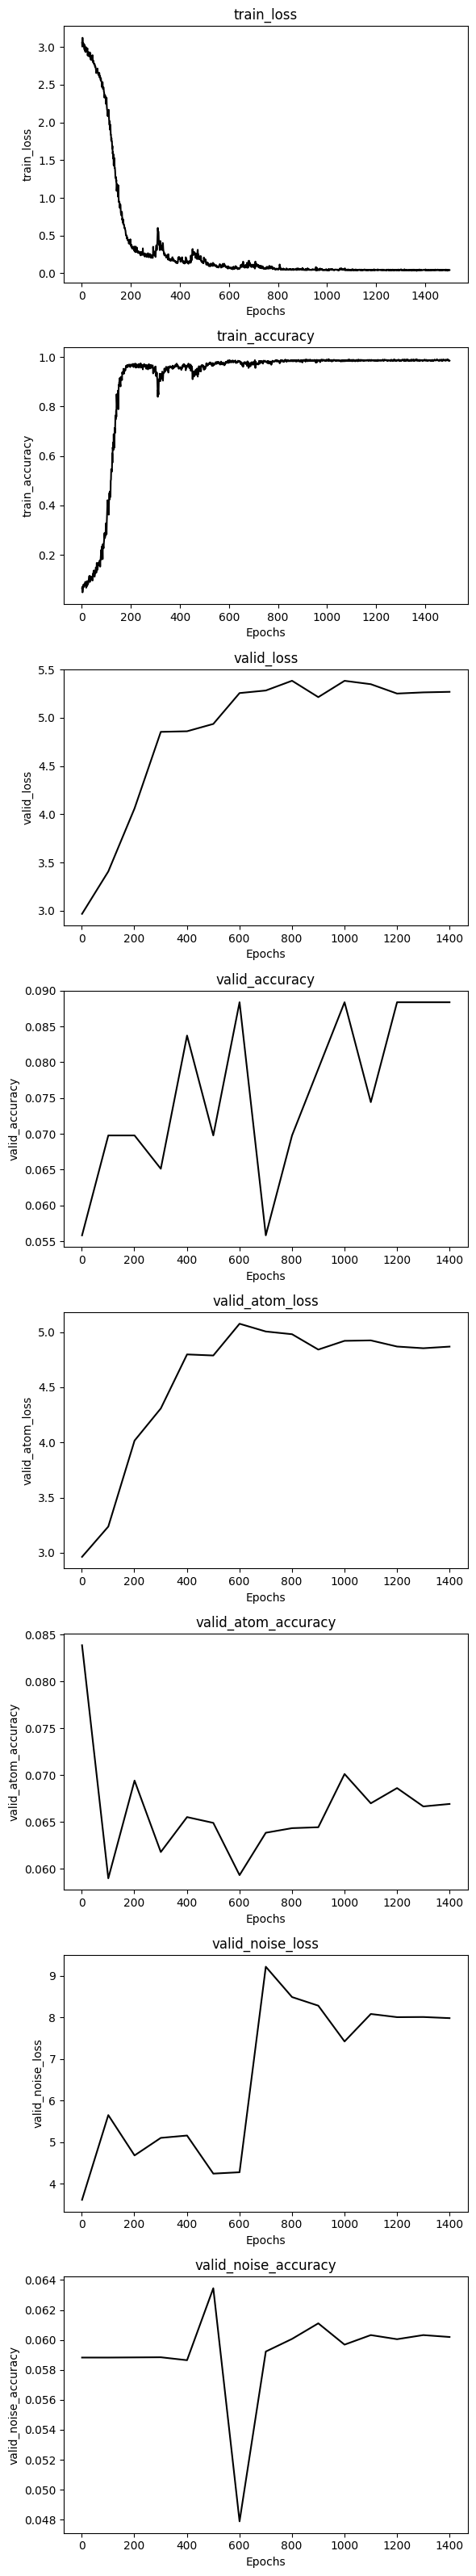

In [ ]:
trainer.plot_training_metrics()

In [ ]:
lr = 1e-3
per_epoch = 100
epoch_start = 1500
epochs = 1500
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=None)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 1501/1500


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


train_loss: 0.0385, train_accuracy: 98.60%
Epoch 1502/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0491, train_accuracy: 98.48%
Epoch 1503/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0416, train_accuracy: 98.60%
Epoch 1504/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0418, train_accuracy: 98.37%
Epoch 1505/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0498, train_accuracy: 98.72%
Epoch 1506/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0479, train_accuracy: 98.48%
Epoch 1507/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0460, train_accuracy: 98.48%
Epoch 1508/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0482, train_accuracy: 98.60%
Epoch 1509/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0471, train_accuracy: 98.72%
Epoch 1510/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0500, train_accuracy: 98.72%
Epoch 1511/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0490, train_accuracy: 98.72%
Epoch 1512/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0441, train_accuracy: 98.83%
Epoch 1513/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0477, train_accuracy: 98.48%
Epoch 1514/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0461, train_accuracy: 98.60%
Epoch 1515/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0466, train_accuracy: 98.60%
Epoch 1516/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0432, train_accuracy: 98.48%
Epoch 1517/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0423, train_accuracy: 98.72%
Epoch 1518/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.0451, train_accuracy: 98.60%
Epoch 1519/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.0400, train_accuracy: 98.72%
Epoch 1520/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0442, train_accuracy: 98.72%
Epoch 1521/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.0431, train_accuracy: 98.60%
Epoch 1522/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0425, train_accuracy: 98.60%
Epoch 1523/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0475, train_accuracy: 98.48%
Epoch 1524/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0433, train_accuracy: 98.60%
Epoch 1525/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0421, train_accuracy: 98.72%
Epoch 1526/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.0472, train_accuracy: 98.60%
Epoch 1527/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0438, train_accuracy: 98.48%
Epoch 1528/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0469, train_accuracy: 98.83%
Epoch 1529/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0465, train_accuracy: 98.48%
Epoch 1530/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0506, train_accuracy: 98.48%
Epoch 1531/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0432, train_accuracy: 98.60%
Epoch 1532/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0380, train_accuracy: 98.95%
Epoch 1533/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0413, train_accuracy: 98.60%
Epoch 1534/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0437, train_accuracy: 98.60%
Epoch 1535/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.0422, train_accuracy: 98.60%
Epoch 1536/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.0430, train_accuracy: 98.60%
Epoch 1537/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0428, train_accuracy: 98.72%
Epoch 1538/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0381, train_accuracy: 98.83%
Epoch 1539/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0464, train_accuracy: 98.60%
Epoch 1540/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0423, train_accuracy: 98.83%
Epoch 1541/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0443, train_accuracy: 98.48%
Epoch 1542/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0580, train_accuracy: 98.37%
Epoch 1543/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0441, train_accuracy: 98.72%
Epoch 1544/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0421, train_accuracy: 98.60%
Epoch 1545/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0463, train_accuracy: 98.48%
Epoch 1546/1500


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 0.0439, train_accuracy: 98.60%
Epoch 1547/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0427, train_accuracy: 98.48%
Epoch 1548/1500


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


train_loss: 0.0409, train_accuracy: 98.72%
Epoch 1549/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0461, train_accuracy: 98.48%
Epoch 1550/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0415, train_accuracy: 98.60%
Epoch 1551/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.0425, train_accuracy: 98.83%
Epoch 1552/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.0416, train_accuracy: 98.48%
Epoch 1553/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0417, train_accuracy: 98.95%
Epoch 1554/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0461, train_accuracy: 98.37%
Epoch 1555/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0473, train_accuracy: 98.48%
Epoch 1556/1500


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


train_loss: 0.0480, train_accuracy: 98.60%
Epoch 1557/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0427, train_accuracy: 98.83%
Epoch 1558/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0421, train_accuracy: 98.60%
Epoch 1559/1500


100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


train_loss: 0.0431, train_accuracy: 98.48%
Epoch 1560/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0476, train_accuracy: 98.48%
Epoch 1561/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0418, train_accuracy: 98.83%
Epoch 1562/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0436, train_accuracy: 98.72%
Epoch 1563/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0400, train_accuracy: 98.72%
Epoch 1564/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0439, train_accuracy: 98.60%
Epoch 1565/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0402, train_accuracy: 98.60%
Epoch 1566/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0455, train_accuracy: 98.48%
Epoch 1567/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0477, train_accuracy: 98.60%
Epoch 1568/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0392, train_accuracy: 98.60%
Epoch 1569/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0441, train_accuracy: 98.83%
Epoch 1570/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0429, train_accuracy: 98.72%
Epoch 1571/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0408, train_accuracy: 98.60%
Epoch 1572/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0462, train_accuracy: 98.60%
Epoch 1573/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0393, train_accuracy: 98.83%
Epoch 1574/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0492, train_accuracy: 98.83%
Epoch 1575/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0400, train_accuracy: 98.95%
Epoch 1576/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0468, train_accuracy: 98.48%
Epoch 1577/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0399, train_accuracy: 98.72%
Epoch 1578/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0507, train_accuracy: 98.37%
Epoch 1579/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0455, train_accuracy: 98.48%
Epoch 1580/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0417, train_accuracy: 98.72%
Epoch 1581/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0445, train_accuracy: 98.60%
Epoch 1582/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0490, train_accuracy: 98.25%
Epoch 1583/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0520, train_accuracy: 98.37%
Epoch 1584/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0515, train_accuracy: 98.25%
Epoch 1585/1500


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


train_loss: 0.0609, train_accuracy: 98.48%
Epoch 1586/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0522, train_accuracy: 98.37%
Epoch 1587/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0451, train_accuracy: 98.60%
Epoch 1588/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0404, train_accuracy: 98.48%
Epoch 1589/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0508, train_accuracy: 98.48%
Epoch 1590/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0431, train_accuracy: 98.72%
Epoch 1591/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0496, train_accuracy: 98.37%
Epoch 1592/1500


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


train_loss: 0.0475, train_accuracy: 98.37%
Epoch 1593/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0466, train_accuracy: 98.60%
Epoch 1594/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0453, train_accuracy: 98.72%
Epoch 1595/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0716, train_accuracy: 98.37%
Epoch 1596/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0481, train_accuracy: 98.48%
Epoch 1597/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0490, train_accuracy: 98.60%
Epoch 1598/1500


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


train_loss: 0.0489, train_accuracy: 98.48%
Epoch 1599/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0505, train_accuracy: 98.25%
Epoch 1600/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0518, train_accuracy: 98.13%


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


valid_loss: 5.5668, valid_accuracy: 6.51%


100%|██████████| 170/170 [01:44<00:00,  1.62it/s]


valid_atom_loss: 5.4276, valid_atom_accuracy: 6.45%


100%|██████████| 85/85 [00:51<00:00,  1.65it/s]


valid_noise_loss: 9.2360, valid_noise_accuracy: 6.09%
Model saved at epoch 1600
Epoch 1601/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0586, train_accuracy: 98.13%
Epoch 1602/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0503, train_accuracy: 98.48%
Epoch 1603/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0566, train_accuracy: 98.25%
Epoch 1604/1500


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


train_loss: 0.0461, train_accuracy: 98.72%
Epoch 1605/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0545, train_accuracy: 98.25%
Epoch 1606/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0504, train_accuracy: 98.60%
Epoch 1607/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0552, train_accuracy: 98.25%
Epoch 1608/1500


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 0.0449, train_accuracy: 98.72%
Epoch 1609/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0803, train_accuracy: 97.67%
Epoch 1610/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0617, train_accuracy: 97.90%
Epoch 1611/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0456, train_accuracy: 98.37%
Epoch 1612/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0583, train_accuracy: 98.13%
Epoch 1613/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.0772, train_accuracy: 97.90%
Epoch 1614/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0551, train_accuracy: 98.13%
Epoch 1615/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0663, train_accuracy: 98.13%
Epoch 1616/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0646, train_accuracy: 97.78%
Epoch 1617/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0547, train_accuracy: 98.25%
Epoch 1618/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0917, train_accuracy: 97.90%
Epoch 1619/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0728, train_accuracy: 97.67%
Epoch 1620/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0675, train_accuracy: 98.02%
Epoch 1621/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0483, train_accuracy: 98.60%
Epoch 1622/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0591, train_accuracy: 98.37%
Epoch 1623/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0687, train_accuracy: 97.78%
Epoch 1624/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0636, train_accuracy: 98.13%
Epoch 1625/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0695, train_accuracy: 97.67%
Epoch 1626/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0849, train_accuracy: 97.08%
Epoch 1627/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0731, train_accuracy: 98.02%
Epoch 1628/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0896, train_accuracy: 97.32%
Epoch 1629/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0707, train_accuracy: 97.32%
Epoch 1630/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0889, train_accuracy: 97.67%
Epoch 1631/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0963, train_accuracy: 97.08%
Epoch 1632/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1078, train_accuracy: 97.43%
Epoch 1633/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0884, train_accuracy: 97.43%
Epoch 1634/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0852, train_accuracy: 97.67%
Epoch 1635/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0950, train_accuracy: 97.67%
Epoch 1636/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0792, train_accuracy: 97.55%
Epoch 1637/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0812, train_accuracy: 98.13%
Epoch 1638/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0718, train_accuracy: 97.78%
Epoch 1639/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0907, train_accuracy: 97.78%
Epoch 1640/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0736, train_accuracy: 97.78%
Epoch 1641/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0985, train_accuracy: 97.78%
Epoch 1642/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0857, train_accuracy: 97.08%
Epoch 1643/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0799, train_accuracy: 97.78%
Epoch 1644/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0819, train_accuracy: 97.90%
Epoch 1645/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0769, train_accuracy: 97.78%
Epoch 1646/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0776, train_accuracy: 98.13%
Epoch 1647/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0811, train_accuracy: 97.78%
Epoch 1648/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0954, train_accuracy: 97.55%
Epoch 1649/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0833, train_accuracy: 97.90%
Epoch 1650/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.1090, train_accuracy: 96.97%
Epoch 1651/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0760, train_accuracy: 97.78%
Epoch 1652/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0831, train_accuracy: 97.32%
Epoch 1653/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0889, train_accuracy: 97.43%
Epoch 1654/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0888, train_accuracy: 97.55%
Epoch 1655/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0832, train_accuracy: 98.25%
Epoch 1656/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0808, train_accuracy: 97.90%
Epoch 1657/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1004, train_accuracy: 97.78%
Epoch 1658/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0934, train_accuracy: 96.97%
Epoch 1659/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.1064, train_accuracy: 97.32%
Epoch 1660/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0977, train_accuracy: 97.43%
Epoch 1661/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1044, train_accuracy: 97.20%
Epoch 1662/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0909, train_accuracy: 97.43%
Epoch 1663/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0917, train_accuracy: 97.20%
Epoch 1664/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0855, train_accuracy: 97.32%
Epoch 1665/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0739, train_accuracy: 97.67%
Epoch 1666/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.1065, train_accuracy: 97.20%
Epoch 1667/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1024, train_accuracy: 97.55%
Epoch 1668/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1129, train_accuracy: 96.62%
Epoch 1669/1500


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


train_loss: 0.1194, train_accuracy: 97.08%
Epoch 1670/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1234, train_accuracy: 96.50%
Epoch 1671/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1070, train_accuracy: 97.43%
Epoch 1672/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1848, train_accuracy: 95.45%
Epoch 1673/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0995, train_accuracy: 96.85%
Epoch 1674/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0958, train_accuracy: 97.55%
Epoch 1675/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1284, train_accuracy: 96.85%
Epoch 1676/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.1225, train_accuracy: 96.15%
Epoch 1677/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1149, train_accuracy: 96.62%
Epoch 1678/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.1137, train_accuracy: 96.73%
Epoch 1679/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0935, train_accuracy: 97.32%
Epoch 1680/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0982, train_accuracy: 97.43%
Epoch 1681/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1561, train_accuracy: 96.27%
Epoch 1682/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1700, train_accuracy: 95.57%
Epoch 1683/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1709, train_accuracy: 95.80%
Epoch 1684/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1158, train_accuracy: 96.50%
Epoch 1685/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1069, train_accuracy: 96.73%
Epoch 1686/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1035, train_accuracy: 96.62%
Epoch 1687/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1097, train_accuracy: 96.03%
Epoch 1688/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1120, train_accuracy: 97.08%
Epoch 1689/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1196, train_accuracy: 97.08%
Epoch 1690/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1957, train_accuracy: 94.40%
Epoch 1691/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0750, train_accuracy: 97.90%
Epoch 1692/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0901, train_accuracy: 97.32%
Epoch 1693/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0941, train_accuracy: 97.67%
Epoch 1694/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1046, train_accuracy: 96.85%
Epoch 1695/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0849, train_accuracy: 97.55%
Epoch 1696/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1220, train_accuracy: 96.73%
Epoch 1697/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1211, train_accuracy: 96.62%
Epoch 1698/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0961, train_accuracy: 96.73%
Epoch 1699/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1029, train_accuracy: 96.97%
Epoch 1700/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0899, train_accuracy: 97.55%


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


valid_loss: 6.2863, valid_accuracy: 6.98%


100%|██████████| 170/170 [01:52<00:00,  1.51it/s]


valid_atom_loss: 6.1864, valid_atom_accuracy: 6.77%


100%|██████████| 85/85 [00:58<00:00,  1.44it/s]


valid_noise_loss: 6.6299, valid_noise_accuracy: 6.24%
Model saved at epoch 1700
Epoch 1701/1500


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


train_loss: 0.0805, train_accuracy: 97.78%
Epoch 1702/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1057, train_accuracy: 96.97%
Epoch 1703/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.1289, train_accuracy: 96.27%
Epoch 1704/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.1045, train_accuracy: 97.32%
Epoch 1705/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0999, train_accuracy: 97.20%
Epoch 1706/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1334, train_accuracy: 96.03%
Epoch 1707/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1084, train_accuracy: 97.32%
Epoch 1708/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0854, train_accuracy: 97.78%
Epoch 1709/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0987, train_accuracy: 96.85%
Epoch 1710/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.1334, train_accuracy: 96.27%
Epoch 1711/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0975, train_accuracy: 97.67%
Epoch 1712/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.1418, train_accuracy: 96.15%
Epoch 1713/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1015, train_accuracy: 97.67%
Epoch 1714/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1278, train_accuracy: 96.50%
Epoch 1715/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1284, train_accuracy: 96.73%
Epoch 1716/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.0853, train_accuracy: 97.67%
Epoch 1717/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0782, train_accuracy: 97.78%
Epoch 1718/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1058, train_accuracy: 97.32%
Epoch 1719/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1002, train_accuracy: 97.08%
Epoch 1720/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1413, train_accuracy: 96.38%
Epoch 1721/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1189, train_accuracy: 97.08%
Epoch 1722/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1424, train_accuracy: 96.03%
Epoch 1723/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0965, train_accuracy: 97.20%
Epoch 1724/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1425, train_accuracy: 95.92%
Epoch 1725/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1441, train_accuracy: 95.80%
Epoch 1726/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1647, train_accuracy: 95.80%
Epoch 1727/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1539, train_accuracy: 95.22%
Epoch 1728/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1181, train_accuracy: 96.85%
Epoch 1729/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1992, train_accuracy: 95.45%
Epoch 1730/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1049, train_accuracy: 97.32%
Epoch 1731/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.1024, train_accuracy: 97.67%
Epoch 1732/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0875, train_accuracy: 97.20%
Epoch 1733/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1236, train_accuracy: 96.38%
Epoch 1734/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0870, train_accuracy: 97.55%
Epoch 1735/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1004, train_accuracy: 96.85%
Epoch 1736/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.1355, train_accuracy: 95.92%
Epoch 1737/1500


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


train_loss: 0.1369, train_accuracy: 96.62%
Epoch 1738/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1360, train_accuracy: 96.27%
Epoch 1739/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1192, train_accuracy: 96.27%
Epoch 1740/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1463, train_accuracy: 95.92%
Epoch 1741/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0849, train_accuracy: 98.02%
Epoch 1742/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0961, train_accuracy: 96.85%
Epoch 1743/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1132, train_accuracy: 96.97%
Epoch 1744/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1379, train_accuracy: 96.50%
Epoch 1745/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1142, train_accuracy: 96.97%
Epoch 1746/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1059, train_accuracy: 97.08%
Epoch 1747/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1207, train_accuracy: 96.73%
Epoch 1748/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.1067, train_accuracy: 96.97%
Epoch 1749/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1446, train_accuracy: 95.80%
Epoch 1750/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1102, train_accuracy: 96.38%
Epoch 1751/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1033, train_accuracy: 96.73%
Epoch 1752/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.1155, train_accuracy: 96.73%
Epoch 1753/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1665, train_accuracy: 94.98%
Epoch 1754/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1327, train_accuracy: 96.27%
Epoch 1755/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1427, train_accuracy: 95.45%
Epoch 1756/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0919, train_accuracy: 97.32%
Epoch 1757/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.1323, train_accuracy: 95.68%
Epoch 1758/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1085, train_accuracy: 97.43%
Epoch 1759/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1035, train_accuracy: 97.32%
Epoch 1760/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1150, train_accuracy: 96.15%
Epoch 1761/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0891, train_accuracy: 97.55%
Epoch 1762/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1383, train_accuracy: 96.27%
Epoch 1763/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0929, train_accuracy: 97.08%
Epoch 1764/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0771, train_accuracy: 97.67%
Epoch 1765/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1300, train_accuracy: 96.27%
Epoch 1766/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1004, train_accuracy: 97.20%
Epoch 1767/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1115, train_accuracy: 96.97%
Epoch 1768/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0851, train_accuracy: 97.90%
Epoch 1769/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0889, train_accuracy: 97.32%
Epoch 1770/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0981, train_accuracy: 97.43%
Epoch 1771/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1023, train_accuracy: 96.97%
Epoch 1772/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1061, train_accuracy: 96.97%
Epoch 1773/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.1090, train_accuracy: 96.73%
Epoch 1774/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1067, train_accuracy: 97.43%
Epoch 1775/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.1680, train_accuracy: 95.57%
Epoch 1776/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1297, train_accuracy: 96.85%
Epoch 1777/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.1561, train_accuracy: 95.68%
Epoch 1778/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1446, train_accuracy: 96.38%
Epoch 1779/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0830, train_accuracy: 97.78%
Epoch 1780/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1194, train_accuracy: 96.62%
Epoch 1781/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0880, train_accuracy: 97.55%
Epoch 1782/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.1261, train_accuracy: 96.50%
Epoch 1783/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0956, train_accuracy: 97.20%
Epoch 1784/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.1229, train_accuracy: 96.73%
Epoch 1785/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0863, train_accuracy: 97.32%
Epoch 1786/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0984, train_accuracy: 97.20%
Epoch 1787/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.1235, train_accuracy: 96.62%
Epoch 1788/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.1428, train_accuracy: 96.62%
Epoch 1789/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.1351, train_accuracy: 96.62%
Epoch 1790/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.1147, train_accuracy: 97.08%
Epoch 1791/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.1317, train_accuracy: 97.20%
Epoch 1792/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.1162, train_accuracy: 96.62%
Epoch 1793/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1118, train_accuracy: 96.50%
Epoch 1794/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1572, train_accuracy: 96.27%
Epoch 1795/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.1370, train_accuracy: 96.38%
Epoch 1796/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.1377, train_accuracy: 96.62%
Epoch 1797/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1628, train_accuracy: 95.45%
Epoch 1798/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.1476, train_accuracy: 95.68%
Epoch 1799/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.1867, train_accuracy: 93.82%
Epoch 1800/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.1458, train_accuracy: 95.22%


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


valid_loss: 6.4991, valid_accuracy: 8.37%


100%|██████████| 170/170 [01:39<00:00,  1.70it/s]


valid_atom_loss: 6.3627, valid_atom_accuracy: 5.91%


100%|██████████| 85/85 [00:49<00:00,  1.73it/s]


valid_noise_loss: 7.0002, valid_noise_accuracy: 4.10%
Model saved at epoch 1800
Epoch 1801/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1283, train_accuracy: 96.38%
Epoch 1802/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.1273, train_accuracy: 96.38%
Epoch 1803/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1798, train_accuracy: 94.87%
Epoch 1804/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1443, train_accuracy: 95.92%
Epoch 1805/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.1437, train_accuracy: 95.92%
Epoch 1806/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1306, train_accuracy: 96.62%
Epoch 1807/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1349, train_accuracy: 96.03%
Epoch 1808/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1047, train_accuracy: 96.73%
Epoch 1809/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.1617, train_accuracy: 95.68%
Epoch 1810/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.1150, train_accuracy: 97.20%
Epoch 1811/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1232, train_accuracy: 96.50%
Epoch 1812/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.1082, train_accuracy: 96.38%
Epoch 1813/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1054, train_accuracy: 96.85%
Epoch 1814/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0953, train_accuracy: 97.43%
Epoch 1815/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.1011, train_accuracy: 96.73%
Epoch 1816/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0884, train_accuracy: 97.67%
Epoch 1817/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.1154, train_accuracy: 97.08%
Epoch 1818/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1020, train_accuracy: 97.20%
Epoch 1819/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0888, train_accuracy: 97.08%
Epoch 1820/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0913, train_accuracy: 97.67%
Epoch 1821/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0937, train_accuracy: 97.08%
Epoch 1822/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0744, train_accuracy: 98.02%
Epoch 1823/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0871, train_accuracy: 97.67%
Epoch 1824/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.1072, train_accuracy: 96.85%
Epoch 1825/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1126, train_accuracy: 97.67%
Epoch 1826/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0913, train_accuracy: 97.67%
Epoch 1827/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0666, train_accuracy: 98.25%
Epoch 1828/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0778, train_accuracy: 97.32%
Epoch 1829/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0898, train_accuracy: 97.67%
Epoch 1830/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0767, train_accuracy: 97.55%
Epoch 1831/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.1021, train_accuracy: 96.97%
Epoch 1832/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0828, train_accuracy: 98.02%
Epoch 1833/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0843, train_accuracy: 97.43%
Epoch 1834/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0821, train_accuracy: 97.55%
Epoch 1835/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1041, train_accuracy: 97.20%
Epoch 1836/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0942, train_accuracy: 97.43%
Epoch 1837/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0886, train_accuracy: 97.20%
Epoch 1838/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0835, train_accuracy: 97.67%
Epoch 1839/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0855, train_accuracy: 97.67%
Epoch 1840/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0831, train_accuracy: 97.67%
Epoch 1841/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0948, train_accuracy: 97.78%
Epoch 1842/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.1064, train_accuracy: 97.08%
Epoch 1843/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0889, train_accuracy: 97.43%
Epoch 1844/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0903, train_accuracy: 97.43%
Epoch 1845/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1094, train_accuracy: 96.62%
Epoch 1846/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0896, train_accuracy: 97.32%
Epoch 1847/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0734, train_accuracy: 97.55%
Epoch 1848/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0886, train_accuracy: 97.32%
Epoch 1849/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0839, train_accuracy: 97.55%
Epoch 1850/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0773, train_accuracy: 97.67%
Epoch 1851/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0778, train_accuracy: 97.90%
Epoch 1852/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1036, train_accuracy: 97.32%
Epoch 1853/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0804, train_accuracy: 97.90%
Epoch 1854/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0732, train_accuracy: 97.90%
Epoch 1855/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0750, train_accuracy: 97.20%
Epoch 1856/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0846, train_accuracy: 97.78%
Epoch 1857/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1624, train_accuracy: 95.80%
Epoch 1858/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0941, train_accuracy: 97.32%
Epoch 1859/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0969, train_accuracy: 98.02%
Epoch 1860/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1299, train_accuracy: 95.80%
Epoch 1861/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.1678, train_accuracy: 95.68%
Epoch 1862/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1193, train_accuracy: 96.50%
Epoch 1863/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1179, train_accuracy: 96.62%
Epoch 1864/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1246, train_accuracy: 96.73%
Epoch 1865/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.1500, train_accuracy: 96.03%
Epoch 1866/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1129, train_accuracy: 96.27%
Epoch 1867/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1285, train_accuracy: 95.57%
Epoch 1868/1500


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


train_loss: 0.1473, train_accuracy: 96.03%
Epoch 1869/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.1069, train_accuracy: 96.73%
Epoch 1870/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1338, train_accuracy: 96.15%
Epoch 1871/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.1322, train_accuracy: 95.80%
Epoch 1872/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1354, train_accuracy: 95.80%
Epoch 1873/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0927, train_accuracy: 97.32%
Epoch 1874/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1178, train_accuracy: 96.97%
Epoch 1875/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1385, train_accuracy: 96.03%
Epoch 1876/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0748, train_accuracy: 97.67%
Epoch 1877/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0986, train_accuracy: 96.85%
Epoch 1878/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1220, train_accuracy: 96.27%
Epoch 1879/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.1456, train_accuracy: 96.27%
Epoch 1880/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1414, train_accuracy: 96.50%
Epoch 1881/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1255, train_accuracy: 96.62%
Epoch 1882/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1458, train_accuracy: 96.03%
Epoch 1883/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1191, train_accuracy: 96.73%
Epoch 1884/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1666, train_accuracy: 96.73%
Epoch 1885/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1356, train_accuracy: 95.80%
Epoch 1886/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1577, train_accuracy: 95.10%
Epoch 1887/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1344, train_accuracy: 96.50%
Epoch 1888/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.1183, train_accuracy: 96.38%
Epoch 1889/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1104, train_accuracy: 96.85%
Epoch 1890/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1133, train_accuracy: 96.73%
Epoch 1891/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0834, train_accuracy: 97.55%
Epoch 1892/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1203, train_accuracy: 96.97%
Epoch 1893/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0935, train_accuracy: 96.85%
Epoch 1894/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0978, train_accuracy: 97.55%
Epoch 1895/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0921, train_accuracy: 97.43%
Epoch 1896/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0790, train_accuracy: 97.55%
Epoch 1897/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1311, train_accuracy: 96.50%
Epoch 1898/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1120, train_accuracy: 96.38%
Epoch 1899/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.1233, train_accuracy: 96.38%
Epoch 1900/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0838, train_accuracy: 97.67%


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


valid_loss: 6.8614, valid_accuracy: 7.91%


100%|██████████| 170/170 [01:39<00:00,  1.70it/s]


valid_atom_loss: 7.1061, valid_atom_accuracy: 7.41%


100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


valid_noise_loss: 6.1095, valid_noise_accuracy: 6.04%
Model saved at epoch 1900
Epoch 1901/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.0870, train_accuracy: 97.55%
Epoch 1902/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0854, train_accuracy: 97.78%
Epoch 1903/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0737, train_accuracy: 97.78%
Epoch 1904/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0794, train_accuracy: 97.43%
Epoch 1905/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0701, train_accuracy: 97.90%
Epoch 1906/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0838, train_accuracy: 97.55%
Epoch 1907/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0719, train_accuracy: 98.13%
Epoch 1908/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0745, train_accuracy: 97.78%
Epoch 1909/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.1167, train_accuracy: 96.50%
Epoch 1910/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0789, train_accuracy: 97.55%
Epoch 1911/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0973, train_accuracy: 97.32%
Epoch 1912/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.1180, train_accuracy: 96.97%
Epoch 1913/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.1167, train_accuracy: 97.32%
Epoch 1914/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1535, train_accuracy: 96.38%
Epoch 1915/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.1023, train_accuracy: 96.85%
Epoch 1916/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1177, train_accuracy: 96.97%
Epoch 1917/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1150, train_accuracy: 96.15%
Epoch 1918/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1194, train_accuracy: 96.85%
Epoch 1919/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0902, train_accuracy: 97.32%
Epoch 1920/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.1080, train_accuracy: 96.62%
Epoch 1921/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0887, train_accuracy: 97.55%
Epoch 1922/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.1059, train_accuracy: 96.97%
Epoch 1923/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0756, train_accuracy: 97.90%
Epoch 1924/1500


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 0.0975, train_accuracy: 96.97%
Epoch 1925/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0733, train_accuracy: 97.90%
Epoch 1926/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0832, train_accuracy: 97.78%
Epoch 1927/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0759, train_accuracy: 98.02%
Epoch 1928/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0828, train_accuracy: 97.55%
Epoch 1929/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0845, train_accuracy: 97.90%
Epoch 1930/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0605, train_accuracy: 98.25%
Epoch 1931/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0551, train_accuracy: 98.60%
Epoch 1932/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0700, train_accuracy: 97.78%
Epoch 1933/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0666, train_accuracy: 97.90%
Epoch 1934/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0662, train_accuracy: 97.32%
Epoch 1935/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0912, train_accuracy: 97.78%
Epoch 1936/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0508, train_accuracy: 98.60%
Epoch 1937/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0559, train_accuracy: 98.37%
Epoch 1938/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0708, train_accuracy: 97.67%
Epoch 1939/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0545, train_accuracy: 98.25%
Epoch 1940/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0518, train_accuracy: 98.37%
Epoch 1941/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0588, train_accuracy: 98.37%
Epoch 1942/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0657, train_accuracy: 97.90%
Epoch 1943/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0714, train_accuracy: 98.37%
Epoch 1944/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0826, train_accuracy: 97.43%
Epoch 1945/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0653, train_accuracy: 98.37%
Epoch 1946/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1190, train_accuracy: 96.85%
Epoch 1947/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.1245, train_accuracy: 96.97%
Epoch 1948/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1034, train_accuracy: 97.08%
Epoch 1949/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0824, train_accuracy: 97.78%
Epoch 1950/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1349, train_accuracy: 96.27%
Epoch 1951/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.1055, train_accuracy: 96.97%
Epoch 1952/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.1115, train_accuracy: 97.08%
Epoch 1953/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1230, train_accuracy: 96.27%
Epoch 1954/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0942, train_accuracy: 97.55%
Epoch 1955/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0879, train_accuracy: 97.55%
Epoch 1956/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0758, train_accuracy: 97.78%
Epoch 1957/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1102, train_accuracy: 96.73%
Epoch 1958/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0959, train_accuracy: 97.32%
Epoch 1959/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0879, train_accuracy: 97.90%
Epoch 1960/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0674, train_accuracy: 97.90%
Epoch 1961/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0837, train_accuracy: 97.67%
Epoch 1962/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0639, train_accuracy: 97.78%
Epoch 1963/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0655, train_accuracy: 98.13%
Epoch 1964/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0800, train_accuracy: 97.67%
Epoch 1965/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0786, train_accuracy: 97.67%
Epoch 1966/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0759, train_accuracy: 97.32%
Epoch 1967/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0596, train_accuracy: 98.60%
Epoch 1968/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0679, train_accuracy: 97.90%
Epoch 1969/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0644, train_accuracy: 97.90%
Epoch 1970/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0635, train_accuracy: 98.25%
Epoch 1971/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0635, train_accuracy: 98.25%
Epoch 1972/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0907, train_accuracy: 97.55%
Epoch 1973/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0547, train_accuracy: 98.48%
Epoch 1974/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0691, train_accuracy: 97.67%
Epoch 1975/1500


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


train_loss: 0.0556, train_accuracy: 98.13%
Epoch 1976/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0511, train_accuracy: 98.48%
Epoch 1977/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0544, train_accuracy: 98.37%
Epoch 1978/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0512, train_accuracy: 98.60%
Epoch 1979/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0429, train_accuracy: 98.48%
Epoch 1980/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0709, train_accuracy: 97.67%
Epoch 1981/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0838, train_accuracy: 97.67%
Epoch 1982/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0545, train_accuracy: 98.48%
Epoch 1983/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0685, train_accuracy: 97.90%
Epoch 1984/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0611, train_accuracy: 98.02%
Epoch 1985/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0493, train_accuracy: 98.72%
Epoch 1986/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0530, train_accuracy: 98.48%
Epoch 1987/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0569, train_accuracy: 98.13%
Epoch 1988/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0581, train_accuracy: 98.02%
Epoch 1989/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0695, train_accuracy: 98.02%
Epoch 1990/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0455, train_accuracy: 98.48%
Epoch 1991/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0467, train_accuracy: 98.37%
Epoch 1992/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0562, train_accuracy: 98.48%
Epoch 1993/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0613, train_accuracy: 98.25%
Epoch 1994/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0799, train_accuracy: 97.32%
Epoch 1995/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0562, train_accuracy: 98.13%
Epoch 1996/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1693, train_accuracy: 95.92%
Epoch 1997/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1157, train_accuracy: 96.85%
Epoch 1998/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.1388, train_accuracy: 96.62%
Epoch 1999/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.1997, train_accuracy: 94.75%
Epoch 2000/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.1546, train_accuracy: 95.22%


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


valid_loss: 6.5598, valid_accuracy: 9.30%


100%|██████████| 170/170 [01:39<00:00,  1.71it/s]


valid_atom_loss: 6.8884, valid_atom_accuracy: 8.98%


100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


valid_noise_loss: 6.6289, valid_noise_accuracy: 6.12%
Model saved at epoch 2000
Epoch 2001/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1171, train_accuracy: 96.97%
Epoch 2002/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.1268, train_accuracy: 96.50%
Epoch 2003/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.1239, train_accuracy: 96.62%
Epoch 2004/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0914, train_accuracy: 96.50%
Epoch 2005/1500


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 0.1019, train_accuracy: 96.85%
Epoch 2006/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0727, train_accuracy: 97.32%
Epoch 2007/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0747, train_accuracy: 97.43%
Epoch 2008/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0853, train_accuracy: 97.55%
Epoch 2009/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0889, train_accuracy: 97.55%
Epoch 2010/1500


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


train_loss: 0.0997, train_accuracy: 97.08%
Epoch 2011/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0908, train_accuracy: 97.08%
Epoch 2012/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0944, train_accuracy: 97.20%
Epoch 2013/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0636, train_accuracy: 97.67%
Epoch 2014/1500


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


train_loss: 0.0676, train_accuracy: 98.25%
Epoch 2015/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.1109, train_accuracy: 96.27%
Epoch 2016/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0633, train_accuracy: 98.02%
Epoch 2017/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0704, train_accuracy: 98.13%
Epoch 2018/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0858, train_accuracy: 97.20%
Epoch 2019/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0964, train_accuracy: 97.20%
Epoch 2020/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0990, train_accuracy: 96.73%
Epoch 2021/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0711, train_accuracy: 98.37%
Epoch 2022/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0935, train_accuracy: 96.85%
Epoch 2023/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0633, train_accuracy: 98.13%
Epoch 2024/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0795, train_accuracy: 97.55%
Epoch 2025/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0707, train_accuracy: 97.90%
Epoch 2026/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0537, train_accuracy: 98.02%
Epoch 2027/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0706, train_accuracy: 97.90%
Epoch 2028/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0579, train_accuracy: 98.02%
Epoch 2029/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.1019, train_accuracy: 97.20%
Epoch 2030/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0573, train_accuracy: 98.25%
Epoch 2031/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0551, train_accuracy: 98.37%
Epoch 2032/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0513, train_accuracy: 98.13%
Epoch 2033/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0683, train_accuracy: 98.25%
Epoch 2034/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0665, train_accuracy: 98.13%
Epoch 2035/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0572, train_accuracy: 98.25%
Epoch 2036/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.0615, train_accuracy: 97.67%
Epoch 2037/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0539, train_accuracy: 98.48%
Epoch 2038/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0481, train_accuracy: 98.48%
Epoch 2039/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0719, train_accuracy: 98.02%
Epoch 2040/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0665, train_accuracy: 97.78%
Epoch 2041/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0580, train_accuracy: 98.13%
Epoch 2042/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0441, train_accuracy: 98.95%
Epoch 2043/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0565, train_accuracy: 98.60%
Epoch 2044/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0745, train_accuracy: 97.78%
Epoch 2045/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0758, train_accuracy: 97.90%
Epoch 2046/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0760, train_accuracy: 97.67%
Epoch 2047/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0685, train_accuracy: 98.02%
Epoch 2048/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0614, train_accuracy: 98.37%
Epoch 2049/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0526, train_accuracy: 98.37%
Epoch 2050/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0649, train_accuracy: 98.13%
Epoch 2051/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0542, train_accuracy: 98.37%
Epoch 2052/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0522, train_accuracy: 98.13%
Epoch 2053/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0620, train_accuracy: 97.90%
Epoch 2054/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0548, train_accuracy: 98.48%
Epoch 2055/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0461, train_accuracy: 98.72%
Epoch 2056/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0504, train_accuracy: 98.48%
Epoch 2057/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0521, train_accuracy: 98.48%
Epoch 2058/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0473, train_accuracy: 98.48%
Epoch 2059/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0498, train_accuracy: 98.60%
Epoch 2060/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0496, train_accuracy: 98.60%
Epoch 2061/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0640, train_accuracy: 98.60%
Epoch 2062/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0705, train_accuracy: 98.37%
Epoch 2063/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0563, train_accuracy: 98.48%
Epoch 2064/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0473, train_accuracy: 98.48%
Epoch 2065/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0363, train_accuracy: 98.83%
Epoch 2066/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0474, train_accuracy: 98.48%
Epoch 2067/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0506, train_accuracy: 98.37%
Epoch 2068/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0520, train_accuracy: 98.48%
Epoch 2069/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0541, train_accuracy: 98.37%
Epoch 2070/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0586, train_accuracy: 97.90%
Epoch 2071/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0476, train_accuracy: 98.60%
Epoch 2072/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0682, train_accuracy: 98.37%
Epoch 2073/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0429, train_accuracy: 98.72%
Epoch 2074/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0648, train_accuracy: 98.02%
Epoch 2075/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0450, train_accuracy: 98.48%
Epoch 2076/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0537, train_accuracy: 98.37%
Epoch 2077/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0407, train_accuracy: 98.60%
Epoch 2078/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0510, train_accuracy: 98.37%
Epoch 2079/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0460, train_accuracy: 98.72%
Epoch 2080/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0445, train_accuracy: 98.60%
Epoch 2081/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0482, train_accuracy: 98.60%
Epoch 2082/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0467, train_accuracy: 98.60%
Epoch 2083/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0417, train_accuracy: 98.72%
Epoch 2084/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0417, train_accuracy: 98.48%
Epoch 2085/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0455, train_accuracy: 98.48%
Epoch 2086/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0486, train_accuracy: 98.60%
Epoch 2087/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0405, train_accuracy: 98.83%
Epoch 2088/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0461, train_accuracy: 98.48%
Epoch 2089/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0407, train_accuracy: 98.60%
Epoch 2090/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0377, train_accuracy: 98.72%
Epoch 2091/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0464, train_accuracy: 98.60%
Epoch 2092/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0444, train_accuracy: 98.37%
Epoch 2093/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0420, train_accuracy: 98.83%
Epoch 2094/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0408, train_accuracy: 99.07%
Epoch 2095/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0351, train_accuracy: 98.95%
Epoch 2096/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0358, train_accuracy: 99.18%
Epoch 2097/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0378, train_accuracy: 98.83%
Epoch 2098/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0376, train_accuracy: 99.07%
Epoch 2099/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0343, train_accuracy: 98.83%
Epoch 2100/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0380, train_accuracy: 98.83%


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


valid_loss: 6.7238, valid_accuracy: 7.44%


100%|██████████| 170/170 [01:39<00:00,  1.70it/s]


valid_atom_loss: 6.9636, valid_atom_accuracy: 6.62%


100%|██████████| 85/85 [00:49<00:00,  1.71it/s]


valid_noise_loss: 7.1397, valid_noise_accuracy: 6.18%
Model saved at epoch 2100
Epoch 2101/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0395, train_accuracy: 98.83%
Epoch 2102/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0414, train_accuracy: 98.60%
Epoch 2103/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0408, train_accuracy: 98.83%
Epoch 2104/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0379, train_accuracy: 98.95%
Epoch 2105/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.0387, train_accuracy: 98.72%
Epoch 2106/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0381, train_accuracy: 98.60%
Epoch 2107/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0322, train_accuracy: 98.95%
Epoch 2108/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0352, train_accuracy: 98.83%
Epoch 2109/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.0417, train_accuracy: 98.72%
Epoch 2110/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0516, train_accuracy: 98.48%
Epoch 2111/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0360, train_accuracy: 98.72%
Epoch 2112/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0408, train_accuracy: 98.60%
Epoch 2113/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0393, train_accuracy: 98.72%
Epoch 2114/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0403, train_accuracy: 98.83%
Epoch 2115/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0402, train_accuracy: 98.72%
Epoch 2116/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0402, train_accuracy: 98.72%
Epoch 2117/1500


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 0.0382, train_accuracy: 98.60%
Epoch 2118/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0389, train_accuracy: 98.72%
Epoch 2119/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0385, train_accuracy: 98.83%
Epoch 2120/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0365, train_accuracy: 98.60%
Epoch 2121/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0382, train_accuracy: 98.83%
Epoch 2122/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0338, train_accuracy: 98.95%
Epoch 2123/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0458, train_accuracy: 98.48%
Epoch 2124/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0324, train_accuracy: 98.95%
Epoch 2125/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0409, train_accuracy: 98.60%
Epoch 2126/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0377, train_accuracy: 98.60%
Epoch 2127/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0318, train_accuracy: 98.95%
Epoch 2128/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0346, train_accuracy: 98.60%
Epoch 2129/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0420, train_accuracy: 98.60%
Epoch 2130/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0394, train_accuracy: 98.95%
Epoch 2131/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0489, train_accuracy: 98.72%
Epoch 2132/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0369, train_accuracy: 98.72%
Epoch 2133/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0422, train_accuracy: 98.60%
Epoch 2134/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0377, train_accuracy: 98.60%
Epoch 2135/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0402, train_accuracy: 98.95%
Epoch 2136/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0405, train_accuracy: 98.48%
Epoch 2137/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0326, train_accuracy: 98.95%
Epoch 2138/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0398, train_accuracy: 98.72%
Epoch 2139/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0451, train_accuracy: 98.72%
Epoch 2140/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0344, train_accuracy: 98.72%
Epoch 2141/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0380, train_accuracy: 98.95%
Epoch 2142/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0386, train_accuracy: 98.48%
Epoch 2143/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0359, train_accuracy: 98.95%
Epoch 2144/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0354, train_accuracy: 98.83%
Epoch 2145/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.0411, train_accuracy: 98.48%
Epoch 2146/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0414, train_accuracy: 98.83%
Epoch 2147/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0382, train_accuracy: 98.83%
Epoch 2148/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0333, train_accuracy: 99.07%
Epoch 2149/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0361, train_accuracy: 98.72%
Epoch 2150/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0362, train_accuracy: 98.72%
Epoch 2151/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0359, train_accuracy: 98.72%
Epoch 2152/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0374, train_accuracy: 98.48%
Epoch 2153/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0306, train_accuracy: 98.83%
Epoch 2154/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0338, train_accuracy: 98.95%
Epoch 2155/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0361, train_accuracy: 98.60%
Epoch 2156/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0399, train_accuracy: 98.37%
Epoch 2157/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0347, train_accuracy: 98.72%
Epoch 2158/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0454, train_accuracy: 98.60%
Epoch 2159/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0347, train_accuracy: 98.83%
Epoch 2160/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0361, train_accuracy: 98.83%
Epoch 2161/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0397, train_accuracy: 98.60%
Epoch 2162/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0351, train_accuracy: 98.95%
Epoch 2163/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0389, train_accuracy: 98.72%
Epoch 2164/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0366, train_accuracy: 98.83%
Epoch 2165/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0443, train_accuracy: 98.72%
Epoch 2166/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0341, train_accuracy: 98.72%
Epoch 2167/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0390, train_accuracy: 98.83%
Epoch 2168/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0330, train_accuracy: 98.72%
Epoch 2169/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0406, train_accuracy: 98.60%
Epoch 2170/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0411, train_accuracy: 98.72%
Epoch 2171/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0292, train_accuracy: 99.07%
Epoch 2172/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0396, train_accuracy: 98.72%
Epoch 2173/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0358, train_accuracy: 98.72%
Epoch 2174/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0382, train_accuracy: 98.83%
Epoch 2175/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0373, train_accuracy: 98.60%
Epoch 2176/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0398, train_accuracy: 98.48%
Epoch 2177/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0368, train_accuracy: 98.60%
Epoch 2178/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0335, train_accuracy: 98.60%
Epoch 2179/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0339, train_accuracy: 98.60%
Epoch 2180/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0382, train_accuracy: 98.60%
Epoch 2181/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0383, train_accuracy: 98.72%
Epoch 2182/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0393, train_accuracy: 98.60%
Epoch 2183/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0435, train_accuracy: 98.83%
Epoch 2184/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0377, train_accuracy: 98.72%
Epoch 2185/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0361, train_accuracy: 98.60%
Epoch 2186/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0309, train_accuracy: 99.07%
Epoch 2187/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0378, train_accuracy: 98.83%
Epoch 2188/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0316, train_accuracy: 99.07%
Epoch 2189/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0391, train_accuracy: 98.48%
Epoch 2190/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0366, train_accuracy: 98.83%
Epoch 2191/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0389, train_accuracy: 98.60%
Epoch 2192/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0362, train_accuracy: 98.60%
Epoch 2193/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0404, train_accuracy: 98.72%
Epoch 2194/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0374, train_accuracy: 98.72%
Epoch 2195/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0367, train_accuracy: 98.60%
Epoch 2196/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0373, train_accuracy: 98.95%
Epoch 2197/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0310, train_accuracy: 98.83%
Epoch 2198/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0298, train_accuracy: 98.83%
Epoch 2199/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0418, train_accuracy: 98.60%
Epoch 2200/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0355, train_accuracy: 98.72%


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


valid_loss: 6.4880, valid_accuracy: 7.91%


100%|██████████| 170/170 [01:37<00:00,  1.74it/s]


valid_atom_loss: 6.7703, valid_atom_accuracy: 6.43%


100%|██████████| 85/85 [00:49<00:00,  1.73it/s]


valid_noise_loss: 7.0647, valid_noise_accuracy: 6.03%
Model saved at epoch 2200
Epoch 2201/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0386, train_accuracy: 98.83%
Epoch 2202/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0384, train_accuracy: 98.60%
Epoch 2203/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0373, train_accuracy: 98.72%
Epoch 2204/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0385, train_accuracy: 98.95%
Epoch 2205/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0448, train_accuracy: 98.72%
Epoch 2206/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0374, train_accuracy: 98.60%
Epoch 2207/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0367, train_accuracy: 98.83%
Epoch 2208/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0377, train_accuracy: 98.72%
Epoch 2209/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0355, train_accuracy: 98.83%
Epoch 2210/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0434, train_accuracy: 98.48%
Epoch 2211/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0334, train_accuracy: 98.72%
Epoch 2212/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0367, train_accuracy: 98.83%
Epoch 2213/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0361, train_accuracy: 98.83%
Epoch 2214/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0353, train_accuracy: 98.60%
Epoch 2215/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0386, train_accuracy: 98.83%
Epoch 2216/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0350, train_accuracy: 98.83%
Epoch 2217/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0337, train_accuracy: 98.83%
Epoch 2218/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0334, train_accuracy: 98.95%
Epoch 2219/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0330, train_accuracy: 99.18%
Epoch 2220/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0379, train_accuracy: 98.72%
Epoch 2221/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0375, train_accuracy: 98.60%
Epoch 2222/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0402, train_accuracy: 98.48%
Epoch 2223/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0336, train_accuracy: 98.72%
Epoch 2224/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0388, train_accuracy: 98.72%
Epoch 2225/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0378, train_accuracy: 98.48%
Epoch 2226/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0326, train_accuracy: 98.95%
Epoch 2227/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.0339, train_accuracy: 98.60%
Epoch 2228/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0377, train_accuracy: 98.72%
Epoch 2229/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0330, train_accuracy: 98.60%
Epoch 2230/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.0352, train_accuracy: 98.60%
Epoch 2231/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0362, train_accuracy: 98.60%
Epoch 2232/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0403, train_accuracy: 98.60%
Epoch 2233/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0354, train_accuracy: 98.83%
Epoch 2234/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0317, train_accuracy: 98.95%
Epoch 2235/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0330, train_accuracy: 98.72%
Epoch 2236/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0401, train_accuracy: 98.60%
Epoch 2237/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0362, train_accuracy: 98.60%
Epoch 2238/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0354, train_accuracy: 98.72%
Epoch 2239/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0399, train_accuracy: 98.60%
Epoch 2240/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0361, train_accuracy: 98.72%
Epoch 2241/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0342, train_accuracy: 98.48%
Epoch 2242/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0314, train_accuracy: 98.83%
Epoch 2243/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0377, train_accuracy: 98.72%
Epoch 2244/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0420, train_accuracy: 98.60%
Epoch 2245/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0351, train_accuracy: 98.60%
Epoch 2246/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0334, train_accuracy: 98.95%
Epoch 2247/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0377, train_accuracy: 98.72%
Epoch 2248/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0360, train_accuracy: 98.83%
Epoch 2249/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0371, train_accuracy: 98.83%
Epoch 2250/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0358, train_accuracy: 98.83%
Epoch 2251/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0328, train_accuracy: 98.83%
Epoch 2252/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0329, train_accuracy: 98.83%
Epoch 2253/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0408, train_accuracy: 98.48%
Epoch 2254/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0327, train_accuracy: 98.83%
Epoch 2255/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0406, train_accuracy: 98.83%
Epoch 2256/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0364, train_accuracy: 98.60%
Epoch 2257/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0365, train_accuracy: 98.95%
Epoch 2258/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0407, train_accuracy: 98.72%
Epoch 2259/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0340, train_accuracy: 98.83%
Epoch 2260/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0339, train_accuracy: 98.95%
Epoch 2261/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0362, train_accuracy: 98.48%
Epoch 2262/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0344, train_accuracy: 98.60%
Epoch 2263/1500


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


train_loss: 0.0368, train_accuracy: 98.60%
Epoch 2264/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0286, train_accuracy: 99.07%
Epoch 2265/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0311, train_accuracy: 98.60%
Epoch 2266/1500


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


train_loss: 0.0439, train_accuracy: 98.72%
Epoch 2267/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0333, train_accuracy: 98.83%
Epoch 2268/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0387, train_accuracy: 98.48%
Epoch 2269/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0334, train_accuracy: 99.07%
Epoch 2270/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0346, train_accuracy: 98.60%
Epoch 2271/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0339, train_accuracy: 98.72%
Epoch 2272/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0377, train_accuracy: 98.72%
Epoch 2273/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0376, train_accuracy: 98.60%
Epoch 2274/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0310, train_accuracy: 98.72%
Epoch 2275/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0359, train_accuracy: 98.60%
Epoch 2276/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0360, train_accuracy: 98.60%
Epoch 2277/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0343, train_accuracy: 98.60%
Epoch 2278/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0314, train_accuracy: 98.95%
Epoch 2279/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0348, train_accuracy: 98.72%
Epoch 2280/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0310, train_accuracy: 98.95%
Epoch 2281/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0374, train_accuracy: 98.83%
Epoch 2282/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0360, train_accuracy: 98.95%
Epoch 2283/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0426, train_accuracy: 98.72%
Epoch 2284/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0337, train_accuracy: 98.83%
Epoch 2285/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0383, train_accuracy: 98.72%
Epoch 2286/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0371, train_accuracy: 98.83%
Epoch 2287/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0397, train_accuracy: 98.72%
Epoch 2288/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0389, train_accuracy: 98.48%
Epoch 2289/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0348, train_accuracy: 98.72%
Epoch 2290/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0375, train_accuracy: 98.72%
Epoch 2291/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0368, train_accuracy: 98.95%
Epoch 2292/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0376, train_accuracy: 98.72%
Epoch 2293/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0362, train_accuracy: 98.72%
Epoch 2294/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0393, train_accuracy: 98.48%
Epoch 2295/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0338, train_accuracy: 98.83%
Epoch 2296/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0396, train_accuracy: 98.83%
Epoch 2297/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0379, train_accuracy: 98.60%
Epoch 2298/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0348, train_accuracy: 98.83%
Epoch 2299/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0368, train_accuracy: 98.48%
Epoch 2300/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0388, train_accuracy: 98.83%


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


valid_loss: 6.3644, valid_accuracy: 7.91%


100%|██████████| 170/170 [01:39<00:00,  1.71it/s]


valid_atom_loss: 6.5165, valid_atom_accuracy: 6.26%


100%|██████████| 85/85 [00:49<00:00,  1.70it/s]


valid_noise_loss: 6.9770, valid_noise_accuracy: 6.00%
Model saved at epoch 2300
Epoch 2301/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0357, train_accuracy: 98.95%
Epoch 2302/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0387, train_accuracy: 98.60%
Epoch 2303/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0354, train_accuracy: 99.07%
Epoch 2304/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0386, train_accuracy: 98.72%
Epoch 2305/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0369, train_accuracy: 98.60%
Epoch 2306/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0360, train_accuracy: 98.83%
Epoch 2307/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0364, train_accuracy: 98.60%
Epoch 2308/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0351, train_accuracy: 98.72%
Epoch 2309/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0351, train_accuracy: 98.83%
Epoch 2310/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0390, train_accuracy: 98.83%
Epoch 2311/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0377, train_accuracy: 98.95%
Epoch 2312/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0337, train_accuracy: 98.83%
Epoch 2313/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0380, train_accuracy: 98.60%
Epoch 2314/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0341, train_accuracy: 98.60%
Epoch 2315/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0340, train_accuracy: 98.72%
Epoch 2316/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0363, train_accuracy: 98.60%
Epoch 2317/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0292, train_accuracy: 98.95%
Epoch 2318/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0345, train_accuracy: 98.60%
Epoch 2319/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0399, train_accuracy: 98.60%
Epoch 2320/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0324, train_accuracy: 98.72%
Epoch 2321/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0399, train_accuracy: 98.48%
Epoch 2322/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0332, train_accuracy: 98.83%
Epoch 2323/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0352, train_accuracy: 98.48%
Epoch 2324/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0387, train_accuracy: 98.60%
Epoch 2325/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0346, train_accuracy: 98.83%
Epoch 2326/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0331, train_accuracy: 98.95%
Epoch 2327/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0349, train_accuracy: 98.72%
Epoch 2328/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0348, train_accuracy: 98.60%
Epoch 2329/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0302, train_accuracy: 98.95%
Epoch 2330/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0382, train_accuracy: 98.60%
Epoch 2331/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0372, train_accuracy: 98.60%
Epoch 2332/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0316, train_accuracy: 98.83%
Epoch 2333/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0365, train_accuracy: 98.48%
Epoch 2334/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0342, train_accuracy: 98.83%
Epoch 2335/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0397, train_accuracy: 98.95%
Epoch 2336/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0307, train_accuracy: 98.72%
Epoch 2337/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0371, train_accuracy: 98.72%
Epoch 2338/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0432, train_accuracy: 98.72%
Epoch 2339/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0344, train_accuracy: 98.95%
Epoch 2340/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0353, train_accuracy: 98.60%
Epoch 2341/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0339, train_accuracy: 98.83%
Epoch 2342/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0335, train_accuracy: 98.72%
Epoch 2343/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0359, train_accuracy: 98.72%
Epoch 2344/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0355, train_accuracy: 98.72%
Epoch 2345/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0358, train_accuracy: 98.72%
Epoch 2346/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0370, train_accuracy: 98.83%
Epoch 2347/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0339, train_accuracy: 98.72%
Epoch 2348/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0284, train_accuracy: 98.95%
Epoch 2349/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0371, train_accuracy: 98.72%
Epoch 2350/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0413, train_accuracy: 98.60%
Epoch 2351/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0383, train_accuracy: 98.72%
Epoch 2352/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0362, train_accuracy: 98.83%
Epoch 2353/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0364, train_accuracy: 98.83%
Epoch 2354/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0303, train_accuracy: 98.83%
Epoch 2355/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0364, train_accuracy: 99.18%
Epoch 2356/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0371, train_accuracy: 98.60%
Epoch 2357/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0329, train_accuracy: 98.83%
Epoch 2358/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0349, train_accuracy: 98.60%
Epoch 2359/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0357, train_accuracy: 98.72%
Epoch 2360/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0376, train_accuracy: 98.72%
Epoch 2361/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0376, train_accuracy: 98.72%
Epoch 2362/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0312, train_accuracy: 98.60%
Epoch 2363/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0373, train_accuracy: 98.48%
Epoch 2364/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0351, train_accuracy: 98.95%
Epoch 2365/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0347, train_accuracy: 98.48%
Epoch 2366/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0342, train_accuracy: 98.72%
Epoch 2367/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0319, train_accuracy: 98.83%
Epoch 2368/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0335, train_accuracy: 98.72%
Epoch 2369/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0358, train_accuracy: 98.72%
Epoch 2370/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0400, train_accuracy: 98.60%
Epoch 2371/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0328, train_accuracy: 98.83%
Epoch 2372/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0339, train_accuracy: 98.83%
Epoch 2373/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0318, train_accuracy: 98.72%
Epoch 2374/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0308, train_accuracy: 98.83%
Epoch 2375/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0300, train_accuracy: 98.95%
Epoch 2376/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0364, train_accuracy: 98.72%
Epoch 2377/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0317, train_accuracy: 99.07%
Epoch 2378/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0362, train_accuracy: 98.83%
Epoch 2379/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0331, train_accuracy: 98.72%
Epoch 2380/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0382, train_accuracy: 98.72%
Epoch 2381/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0314, train_accuracy: 98.72%
Epoch 2382/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0356, train_accuracy: 98.72%
Epoch 2383/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0352, train_accuracy: 98.95%
Epoch 2384/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0319, train_accuracy: 98.83%
Epoch 2385/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0355, train_accuracy: 98.72%
Epoch 2386/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0406, train_accuracy: 98.60%
Epoch 2387/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0375, train_accuracy: 98.72%
Epoch 2388/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0358, train_accuracy: 98.60%
Epoch 2389/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0288, train_accuracy: 99.07%
Epoch 2390/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0361, train_accuracy: 98.72%
Epoch 2391/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0404, train_accuracy: 98.83%
Epoch 2392/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0345, train_accuracy: 98.72%
Epoch 2393/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0329, train_accuracy: 98.83%
Epoch 2394/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0369, train_accuracy: 98.83%
Epoch 2395/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0355, train_accuracy: 98.60%
Epoch 2396/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0360, train_accuracy: 98.95%
Epoch 2397/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0380, train_accuracy: 98.72%
Epoch 2398/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0332, train_accuracy: 98.83%
Epoch 2399/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0371, train_accuracy: 98.60%
Epoch 2400/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0321, train_accuracy: 98.95%


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


valid_loss: 6.2645, valid_accuracy: 9.30%


100%|██████████| 170/170 [01:41<00:00,  1.67it/s]


valid_atom_loss: 6.3594, valid_atom_accuracy: 6.34%


100%|██████████| 85/85 [00:50<00:00,  1.68it/s]


valid_noise_loss: 6.7219, valid_noise_accuracy: 6.06%
Model saved at epoch 2400
Epoch 2401/1500


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 0.0363, train_accuracy: 98.83%
Epoch 2402/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0347, train_accuracy: 98.83%
Epoch 2403/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0333, train_accuracy: 98.72%
Epoch 2404/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0407, train_accuracy: 98.60%
Epoch 2405/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0298, train_accuracy: 98.72%
Epoch 2406/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0370, train_accuracy: 98.72%
Epoch 2407/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0387, train_accuracy: 98.60%
Epoch 2408/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0361, train_accuracy: 98.60%
Epoch 2409/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0312, train_accuracy: 98.72%
Epoch 2410/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0346, train_accuracy: 98.60%
Epoch 2411/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0404, train_accuracy: 98.60%
Epoch 2412/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0372, train_accuracy: 98.72%
Epoch 2413/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0337, train_accuracy: 98.60%
Epoch 2414/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0340, train_accuracy: 98.60%
Epoch 2415/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0367, train_accuracy: 98.60%
Epoch 2416/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0327, train_accuracy: 98.72%
Epoch 2417/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0359, train_accuracy: 98.72%
Epoch 2418/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0335, train_accuracy: 98.95%
Epoch 2419/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0347, train_accuracy: 98.72%
Epoch 2420/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0318, train_accuracy: 98.83%
Epoch 2421/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.0316, train_accuracy: 98.95%
Epoch 2422/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0324, train_accuracy: 98.83%
Epoch 2423/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0365, train_accuracy: 98.72%
Epoch 2424/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0333, train_accuracy: 98.95%
Epoch 2425/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0344, train_accuracy: 98.95%
Epoch 2426/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0339, train_accuracy: 98.95%
Epoch 2427/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0364, train_accuracy: 98.60%
Epoch 2428/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2429/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0364, train_accuracy: 98.72%
Epoch 2430/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0352, train_accuracy: 98.60%
Epoch 2431/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0354, train_accuracy: 98.72%
Epoch 2432/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0338, train_accuracy: 98.72%
Epoch 2433/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0342, train_accuracy: 98.72%
Epoch 2434/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0316, train_accuracy: 99.07%
Epoch 2435/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0354, train_accuracy: 98.83%
Epoch 2436/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0359, train_accuracy: 98.72%
Epoch 2437/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0367, train_accuracy: 98.48%
Epoch 2438/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0312, train_accuracy: 98.95%
Epoch 2439/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0335, train_accuracy: 98.83%
Epoch 2440/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0341, train_accuracy: 98.60%
Epoch 2441/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0363, train_accuracy: 99.07%
Epoch 2442/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0372, train_accuracy: 98.48%
Epoch 2443/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0312, train_accuracy: 98.83%
Epoch 2444/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0347, train_accuracy: 98.83%
Epoch 2445/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0331, train_accuracy: 98.83%
Epoch 2446/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0339, train_accuracy: 98.95%
Epoch 2447/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0404, train_accuracy: 98.60%
Epoch 2448/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0310, train_accuracy: 99.07%
Epoch 2449/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0332, train_accuracy: 98.83%
Epoch 2450/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0361, train_accuracy: 98.60%
Epoch 2451/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0357, train_accuracy: 98.48%
Epoch 2452/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0325, train_accuracy: 98.72%
Epoch 2453/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0382, train_accuracy: 98.72%
Epoch 2454/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0342, train_accuracy: 98.83%
Epoch 2455/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0333, train_accuracy: 98.60%
Epoch 2456/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0397, train_accuracy: 98.72%
Epoch 2457/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0315, train_accuracy: 98.83%
Epoch 2458/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0370, train_accuracy: 98.48%
Epoch 2459/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0372, train_accuracy: 98.95%
Epoch 2460/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0346, train_accuracy: 98.72%
Epoch 2461/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0407, train_accuracy: 98.60%
Epoch 2462/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0308, train_accuracy: 98.95%
Epoch 2463/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0344, train_accuracy: 98.83%
Epoch 2464/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0284, train_accuracy: 99.18%
Epoch 2465/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0353, train_accuracy: 98.83%
Epoch 2466/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0355, train_accuracy: 98.72%
Epoch 2467/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0383, train_accuracy: 98.72%
Epoch 2468/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0384, train_accuracy: 98.83%
Epoch 2469/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0367, train_accuracy: 98.60%
Epoch 2470/1500


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


train_loss: 0.0401, train_accuracy: 98.72%
Epoch 2471/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0393, train_accuracy: 98.60%
Epoch 2472/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0351, train_accuracy: 98.83%
Epoch 2473/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0383, train_accuracy: 98.83%
Epoch 2474/1500


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


train_loss: 0.0355, train_accuracy: 98.60%
Epoch 2475/1500


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


train_loss: 0.0338, train_accuracy: 98.83%
Epoch 2476/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0336, train_accuracy: 98.83%
Epoch 2477/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0324, train_accuracy: 98.72%
Epoch 2478/1500


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


train_loss: 0.0421, train_accuracy: 98.60%
Epoch 2479/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0353, train_accuracy: 98.72%
Epoch 2480/1500


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


train_loss: 0.0387, train_accuracy: 98.72%
Epoch 2481/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0340, train_accuracy: 98.72%
Epoch 2482/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0375, train_accuracy: 98.72%
Epoch 2483/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0382, train_accuracy: 98.60%
Epoch 2484/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0380, train_accuracy: 98.72%
Epoch 2485/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0401, train_accuracy: 98.72%
Epoch 2486/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0353, train_accuracy: 98.60%
Epoch 2487/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0343, train_accuracy: 98.72%
Epoch 2488/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0382, train_accuracy: 98.72%
Epoch 2489/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0367, train_accuracy: 98.60%
Epoch 2490/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0292, train_accuracy: 98.95%
Epoch 2491/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0352, train_accuracy: 98.72%
Epoch 2492/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0302, train_accuracy: 99.07%
Epoch 2493/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0391, train_accuracy: 98.48%
Epoch 2494/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0291, train_accuracy: 99.18%
Epoch 2495/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0347, train_accuracy: 98.83%
Epoch 2496/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0336, train_accuracy: 98.48%
Epoch 2497/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0328, train_accuracy: 99.18%
Epoch 2498/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0380, train_accuracy: 98.48%
Epoch 2499/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0323, train_accuracy: 98.72%
Epoch 2500/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0304, train_accuracy: 98.72%


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


valid_loss: 6.2578, valid_accuracy: 9.30%


100%|██████████| 170/170 [01:40<00:00,  1.69it/s]


valid_atom_loss: 6.3791, valid_atom_accuracy: 6.34%


100%|██████████| 85/85 [00:51<00:00,  1.65it/s]


valid_noise_loss: 7.1423, valid_noise_accuracy: 5.98%
Model saved at epoch 2500
Epoch 2501/1500


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


train_loss: 0.0366, train_accuracy: 98.72%
Epoch 2502/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0351, train_accuracy: 98.60%
Epoch 2503/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0363, train_accuracy: 98.83%
Epoch 2504/1500


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


train_loss: 0.0342, train_accuracy: 98.60%
Epoch 2505/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0361, train_accuracy: 98.72%
Epoch 2506/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0353, train_accuracy: 98.83%
Epoch 2507/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0338, train_accuracy: 98.83%
Epoch 2508/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0371, train_accuracy: 98.60%
Epoch 2509/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0305, train_accuracy: 98.83%
Epoch 2510/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0365, train_accuracy: 98.72%
Epoch 2511/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0383, train_accuracy: 98.60%
Epoch 2512/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0342, train_accuracy: 98.95%
Epoch 2513/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0325, train_accuracy: 98.83%
Epoch 2514/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0332, train_accuracy: 98.72%
Epoch 2515/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0329, train_accuracy: 98.72%
Epoch 2516/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0332, train_accuracy: 98.60%
Epoch 2517/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0385, train_accuracy: 98.60%
Epoch 2518/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0327, train_accuracy: 98.48%
Epoch 2519/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2520/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0383, train_accuracy: 98.60%
Epoch 2521/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0340, train_accuracy: 98.72%
Epoch 2522/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0360, train_accuracy: 98.83%
Epoch 2523/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0391, train_accuracy: 98.60%
Epoch 2524/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0309, train_accuracy: 98.95%
Epoch 2525/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0316, train_accuracy: 98.83%
Epoch 2526/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.0403, train_accuracy: 98.72%
Epoch 2527/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0385, train_accuracy: 98.83%
Epoch 2528/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0345, train_accuracy: 98.60%
Epoch 2529/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0376, train_accuracy: 98.72%
Epoch 2530/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0317, train_accuracy: 98.72%
Epoch 2531/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0338, train_accuracy: 98.95%
Epoch 2532/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0390, train_accuracy: 98.72%
Epoch 2533/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0375, train_accuracy: 98.60%
Epoch 2534/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0301, train_accuracy: 98.95%
Epoch 2535/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0317, train_accuracy: 99.07%
Epoch 2536/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0346, train_accuracy: 98.83%
Epoch 2537/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0332, train_accuracy: 98.72%
Epoch 2538/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0374, train_accuracy: 98.72%
Epoch 2539/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0323, train_accuracy: 98.60%
Epoch 2540/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0313, train_accuracy: 98.95%
Epoch 2541/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0316, train_accuracy: 98.95%
Epoch 2542/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2543/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0358, train_accuracy: 98.83%
Epoch 2544/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0376, train_accuracy: 98.60%
Epoch 2545/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0350, train_accuracy: 98.72%
Epoch 2546/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0341, train_accuracy: 98.72%
Epoch 2547/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0379, train_accuracy: 98.60%
Epoch 2548/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0344, train_accuracy: 98.83%
Epoch 2549/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.0293, train_accuracy: 98.95%
Epoch 2550/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0375, train_accuracy: 98.48%
Epoch 2551/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0353, train_accuracy: 98.48%
Epoch 2552/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0321, train_accuracy: 98.83%
Epoch 2553/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0351, train_accuracy: 98.72%
Epoch 2554/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0306, train_accuracy: 98.72%
Epoch 2555/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0358, train_accuracy: 98.83%
Epoch 2556/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0322, train_accuracy: 98.60%
Epoch 2557/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0331, train_accuracy: 98.60%
Epoch 2558/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0321, train_accuracy: 98.72%
Epoch 2559/1500


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


train_loss: 0.0336, train_accuracy: 98.83%
Epoch 2560/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0378, train_accuracy: 98.60%
Epoch 2561/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0358, train_accuracy: 98.60%
Epoch 2562/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0292, train_accuracy: 98.95%
Epoch 2563/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0342, train_accuracy: 98.95%
Epoch 2564/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0341, train_accuracy: 98.83%
Epoch 2565/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0330, train_accuracy: 98.72%
Epoch 2566/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0362, train_accuracy: 98.95%
Epoch 2567/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0349, train_accuracy: 98.83%
Epoch 2568/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0342, train_accuracy: 98.72%
Epoch 2569/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0346, train_accuracy: 98.95%
Epoch 2570/1500


100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


train_loss: 0.0300, train_accuracy: 98.83%
Epoch 2571/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0348, train_accuracy: 98.72%
Epoch 2572/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0329, train_accuracy: 98.83%
Epoch 2573/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0340, train_accuracy: 98.95%
Epoch 2574/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0361, train_accuracy: 98.60%
Epoch 2575/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0347, train_accuracy: 98.48%
Epoch 2576/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0357, train_accuracy: 98.72%
Epoch 2577/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0314, train_accuracy: 98.60%
Epoch 2578/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0376, train_accuracy: 98.60%
Epoch 2579/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0369, train_accuracy: 98.72%
Epoch 2580/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0274, train_accuracy: 99.07%
Epoch 2581/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0337, train_accuracy: 98.83%
Epoch 2582/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0365, train_accuracy: 98.95%
Epoch 2583/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0344, train_accuracy: 98.72%
Epoch 2584/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0334, train_accuracy: 98.83%
Epoch 2585/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0299, train_accuracy: 98.83%
Epoch 2586/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0360, train_accuracy: 98.48%
Epoch 2587/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0413, train_accuracy: 98.60%
Epoch 2588/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0341, train_accuracy: 98.60%
Epoch 2589/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0318, train_accuracy: 99.07%
Epoch 2590/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0384, train_accuracy: 98.83%
Epoch 2591/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0322, train_accuracy: 98.83%
Epoch 2592/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0390, train_accuracy: 98.72%
Epoch 2593/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0346, train_accuracy: 98.83%
Epoch 2594/1500


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


train_loss: 0.0314, train_accuracy: 98.72%
Epoch 2595/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0347, train_accuracy: 98.60%
Epoch 2596/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0297, train_accuracy: 98.95%
Epoch 2597/1500


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


train_loss: 0.0352, train_accuracy: 98.60%
Epoch 2598/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0346, train_accuracy: 98.83%
Epoch 2599/1500


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


train_loss: 0.0377, train_accuracy: 98.60%
Epoch 2600/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0292, train_accuracy: 98.95%


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


valid_loss: 6.2867, valid_accuracy: 9.30%


100%|██████████| 170/170 [01:39<00:00,  1.71it/s]


valid_atom_loss: 6.2903, valid_atom_accuracy: 6.37%


100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


valid_noise_loss: 6.9275, valid_noise_accuracy: 6.02%
Model saved at epoch 2600
Epoch 2601/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0354, train_accuracy: 98.72%
Epoch 2602/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0368, train_accuracy: 98.83%
Epoch 2603/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0331, train_accuracy: 98.72%
Epoch 2604/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0303, train_accuracy: 98.83%
Epoch 2605/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0343, train_accuracy: 98.60%
Epoch 2606/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0332, train_accuracy: 98.72%
Epoch 2607/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0389, train_accuracy: 98.60%
Epoch 2608/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0339, train_accuracy: 98.72%
Epoch 2609/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0318, train_accuracy: 98.95%
Epoch 2610/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0314, train_accuracy: 98.60%
Epoch 2611/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0300, train_accuracy: 99.07%
Epoch 2612/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0318, train_accuracy: 98.60%
Epoch 2613/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2614/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0331, train_accuracy: 98.95%
Epoch 2615/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0374, train_accuracy: 98.60%
Epoch 2616/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0326, train_accuracy: 98.72%
Epoch 2617/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0359, train_accuracy: 98.72%
Epoch 2618/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2619/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0319, train_accuracy: 98.95%
Epoch 2620/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0352, train_accuracy: 98.72%
Epoch 2621/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0344, train_accuracy: 98.72%
Epoch 2622/1500


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


train_loss: 0.0358, train_accuracy: 98.95%
Epoch 2623/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0346, train_accuracy: 98.72%
Epoch 2624/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0328, train_accuracy: 98.95%
Epoch 2625/1500


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


train_loss: 0.0333, train_accuracy: 99.07%
Epoch 2626/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0439, train_accuracy: 98.48%
Epoch 2627/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0337, train_accuracy: 98.60%
Epoch 2628/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0330, train_accuracy: 98.60%
Epoch 2629/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0315, train_accuracy: 98.83%
Epoch 2630/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0339, train_accuracy: 98.83%
Epoch 2631/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0366, train_accuracy: 98.72%
Epoch 2632/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0352, train_accuracy: 98.95%
Epoch 2633/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0340, train_accuracy: 98.72%
Epoch 2634/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0337, train_accuracy: 98.60%
Epoch 2635/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0318, train_accuracy: 98.72%
Epoch 2636/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0365, train_accuracy: 98.83%
Epoch 2637/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0359, train_accuracy: 98.83%
Epoch 2638/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0326, train_accuracy: 98.72%
Epoch 2639/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0337, train_accuracy: 98.72%
Epoch 2640/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0300, train_accuracy: 98.83%
Epoch 2641/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0311, train_accuracy: 98.83%
Epoch 2642/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0379, train_accuracy: 98.60%
Epoch 2643/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0324, train_accuracy: 98.95%
Epoch 2644/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0331, train_accuracy: 98.72%
Epoch 2645/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0331, train_accuracy: 98.72%
Epoch 2646/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0319, train_accuracy: 99.07%
Epoch 2647/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0320, train_accuracy: 98.83%
Epoch 2648/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0326, train_accuracy: 98.83%
Epoch 2649/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0309, train_accuracy: 98.72%
Epoch 2650/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0276, train_accuracy: 99.18%
Epoch 2651/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0344, train_accuracy: 98.72%
Epoch 2652/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0335, train_accuracy: 98.72%
Epoch 2653/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0395, train_accuracy: 98.72%
Epoch 2654/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0338, train_accuracy: 98.60%
Epoch 2655/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0305, train_accuracy: 98.95%
Epoch 2656/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2657/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0353, train_accuracy: 98.72%
Epoch 2658/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0334, train_accuracy: 98.72%
Epoch 2659/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0296, train_accuracy: 98.95%
Epoch 2660/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0343, train_accuracy: 98.48%
Epoch 2661/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0356, train_accuracy: 98.48%
Epoch 2662/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0376, train_accuracy: 98.72%
Epoch 2663/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0320, train_accuracy: 98.83%
Epoch 2664/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0334, train_accuracy: 98.72%
Epoch 2665/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0287, train_accuracy: 99.07%
Epoch 2666/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0323, train_accuracy: 98.83%
Epoch 2667/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0319, train_accuracy: 98.95%
Epoch 2668/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0326, train_accuracy: 98.72%
Epoch 2669/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0320, train_accuracy: 98.95%
Epoch 2670/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0326, train_accuracy: 98.72%
Epoch 2671/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0349, train_accuracy: 98.60%
Epoch 2672/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0316, train_accuracy: 98.95%
Epoch 2673/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0287, train_accuracy: 98.83%
Epoch 2674/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0329, train_accuracy: 98.83%
Epoch 2675/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0341, train_accuracy: 98.72%
Epoch 2676/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0369, train_accuracy: 98.83%
Epoch 2677/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0344, train_accuracy: 98.83%
Epoch 2678/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0344, train_accuracy: 98.72%
Epoch 2679/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0305, train_accuracy: 98.60%
Epoch 2680/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0311, train_accuracy: 98.95%
Epoch 2681/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0336, train_accuracy: 98.83%
Epoch 2682/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0344, train_accuracy: 99.07%
Epoch 2683/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0351, train_accuracy: 98.48%
Epoch 2684/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0338, train_accuracy: 98.72%
Epoch 2685/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0399, train_accuracy: 98.72%
Epoch 2686/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0366, train_accuracy: 98.72%
Epoch 2687/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0325, train_accuracy: 98.95%
Epoch 2688/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0356, train_accuracy: 98.72%
Epoch 2689/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0386, train_accuracy: 98.83%
Epoch 2690/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0366, train_accuracy: 98.60%
Epoch 2691/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0359, train_accuracy: 98.95%
Epoch 2692/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0352, train_accuracy: 98.60%
Epoch 2693/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0393, train_accuracy: 98.72%
Epoch 2694/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0409, train_accuracy: 98.72%
Epoch 2695/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0303, train_accuracy: 98.83%
Epoch 2696/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0380, train_accuracy: 98.72%
Epoch 2697/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0332, train_accuracy: 98.95%
Epoch 2698/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0354, train_accuracy: 98.72%
Epoch 2699/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0370, train_accuracy: 98.60%
Epoch 2700/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0384, train_accuracy: 98.60%


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


valid_loss: 6.2778, valid_accuracy: 10.23%


100%|██████████| 170/170 [01:45<00:00,  1.61it/s]


valid_atom_loss: 6.3027, valid_atom_accuracy: 6.31%


100%|██████████| 85/85 [00:56<00:00,  1.50it/s]


valid_noise_loss: 6.9623, valid_noise_accuracy: 6.06%
Model saved at epoch 2700
Epoch 2701/1500


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


train_loss: 0.0391, train_accuracy: 98.48%
Epoch 2702/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0394, train_accuracy: 98.95%
Epoch 2703/1500


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


train_loss: 0.0276, train_accuracy: 98.95%
Epoch 2704/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0298, train_accuracy: 98.83%
Epoch 2705/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0313, train_accuracy: 98.83%
Epoch 2706/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0329, train_accuracy: 98.72%
Epoch 2707/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0356, train_accuracy: 98.95%
Epoch 2708/1500


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 0.0350, train_accuracy: 98.72%
Epoch 2709/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0355, train_accuracy: 98.95%
Epoch 2710/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0353, train_accuracy: 98.72%
Epoch 2711/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0343, train_accuracy: 98.60%
Epoch 2712/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0335, train_accuracy: 99.07%
Epoch 2713/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0323, train_accuracy: 98.83%
Epoch 2714/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0361, train_accuracy: 98.72%
Epoch 2715/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0376, train_accuracy: 98.83%
Epoch 2716/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0366, train_accuracy: 98.72%
Epoch 2717/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0353, train_accuracy: 98.72%
Epoch 2718/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0333, train_accuracy: 99.07%
Epoch 2719/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0400, train_accuracy: 98.60%
Epoch 2720/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0355, train_accuracy: 98.72%
Epoch 2721/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0406, train_accuracy: 98.60%
Epoch 2722/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0348, train_accuracy: 98.72%
Epoch 2723/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.0365, train_accuracy: 98.72%
Epoch 2724/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0359, train_accuracy: 98.83%
Epoch 2725/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.0316, train_accuracy: 98.60%
Epoch 2726/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0343, train_accuracy: 98.72%
Epoch 2727/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0399, train_accuracy: 98.60%
Epoch 2728/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0341, train_accuracy: 98.83%
Epoch 2729/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0372, train_accuracy: 98.83%
Epoch 2730/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0335, train_accuracy: 98.72%
Epoch 2731/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0320, train_accuracy: 99.07%
Epoch 2732/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0305, train_accuracy: 99.18%
Epoch 2733/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0342, train_accuracy: 98.60%
Epoch 2734/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0344, train_accuracy: 98.83%
Epoch 2735/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0315, train_accuracy: 98.72%
Epoch 2736/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0347, train_accuracy: 98.48%
Epoch 2737/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0350, train_accuracy: 98.95%
Epoch 2738/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0377, train_accuracy: 98.83%
Epoch 2739/1500


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


train_loss: 0.0338, train_accuracy: 99.07%
Epoch 2740/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0325, train_accuracy: 98.95%
Epoch 2741/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0376, train_accuracy: 98.60%
Epoch 2742/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0302, train_accuracy: 98.83%
Epoch 2743/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0329, train_accuracy: 98.72%
Epoch 2744/1500


100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


train_loss: 0.0352, train_accuracy: 98.60%
Epoch 2745/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0379, train_accuracy: 98.83%
Epoch 2746/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0342, train_accuracy: 98.95%
Epoch 2747/1500


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


train_loss: 0.0344, train_accuracy: 98.83%
Epoch 2748/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0296, train_accuracy: 98.95%
Epoch 2749/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0291, train_accuracy: 99.07%
Epoch 2750/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0342, train_accuracy: 98.83%
Epoch 2751/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0350, train_accuracy: 98.72%
Epoch 2752/1500


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


train_loss: 0.0316, train_accuracy: 98.83%
Epoch 2753/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0319, train_accuracy: 98.83%
Epoch 2754/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0329, train_accuracy: 98.72%
Epoch 2755/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0310, train_accuracy: 99.07%
Epoch 2756/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0303, train_accuracy: 98.95%
Epoch 2757/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0325, train_accuracy: 98.72%
Epoch 2758/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0332, train_accuracy: 98.72%
Epoch 2759/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.0333, train_accuracy: 98.60%
Epoch 2760/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0328, train_accuracy: 98.72%
Epoch 2761/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0326, train_accuracy: 99.30%
Epoch 2762/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0347, train_accuracy: 98.83%
Epoch 2763/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0374, train_accuracy: 98.72%
Epoch 2764/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0381, train_accuracy: 98.72%
Epoch 2765/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.0328, train_accuracy: 98.95%
Epoch 2766/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0302, train_accuracy: 99.07%
Epoch 2767/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0259, train_accuracy: 99.18%
Epoch 2768/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0327, train_accuracy: 98.83%
Epoch 2769/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0338, train_accuracy: 98.83%
Epoch 2770/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0352, train_accuracy: 98.60%
Epoch 2771/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0388, train_accuracy: 98.60%
Epoch 2772/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0316, train_accuracy: 98.83%
Epoch 2773/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0308, train_accuracy: 98.83%
Epoch 2774/1500


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


train_loss: 0.0339, train_accuracy: 98.83%
Epoch 2775/1500


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


train_loss: 0.0376, train_accuracy: 98.48%
Epoch 2776/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0337, train_accuracy: 98.72%
Epoch 2777/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0302, train_accuracy: 99.07%
Epoch 2778/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0344, train_accuracy: 98.60%
Epoch 2779/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0379, train_accuracy: 98.48%
Epoch 2780/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0347, train_accuracy: 98.72%
Epoch 2781/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0283, train_accuracy: 98.83%
Epoch 2782/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0362, train_accuracy: 98.48%
Epoch 2783/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0317, train_accuracy: 98.72%
Epoch 2784/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0283, train_accuracy: 98.95%
Epoch 2785/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0312, train_accuracy: 98.83%
Epoch 2786/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0329, train_accuracy: 98.83%
Epoch 2787/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0398, train_accuracy: 98.60%
Epoch 2788/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0341, train_accuracy: 98.83%
Epoch 2789/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0382, train_accuracy: 98.95%
Epoch 2790/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0342, train_accuracy: 98.60%
Epoch 2791/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0320, train_accuracy: 98.95%
Epoch 2792/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0343, train_accuracy: 98.83%
Epoch 2793/1500


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 0.0352, train_accuracy: 98.95%
Epoch 2794/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0336, train_accuracy: 98.95%
Epoch 2795/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0308, train_accuracy: 98.72%
Epoch 2796/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0328, train_accuracy: 98.83%
Epoch 2797/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0308, train_accuracy: 98.72%
Epoch 2798/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0349, train_accuracy: 98.72%
Epoch 2799/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0319, train_accuracy: 98.72%
Epoch 2800/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0330, train_accuracy: 98.83%


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


valid_loss: 6.2895, valid_accuracy: 8.84%


100%|██████████| 170/170 [01:53<00:00,  1.50it/s]


valid_atom_loss: 6.2875, valid_atom_accuracy: 6.28%


100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


valid_noise_loss: 7.0623, valid_noise_accuracy: 6.05%
Model saved at epoch 2800
Epoch 2801/1500


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


train_loss: 0.0378, train_accuracy: 98.72%
Epoch 2802/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0358, train_accuracy: 98.72%
Epoch 2803/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0318, train_accuracy: 98.83%
Epoch 2804/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0327, train_accuracy: 98.95%
Epoch 2805/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0314, train_accuracy: 98.83%
Epoch 2806/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0376, train_accuracy: 98.60%
Epoch 2807/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0343, train_accuracy: 98.48%
Epoch 2808/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0347, train_accuracy: 98.83%
Epoch 2809/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0294, train_accuracy: 98.95%
Epoch 2810/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0362, train_accuracy: 98.95%
Epoch 2811/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0332, train_accuracy: 98.72%
Epoch 2812/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0325, train_accuracy: 98.60%
Epoch 2813/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0379, train_accuracy: 98.83%
Epoch 2814/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0277, train_accuracy: 98.95%
Epoch 2815/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0328, train_accuracy: 98.95%
Epoch 2816/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0346, train_accuracy: 98.72%
Epoch 2817/1500


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


train_loss: 0.0329, train_accuracy: 98.83%
Epoch 2818/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0359, train_accuracy: 98.48%
Epoch 2819/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0322, train_accuracy: 98.72%
Epoch 2820/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0337, train_accuracy: 98.95%
Epoch 2821/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0339, train_accuracy: 98.83%
Epoch 2822/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0311, train_accuracy: 98.83%
Epoch 2823/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0346, train_accuracy: 98.83%
Epoch 2824/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0356, train_accuracy: 98.60%
Epoch 2825/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0336, train_accuracy: 98.72%
Epoch 2826/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0359, train_accuracy: 98.83%
Epoch 2827/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0331, train_accuracy: 98.83%
Epoch 2828/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0397, train_accuracy: 98.72%
Epoch 2829/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0308, train_accuracy: 98.83%
Epoch 2830/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0365, train_accuracy: 98.72%
Epoch 2831/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0348, train_accuracy: 98.83%
Epoch 2832/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0326, train_accuracy: 98.83%
Epoch 2833/1500


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


train_loss: 0.0356, train_accuracy: 98.48%
Epoch 2834/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0323, train_accuracy: 98.83%
Epoch 2835/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0324, train_accuracy: 98.83%
Epoch 2836/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0340, train_accuracy: 98.95%
Epoch 2837/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0315, train_accuracy: 98.72%
Epoch 2838/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0364, train_accuracy: 98.72%
Epoch 2839/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0314, train_accuracy: 98.72%
Epoch 2840/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0270, train_accuracy: 99.07%
Epoch 2841/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0298, train_accuracy: 98.83%
Epoch 2842/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0325, train_accuracy: 98.60%
Epoch 2843/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0297, train_accuracy: 99.07%
Epoch 2844/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0328, train_accuracy: 98.72%
Epoch 2845/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0353, train_accuracy: 98.83%
Epoch 2846/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0335, train_accuracy: 98.60%
Epoch 2847/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0352, train_accuracy: 98.60%
Epoch 2848/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0325, train_accuracy: 98.83%
Epoch 2849/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0315, train_accuracy: 98.95%
Epoch 2850/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0349, train_accuracy: 98.72%
Epoch 2851/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0387, train_accuracy: 98.60%
Epoch 2852/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0341, train_accuracy: 98.72%
Epoch 2853/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0379, train_accuracy: 98.72%
Epoch 2854/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0298, train_accuracy: 98.83%
Epoch 2855/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0291, train_accuracy: 99.07%
Epoch 2856/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0341, train_accuracy: 98.95%
Epoch 2857/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0379, train_accuracy: 98.83%
Epoch 2858/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0377, train_accuracy: 98.48%
Epoch 2859/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0347, train_accuracy: 98.60%
Epoch 2860/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0291, train_accuracy: 98.95%
Epoch 2861/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0420, train_accuracy: 98.72%
Epoch 2862/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0315, train_accuracy: 98.83%
Epoch 2863/1500


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


train_loss: 0.0313, train_accuracy: 98.83%
Epoch 2864/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0353, train_accuracy: 98.60%
Epoch 2865/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0349, train_accuracy: 98.72%
Epoch 2866/1500


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


train_loss: 0.0340, train_accuracy: 98.83%
Epoch 2867/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0311, train_accuracy: 99.07%
Epoch 2868/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0310, train_accuracy: 99.07%
Epoch 2869/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0406, train_accuracy: 98.48%
Epoch 2870/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0305, train_accuracy: 98.95%
Epoch 2871/1500


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


train_loss: 0.0371, train_accuracy: 98.60%
Epoch 2872/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0321, train_accuracy: 98.60%
Epoch 2873/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0287, train_accuracy: 98.83%
Epoch 2874/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0333, train_accuracy: 98.83%
Epoch 2875/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0294, train_accuracy: 99.18%
Epoch 2876/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0336, train_accuracy: 98.60%
Epoch 2877/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0323, train_accuracy: 98.60%
Epoch 2878/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0363, train_accuracy: 98.60%
Epoch 2879/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0323, train_accuracy: 98.83%
Epoch 2880/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0299, train_accuracy: 98.95%
Epoch 2881/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0285, train_accuracy: 98.95%
Epoch 2882/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0358, train_accuracy: 98.83%
Epoch 2883/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0295, train_accuracy: 98.72%
Epoch 2884/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0330, train_accuracy: 99.07%
Epoch 2885/1500


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


train_loss: 0.0353, train_accuracy: 98.83%
Epoch 2886/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0324, train_accuracy: 98.95%
Epoch 2887/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0350, train_accuracy: 98.95%
Epoch 2888/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0392, train_accuracy: 98.72%
Epoch 2889/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0351, train_accuracy: 98.60%
Epoch 2890/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0331, train_accuracy: 98.83%
Epoch 2891/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0321, train_accuracy: 98.95%
Epoch 2892/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0364, train_accuracy: 98.72%
Epoch 2893/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0335, train_accuracy: 98.83%
Epoch 2894/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0280, train_accuracy: 99.07%
Epoch 2895/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0328, train_accuracy: 98.95%
Epoch 2896/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0266, train_accuracy: 99.07%
Epoch 2897/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0339, train_accuracy: 98.95%
Epoch 2898/1500


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


train_loss: 0.0354, train_accuracy: 98.83%
Epoch 2899/1500


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


train_loss: 0.0318, train_accuracy: 98.72%
Epoch 2900/1500


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


train_loss: 0.0324, train_accuracy: 98.83%


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


valid_loss: 6.2908, valid_accuracy: 9.30%


100%|██████████| 170/170 [01:47<00:00,  1.58it/s]


valid_atom_loss: 6.2802, valid_atom_accuracy: 6.27%


100%|██████████| 85/85 [00:52<00:00,  1.61it/s]


valid_noise_loss: 7.0959, valid_noise_accuracy: 6.03%
Model saved at epoch 2900
Epoch 2901/1500


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


train_loss: 0.0366, train_accuracy: 98.72%
Epoch 2902/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0306, train_accuracy: 99.07%
Epoch 2903/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0327, train_accuracy: 98.83%
Epoch 2904/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0337, train_accuracy: 98.72%
Epoch 2905/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0328, train_accuracy: 98.72%
Epoch 2906/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0337, train_accuracy: 98.95%
Epoch 2907/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0354, train_accuracy: 98.72%
Epoch 2908/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0362, train_accuracy: 98.72%
Epoch 2909/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0339, train_accuracy: 98.60%
Epoch 2910/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0371, train_accuracy: 98.95%
Epoch 2911/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0290, train_accuracy: 98.72%
Epoch 2912/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0358, train_accuracy: 98.60%
Epoch 2913/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0351, train_accuracy: 98.83%
Epoch 2914/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0324, train_accuracy: 98.72%
Epoch 2915/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0386, train_accuracy: 98.48%
Epoch 2916/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0352, train_accuracy: 98.83%
Epoch 2917/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0308, train_accuracy: 98.72%
Epoch 2918/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0338, train_accuracy: 98.83%
Epoch 2919/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0252, train_accuracy: 99.30%
Epoch 2920/1500


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


train_loss: 0.0394, train_accuracy: 98.60%
Epoch 2921/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0361, train_accuracy: 98.95%
Epoch 2922/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0315, train_accuracy: 99.07%
Epoch 2923/1500


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


train_loss: 0.0323, train_accuracy: 98.72%
Epoch 2924/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0351, train_accuracy: 98.72%
Epoch 2925/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0302, train_accuracy: 98.95%
Epoch 2926/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0334, train_accuracy: 98.83%
Epoch 2927/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0321, train_accuracy: 98.72%
Epoch 2928/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0294, train_accuracy: 99.07%
Epoch 2929/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0338, train_accuracy: 98.95%
Epoch 2930/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0338, train_accuracy: 98.83%
Epoch 2931/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0326, train_accuracy: 98.83%
Epoch 2932/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0343, train_accuracy: 98.72%
Epoch 2933/1500


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


train_loss: 0.0376, train_accuracy: 98.83%
Epoch 2934/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2935/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0378, train_accuracy: 98.72%
Epoch 2936/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0312, train_accuracy: 98.83%
Epoch 2937/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0328, train_accuracy: 98.72%
Epoch 2938/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0377, train_accuracy: 98.60%
Epoch 2939/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2940/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0339, train_accuracy: 98.95%
Epoch 2941/1500


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


train_loss: 0.0337, train_accuracy: 98.83%
Epoch 2942/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0325, train_accuracy: 98.95%
Epoch 2943/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0372, train_accuracy: 98.60%
Epoch 2944/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0324, train_accuracy: 98.95%
Epoch 2945/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2946/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0349, train_accuracy: 98.72%
Epoch 2947/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0323, train_accuracy: 98.72%
Epoch 2948/1500


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


train_loss: 0.0332, train_accuracy: 98.95%
Epoch 2949/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0350, train_accuracy: 98.60%
Epoch 2950/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0315, train_accuracy: 98.60%
Epoch 2951/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0338, train_accuracy: 98.83%
Epoch 2952/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0369, train_accuracy: 98.60%
Epoch 2953/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0323, train_accuracy: 98.60%
Epoch 2954/1500


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


train_loss: 0.0355, train_accuracy: 98.72%
Epoch 2955/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0358, train_accuracy: 98.72%
Epoch 2956/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0359, train_accuracy: 98.60%
Epoch 2957/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0328, train_accuracy: 98.60%
Epoch 2958/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0340, train_accuracy: 98.72%
Epoch 2959/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0369, train_accuracy: 98.72%
Epoch 2960/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0332, train_accuracy: 98.83%
Epoch 2961/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0322, train_accuracy: 98.95%
Epoch 2962/1500


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


train_loss: 0.0346, train_accuracy: 98.60%
Epoch 2963/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0357, train_accuracy: 98.83%
Epoch 2964/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0338, train_accuracy: 98.95%
Epoch 2965/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0309, train_accuracy: 98.95%
Epoch 2966/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0325, train_accuracy: 99.07%
Epoch 2967/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0303, train_accuracy: 98.72%
Epoch 2968/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0313, train_accuracy: 99.18%
Epoch 2969/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0323, train_accuracy: 98.72%
Epoch 2970/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0326, train_accuracy: 98.60%
Epoch 2971/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0312, train_accuracy: 98.83%
Epoch 2972/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0321, train_accuracy: 98.83%
Epoch 2973/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0310, train_accuracy: 98.95%
Epoch 2974/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0353, train_accuracy: 98.83%
Epoch 2975/1500


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


train_loss: 0.0303, train_accuracy: 99.07%
Epoch 2976/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0329, train_accuracy: 98.72%
Epoch 2977/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0342, train_accuracy: 98.48%
Epoch 2978/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0328, train_accuracy: 98.95%
Epoch 2979/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0329, train_accuracy: 98.72%
Epoch 2980/1500


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


train_loss: 0.0374, train_accuracy: 98.72%
Epoch 2981/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0345, train_accuracy: 98.83%
Epoch 2982/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0307, train_accuracy: 98.83%
Epoch 2983/1500


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


train_loss: 0.0334, train_accuracy: 98.83%
Epoch 2984/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0358, train_accuracy: 98.72%
Epoch 2985/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0317, train_accuracy: 98.83%
Epoch 2986/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0392, train_accuracy: 98.72%
Epoch 2987/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0318, train_accuracy: 98.83%
Epoch 2988/1500


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


train_loss: 0.0371, train_accuracy: 98.72%
Epoch 2989/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0335, train_accuracy: 98.95%
Epoch 2990/1500


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


train_loss: 0.0344, train_accuracy: 98.95%
Epoch 2991/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0387, train_accuracy: 98.72%
Epoch 2992/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0348, train_accuracy: 98.72%
Epoch 2993/1500


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


train_loss: 0.0344, train_accuracy: 98.72%
Epoch 2994/1500


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


train_loss: 0.0373, train_accuracy: 98.95%
Epoch 2995/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0364, train_accuracy: 98.72%
Epoch 2996/1500


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


train_loss: 0.0326, train_accuracy: 98.83%
Epoch 2997/1500


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


train_loss: 0.0321, train_accuracy: 98.72%
Epoch 2998/1500


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


train_loss: 0.0362, train_accuracy: 98.83%
Epoch 2999/1500


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


train_loss: 0.0373, train_accuracy: 98.60%
Epoch 3000/1500


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


train_loss: 0.0331, train_accuracy: 98.83%


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


valid_loss: 6.2926, valid_accuracy: 9.30%


100%|██████████| 170/170 [01:37<00:00,  1.74it/s]


valid_atom_loss: 6.2847, valid_atom_accuracy: 6.21%


100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


valid_noise_loss: 6.9551, valid_noise_accuracy: 6.04%
Model saved at epoch 3000


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


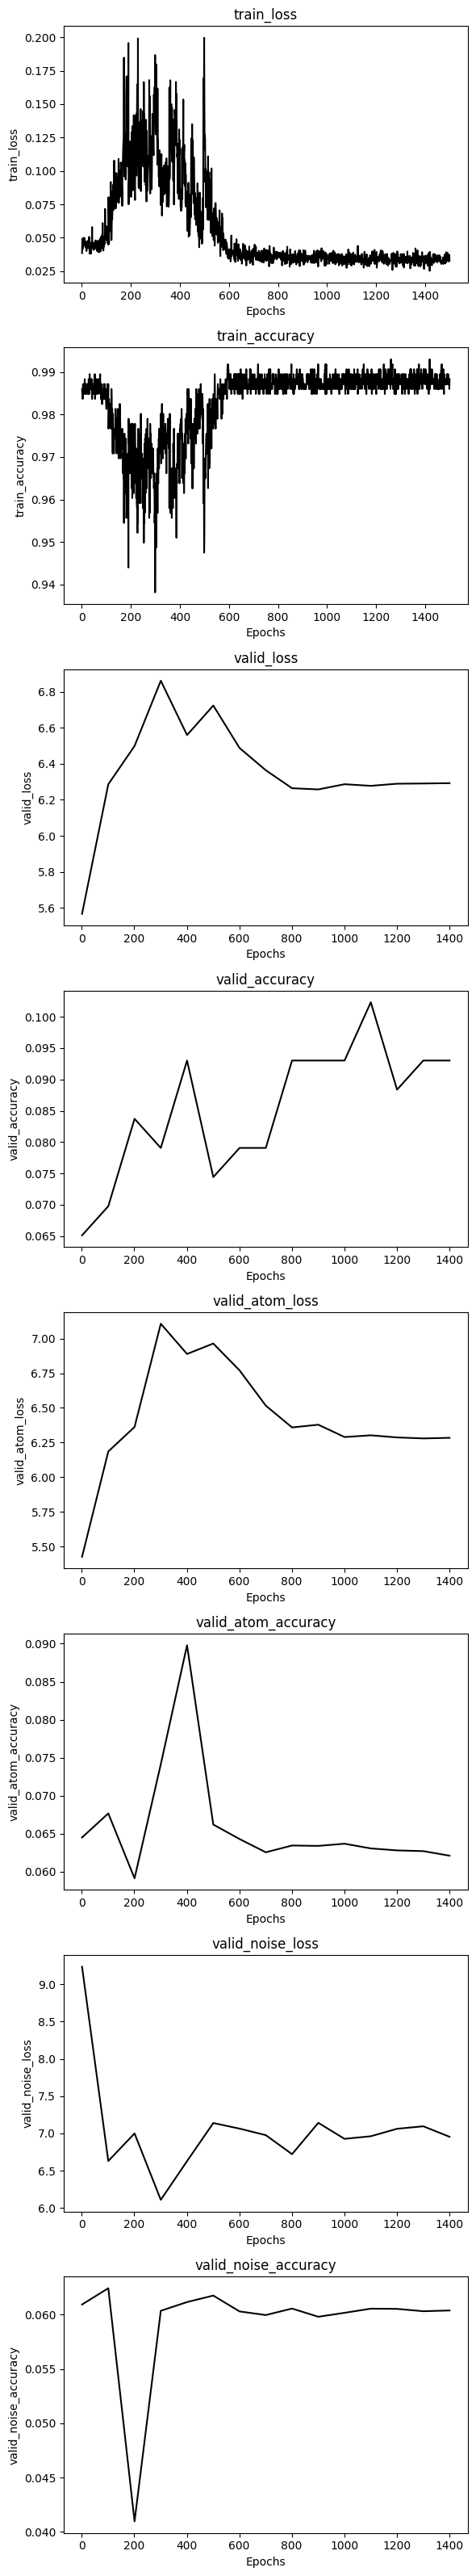

In [ ]:
trainer.plot_training_metrics()

### 10K dataset

10711


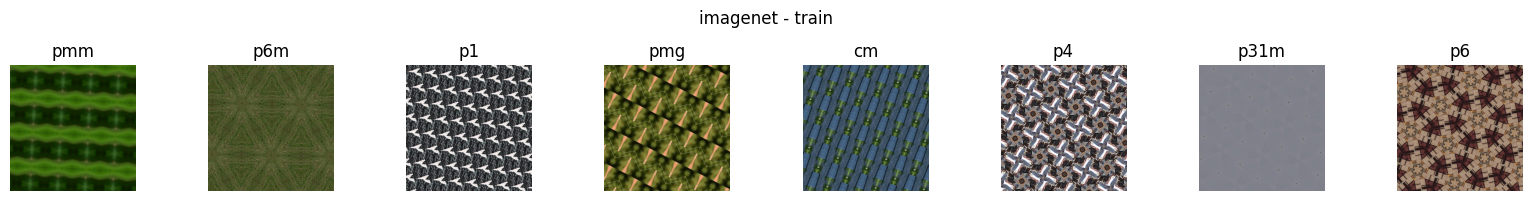

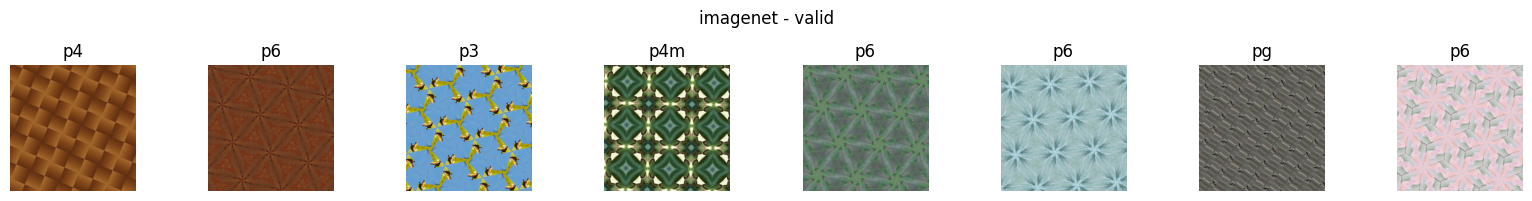

In [ ]:
# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
_, imagenet_ds = split_train_valid(imagenet_ds, 0.999, seed=42)
print(len(imagenet_ds))
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8, seed=42)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)
model.load_state_dict(torch.load('../../saved_models/08282024-resnet50-dataset_v5_size-10k-new/model_epoch_200.pth'))
model = torch.nn.DataParallel(model, device_ids=[7,9])
device = torch.device('cuda:7')
# model

torch.Size([2, 17])


In [ ]:
config = {'dataset': '10k datasets',
          'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
          'optimizer': 'Adam',
          'scheduler': 'OneCycleLR'}
NAME = '08282024-resnet50-dataset_v5_size-10k-new'
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, group='dataset_v5_size', save_code=True, config=config)
config = wandb.config

In [ ]:
lr = 1e-3
per_epoch = 20
epoch_start = 0
epochs = 200
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=None)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 1/200


100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


train_loss: 3.0890, train_accuracy: 6.02%
Epoch 2/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 3.0609, train_accuracy: 6.19%
Epoch 3/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 3.0782, train_accuracy: 6.26%
Epoch 4/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 3.0516, train_accuracy: 5.91%
Epoch 5/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 3.0249, train_accuracy: 6.69%
Epoch 6/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 3.0259, train_accuracy: 6.69%
Epoch 7/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 3.0073, train_accuracy: 6.86%
Epoch 8/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 2.9929, train_accuracy: 7.14%
Epoch 9/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 2.9912, train_accuracy: 7.04%
Epoch 10/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 2.9965, train_accuracy: 7.19%
Epoch 11/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 2.9902, train_accuracy: 7.04%
Epoch 12/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 2.9764, train_accuracy: 6.97%
Epoch 13/200


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 2.9672, train_accuracy: 7.04%
Epoch 14/200


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 2.9571, train_accuracy: 7.73%
Epoch 15/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 2.9493, train_accuracy: 7.53%
Epoch 16/200


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 2.9489, train_accuracy: 7.42%
Epoch 17/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 2.9366, train_accuracy: 7.68%
Epoch 18/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 2.9295, train_accuracy: 7.53%
Epoch 19/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 2.9258, train_accuracy: 7.35%
Epoch 20/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 2.9109, train_accuracy: 7.91%


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


valid_loss: 2.8559, valid_accuracy: 8.21%


100%|██████████| 170/170 [01:50<00:00,  1.54it/s]


valid_atom_loss: 2.8695, valid_atom_accuracy: 2.62%


100%|██████████| 85/85 [00:59<00:00,  1.43it/s]


valid_noise_loss: 3.0320, valid_noise_accuracy: 6.12%
Model saved at epoch 20
Epoch 21/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 2.9324, train_accuracy: 7.41%
Epoch 22/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.9012, train_accuracy: 7.18%
Epoch 23/200


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 2.9072, train_accuracy: 7.52%
Epoch 24/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 2.8932, train_accuracy: 7.50%
Epoch 25/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 2.8860, train_accuracy: 7.82%
Epoch 26/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.8923, train_accuracy: 8.04%
Epoch 27/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 2.8888, train_accuracy: 7.38%
Epoch 28/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.8833, train_accuracy: 7.59%
Epoch 29/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.8630, train_accuracy: 7.99%
Epoch 30/200


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 2.8654, train_accuracy: 7.99%
Epoch 31/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.8663, train_accuracy: 7.74%
Epoch 32/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.8559, train_accuracy: 8.12%
Epoch 33/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.8474, train_accuracy: 8.59%
Epoch 34/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.8516, train_accuracy: 8.37%
Epoch 35/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 2.8321, train_accuracy: 8.99%
Epoch 36/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 2.8331, train_accuracy: 9.02%
Epoch 37/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 2.8264, train_accuracy: 9.02%
Epoch 38/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.8198, train_accuracy: 9.62%
Epoch 39/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 2.8145, train_accuracy: 9.97%
Epoch 40/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.8015, train_accuracy: 10.31%


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


valid_loss: 2.9145, valid_accuracy: 10.17%


100%|██████████| 170/170 [01:52<00:00,  1.52it/s]


valid_atom_loss: 2.8151, valid_atom_accuracy: 6.40%


100%|██████████| 85/85 [00:57<00:00,  1.47it/s]


valid_noise_loss: 5.6573, valid_noise_accuracy: 5.70%
Model saved at epoch 40
Epoch 41/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 2.7743, train_accuracy: 10.52%
Epoch 42/200


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 2.7693, train_accuracy: 10.52%
Epoch 43/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 2.7599, train_accuracy: 11.19%
Epoch 44/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 2.7590, train_accuracy: 11.06%
Epoch 45/200


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 2.7207, train_accuracy: 12.23%
Epoch 46/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 2.7125, train_accuracy: 12.17%
Epoch 47/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 2.7061, train_accuracy: 12.39%
Epoch 48/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 2.6805, train_accuracy: 12.49%
Epoch 49/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 2.6216, train_accuracy: 13.10%
Epoch 50/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 2.5651, train_accuracy: 13.71%
Epoch 51/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 2.4753, train_accuracy: 16.29%
Epoch 52/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 2.4316, train_accuracy: 18.18%
Epoch 53/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 2.2981, train_accuracy: 21.71%
Epoch 54/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 2.1685, train_accuracy: 25.39%
Epoch 55/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 2.0311, train_accuracy: 29.39%
Epoch 56/200


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 1.9218, train_accuracy: 32.22%
Epoch 57/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 1.8306, train_accuracy: 34.29%
Epoch 58/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 1.7487, train_accuracy: 36.29%
Epoch 59/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 1.6729, train_accuracy: 39.01%
Epoch 60/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 1.5938, train_accuracy: 40.57%


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


valid_loss: 2.7280, valid_accuracy: 21.00%


100%|██████████| 170/170 [01:53<00:00,  1.50it/s]


valid_atom_loss: 3.0404, valid_atom_accuracy: 14.54%


100%|██████████| 85/85 [00:57<00:00,  1.48it/s]


valid_noise_loss: 3.9749, valid_noise_accuracy: 2.12%
Model saved at epoch 60
Epoch 61/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 1.5713, train_accuracy: 41.21%
Epoch 62/200


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 1.5766, train_accuracy: 42.87%
Epoch 63/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 1.5177, train_accuracy: 43.81%
Epoch 64/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 1.4273, train_accuracy: 46.64%
Epoch 65/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 1.3432, train_accuracy: 48.45%
Epoch 66/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 1.2656, train_accuracy: 51.67%
Epoch 67/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 1.2384, train_accuracy: 52.46%
Epoch 68/200


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 1.1942, train_accuracy: 54.45%
Epoch 69/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 1.1691, train_accuracy: 55.50%
Epoch 70/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 1.1183, train_accuracy: 57.45%
Epoch 71/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 1.0916, train_accuracy: 58.59%
Epoch 72/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 1.0893, train_accuracy: 58.77%
Epoch 73/200


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 1.1201, train_accuracy: 57.67%
Epoch 74/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 1.0283, train_accuracy: 61.20%
Epoch 75/200


100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


train_loss: 1.0145, train_accuracy: 62.51%
Epoch 76/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.9534, train_accuracy: 64.31%
Epoch 77/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.9785, train_accuracy: 63.08%
Epoch 78/200


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 0.8903, train_accuracy: 67.82%
Epoch 79/200


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train_loss: 0.8523, train_accuracy: 68.81%
Epoch 80/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.8374, train_accuracy: 69.53%


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


valid_loss: 1.3464, valid_accuracy: 52.87%


100%|██████████| 170/170 [01:47<00:00,  1.58it/s]


valid_atom_loss: 3.1213, valid_atom_accuracy: 27.22%


100%|██████████| 85/85 [00:55<00:00,  1.54it/s]


valid_noise_loss: 4.1316, valid_noise_accuracy: 6.41%
Model saved at epoch 80
Epoch 81/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.7817, train_accuracy: 71.92%
Epoch 82/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.7328, train_accuracy: 74.51%
Epoch 83/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.7551, train_accuracy: 72.90%
Epoch 84/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.7229, train_accuracy: 74.71%
Epoch 85/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.6744, train_accuracy: 77.26%
Epoch 86/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.6977, train_accuracy: 74.96%
Epoch 87/200


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 0.6309, train_accuracy: 78.76%
Epoch 88/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.5834, train_accuracy: 80.74%
Epoch 89/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.5604, train_accuracy: 82.49%
Epoch 90/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.5396, train_accuracy: 82.68%
Epoch 91/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.4928, train_accuracy: 84.97%
Epoch 92/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.5387, train_accuracy: 82.87%
Epoch 93/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.5008, train_accuracy: 84.54%
Epoch 94/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.5245, train_accuracy: 83.33%
Epoch 95/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.5491, train_accuracy: 82.18%
Epoch 96/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.4788, train_accuracy: 85.04%
Epoch 97/200


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.4888, train_accuracy: 84.56%
Epoch 98/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.5006, train_accuracy: 84.36%
Epoch 99/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.4938, train_accuracy: 83.75%
Epoch 100/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.4602, train_accuracy: 85.82%


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


valid_loss: 1.4315, valid_accuracy: 55.72%


100%|██████████| 170/170 [01:50<00:00,  1.54it/s]


valid_atom_loss: 3.0007, valid_atom_accuracy: 32.24%


100%|██████████| 85/85 [00:52<00:00,  1.62it/s]


valid_noise_loss: 4.6227, valid_noise_accuracy: 8.64%
Model saved at epoch 100
Epoch 101/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 0.4093, train_accuracy: 87.90%
Epoch 102/200


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.3794, train_accuracy: 88.90%
Epoch 103/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.3543, train_accuracy: 89.82%
Epoch 104/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.3379, train_accuracy: 90.01%
Epoch 105/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.3242, train_accuracy: 90.76%
Epoch 106/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 0.3191, train_accuracy: 90.88%
Epoch 107/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.3003, train_accuracy: 91.73%
Epoch 108/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.2917, train_accuracy: 91.83%
Epoch 109/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.2770, train_accuracy: 92.46%
Epoch 110/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.2746, train_accuracy: 92.57%
Epoch 111/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.2641, train_accuracy: 92.73%
Epoch 112/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.2734, train_accuracy: 92.62%
Epoch 113/200


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2497, train_accuracy: 93.37%
Epoch 114/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.2378, train_accuracy: 93.50%
Epoch 115/200


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 0.2441, train_accuracy: 93.31%
Epoch 116/200


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2752, train_accuracy: 92.26%
Epoch 117/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2478, train_accuracy: 93.24%
Epoch 118/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2433, train_accuracy: 93.45%
Epoch 119/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2259, train_accuracy: 94.01%
Epoch 120/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.2002, train_accuracy: 94.95%


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


valid_loss: 1.5104, valid_accuracy: 59.59%


100%|██████████| 170/170 [01:47<00:00,  1.58it/s]


valid_atom_loss: 3.5030, valid_atom_accuracy: 32.31%


100%|██████████| 85/85 [00:57<00:00,  1.48it/s]


valid_noise_loss: 5.6812, valid_noise_accuracy: 8.25%
Model saved at epoch 120
Epoch 121/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.2056, train_accuracy: 94.71%
Epoch 122/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2141, train_accuracy: 94.22%
Epoch 123/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2330, train_accuracy: 93.29%
Epoch 124/200


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2429, train_accuracy: 93.00%
Epoch 125/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2095, train_accuracy: 94.34%
Epoch 126/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2078, train_accuracy: 94.49%
Epoch 127/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.1883, train_accuracy: 95.05%
Epoch 128/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.1751, train_accuracy: 95.80%
Epoch 129/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.1783, train_accuracy: 95.52%
Epoch 130/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.1754, train_accuracy: 95.49%
Epoch 131/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 0.1550, train_accuracy: 96.31%
Epoch 132/200


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.1283, train_accuracy: 97.16%
Epoch 133/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.1200, train_accuracy: 97.39%
Epoch 134/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.1276, train_accuracy: 97.13%
Epoch 135/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.1297, train_accuracy: 96.80%
Epoch 136/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.1326, train_accuracy: 96.94%
Epoch 137/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.1354, train_accuracy: 96.64%
Epoch 138/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.1235, train_accuracy: 97.25%
Epoch 139/200


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.1249, train_accuracy: 97.23%
Epoch 140/200


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train_loss: 0.1195, train_accuracy: 97.26%


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


valid_loss: 1.5886, valid_accuracy: 60.57%


100%|██████████| 170/170 [01:51<00:00,  1.52it/s]


valid_atom_loss: 4.0106, valid_atom_accuracy: 29.41%


100%|██████████| 85/85 [00:53<00:00,  1.60it/s]


valid_noise_loss: 4.2626, valid_noise_accuracy: 12.70%
Model saved at epoch 140
Epoch 141/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.1204, train_accuracy: 97.25%
Epoch 142/200


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.1224, train_accuracy: 97.14%
Epoch 143/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.1175, train_accuracy: 97.46%
Epoch 144/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.1202, train_accuracy: 97.09%
Epoch 145/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1189, train_accuracy: 97.16%
Epoch 146/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.1103, train_accuracy: 97.74%
Epoch 147/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0997, train_accuracy: 97.93%
Epoch 148/200


100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


train_loss: 0.1075, train_accuracy: 97.57%
Epoch 149/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0971, train_accuracy: 98.14%
Epoch 150/200


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0955, train_accuracy: 98.02%
Epoch 151/200


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0851, train_accuracy: 98.24%
Epoch 152/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0921, train_accuracy: 98.11%
Epoch 153/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0843, train_accuracy: 98.40%
Epoch 154/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.0803, train_accuracy: 98.47%
Epoch 155/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0842, train_accuracy: 98.23%
Epoch 156/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0934, train_accuracy: 98.06%
Epoch 157/200


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train_loss: 0.0887, train_accuracy: 98.06%
Epoch 158/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0872, train_accuracy: 98.25%
Epoch 159/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0803, train_accuracy: 98.39%
Epoch 160/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0796, train_accuracy: 98.41%


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


valid_loss: 1.5698, valid_accuracy: 60.90%


100%|██████████| 170/170 [01:42<00:00,  1.65it/s]


valid_atom_loss: 3.6216, valid_atom_accuracy: 36.13%


100%|██████████| 85/85 [00:56<00:00,  1.52it/s]


valid_noise_loss: 3.8235, valid_noise_accuracy: 16.31%
Model saved at epoch 160
Epoch 161/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0766, train_accuracy: 98.60%
Epoch 162/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0830, train_accuracy: 98.26%
Epoch 163/200


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0822, train_accuracy: 98.24%
Epoch 164/200


100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


train_loss: 0.0827, train_accuracy: 98.35%
Epoch 165/200


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.0826, train_accuracy: 98.31%
Epoch 166/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0784, train_accuracy: 98.48%
Epoch 167/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0720, train_accuracy: 98.52%
Epoch 168/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0725, train_accuracy: 98.55%
Epoch 169/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0726, train_accuracy: 98.53%
Epoch 170/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0674, train_accuracy: 98.70%
Epoch 171/200


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 0.0700, train_accuracy: 98.60%
Epoch 172/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0689, train_accuracy: 98.59%
Epoch 173/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0649, train_accuracy: 98.75%
Epoch 174/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.0634, train_accuracy: 98.84%
Epoch 175/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0600, train_accuracy: 98.80%
Epoch 176/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0662, train_accuracy: 98.63%
Epoch 177/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0640, train_accuracy: 98.77%
Epoch 178/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0658, train_accuracy: 98.69%
Epoch 179/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0672, train_accuracy: 98.73%
Epoch 180/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0660, train_accuracy: 98.68%


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


valid_loss: 1.5873, valid_accuracy: 61.46%


100%|██████████| 170/170 [01:51<00:00,  1.52it/s]


valid_atom_loss: 3.4599, valid_atom_accuracy: 36.56%


100%|██████████| 85/85 [00:54<00:00,  1.56it/s]


valid_noise_loss: 3.8484, valid_noise_accuracy: 16.37%
Model saved at epoch 180
Epoch 181/200


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0646, train_accuracy: 98.79%
Epoch 182/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0633, train_accuracy: 98.76%
Epoch 183/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0627, train_accuracy: 98.84%
Epoch 184/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0613, train_accuracy: 98.79%
Epoch 185/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0666, train_accuracy: 98.72%
Epoch 186/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0613, train_accuracy: 98.86%
Epoch 187/200


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0598, train_accuracy: 98.87%
Epoch 188/200


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train_loss: 0.0600, train_accuracy: 98.84%
Epoch 189/200


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.0622, train_accuracy: 98.82%
Epoch 190/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0604, train_accuracy: 98.82%
Epoch 191/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0596, train_accuracy: 98.83%
Epoch 192/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0591, train_accuracy: 98.88%
Epoch 193/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0623, train_accuracy: 98.76%
Epoch 194/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0615, train_accuracy: 98.88%
Epoch 195/200


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0616, train_accuracy: 98.81%
Epoch 196/200


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0636, train_accuracy: 98.82%
Epoch 197/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0584, train_accuracy: 98.89%
Epoch 198/200


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0619, train_accuracy: 98.81%
Epoch 199/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0631, train_accuracy: 98.81%
Epoch 200/200


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0613, train_accuracy: 98.79%


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


valid_loss: 1.5764, valid_accuracy: 61.18%


100%|██████████| 170/170 [01:52<00:00,  1.52it/s]


valid_atom_loss: 3.3999, valid_atom_accuracy: 37.36%


100%|██████████| 85/85 [00:52<00:00,  1.62it/s]


valid_noise_loss: 3.7641, valid_noise_accuracy: 16.75%
Model saved at epoch 200


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


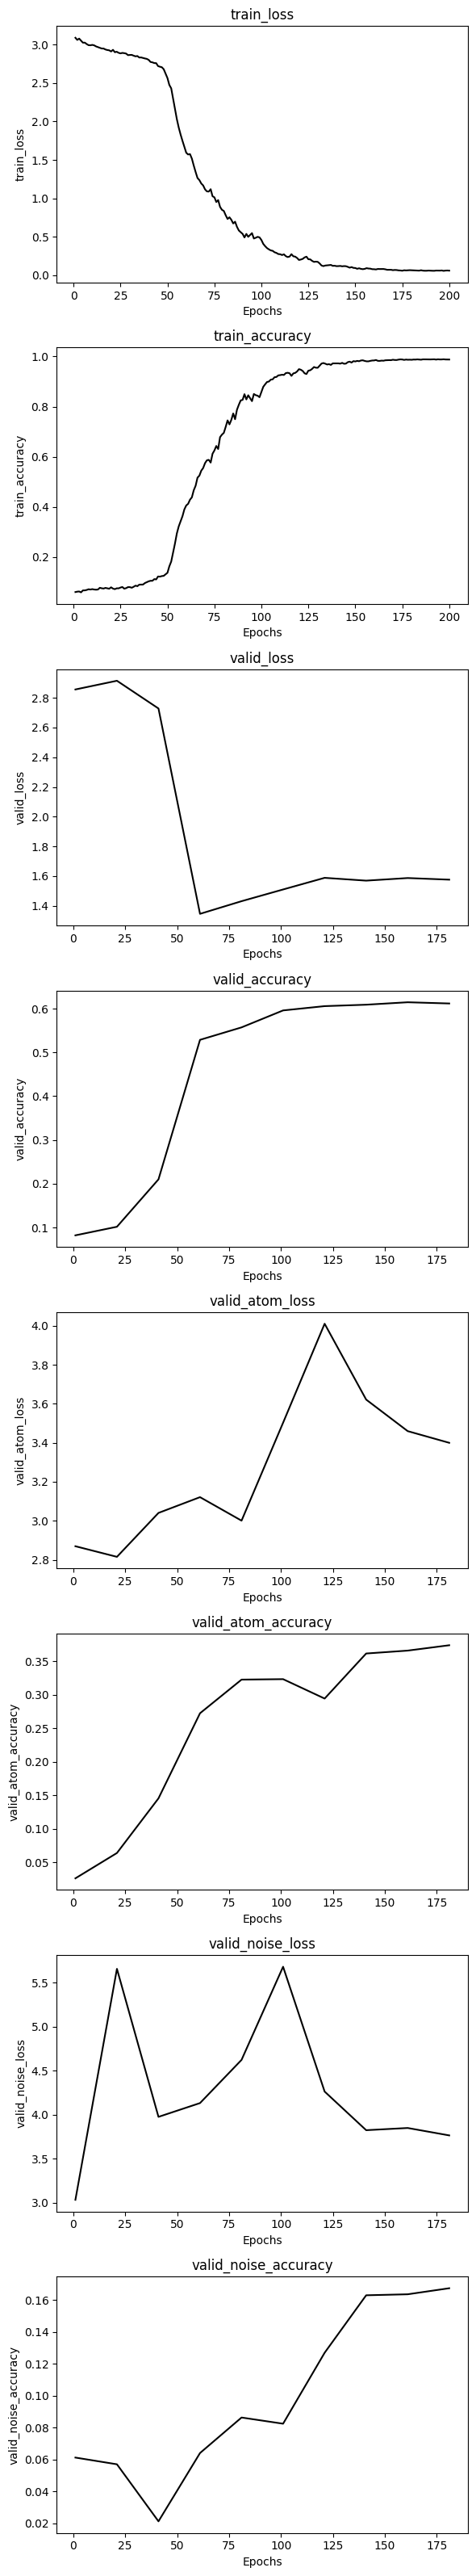

In [ ]:
trainer.plot_training_metrics()

In [ ]:
lr = 1e-3
per_epoch = 20
epoch_start = 200
epochs = 300
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=None)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 201/500


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


train_loss: 0.0644, train_accuracy: 98.76%
Epoch 202/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0612, train_accuracy: 98.76%
Epoch 203/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0628, train_accuracy: 98.68%
Epoch 204/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0639, train_accuracy: 98.68%
Epoch 205/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0644, train_accuracy: 98.55%
Epoch 206/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0621, train_accuracy: 98.87%
Epoch 207/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0611, train_accuracy: 98.72%
Epoch 208/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0587, train_accuracy: 98.87%
Epoch 209/500


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.0620, train_accuracy: 98.69%
Epoch 210/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0627, train_accuracy: 98.63%
Epoch 211/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0610, train_accuracy: 98.73%
Epoch 212/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0609, train_accuracy: 98.74%
Epoch 213/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0608, train_accuracy: 98.75%
Epoch 214/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0643, train_accuracy: 98.69%
Epoch 215/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0728, train_accuracy: 98.33%
Epoch 216/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0686, train_accuracy: 98.58%
Epoch 217/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0733, train_accuracy: 98.42%
Epoch 218/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0674, train_accuracy: 98.47%
Epoch 219/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0707, train_accuracy: 98.39%
Epoch 220/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0777, train_accuracy: 98.25%


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


valid_loss: 1.9424, valid_accuracy: 57.54%


100%|██████████| 170/170 [01:38<00:00,  1.73it/s]


valid_atom_loss: 3.5580, valid_atom_accuracy: 34.57%


100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


valid_noise_loss: 5.1648, valid_noise_accuracy: 11.46%
Model saved at epoch 220
Epoch 221/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0815, train_accuracy: 98.11%
Epoch 222/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0777, train_accuracy: 98.17%
Epoch 223/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0882, train_accuracy: 97.88%
Epoch 224/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1108, train_accuracy: 97.12%
Epoch 225/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1045, train_accuracy: 97.40%
Epoch 226/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.1072, train_accuracy: 97.36%
Epoch 227/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.1074, train_accuracy: 97.04%
Epoch 228/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.1172, train_accuracy: 97.07%
Epoch 229/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1707, train_accuracy: 95.18%
Epoch 230/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.2029, train_accuracy: 93.94%
Epoch 231/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2224, train_accuracy: 93.46%
Epoch 232/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2195, train_accuracy: 93.49%
Epoch 233/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.2265, train_accuracy: 93.36%
Epoch 234/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.2254, train_accuracy: 93.18%
Epoch 235/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.2812, train_accuracy: 91.12%
Epoch 236/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2880, train_accuracy: 91.23%
Epoch 237/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.2479, train_accuracy: 91.82%
Epoch 238/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2529, train_accuracy: 92.23%
Epoch 239/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2409, train_accuracy: 92.78%
Epoch 240/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.2438, train_accuracy: 92.76%


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


valid_loss: 1.6953, valid_accuracy: 58.89%


100%|██████████| 170/170 [01:38<00:00,  1.73it/s]


valid_atom_loss: 3.6854, valid_atom_accuracy: 32.83%


100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


valid_noise_loss: 4.7252, valid_noise_accuracy: 15.60%
Model saved at epoch 240
Epoch 241/500


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 0.2360, train_accuracy: 92.52%
Epoch 242/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.2924, train_accuracy: 90.95%
Epoch 243/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2939, train_accuracy: 90.83%
Epoch 244/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2843, train_accuracy: 91.11%
Epoch 245/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2844, train_accuracy: 91.15%
Epoch 246/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2944, train_accuracy: 90.86%
Epoch 247/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2464, train_accuracy: 92.40%
Epoch 248/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2626, train_accuracy: 91.85%
Epoch 249/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2653, train_accuracy: 91.84%
Epoch 250/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2912, train_accuracy: 91.16%
Epoch 251/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2892, train_accuracy: 91.05%
Epoch 252/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2595, train_accuracy: 91.96%
Epoch 253/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2277, train_accuracy: 93.03%
Epoch 254/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.2078, train_accuracy: 93.84%
Epoch 255/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2057, train_accuracy: 93.90%
Epoch 256/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2454, train_accuracy: 92.53%
Epoch 257/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2483, train_accuracy: 92.17%
Epoch 258/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2787, train_accuracy: 91.25%
Epoch 259/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2805, train_accuracy: 91.39%
Epoch 260/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2744, train_accuracy: 91.48%


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


valid_loss: 1.6392, valid_accuracy: 58.24%


100%|██████████| 170/170 [01:39<00:00,  1.72it/s]


valid_atom_loss: 2.8006, valid_atom_accuracy: 39.78%


100%|██████████| 85/85 [00:49<00:00,  1.70it/s]


valid_noise_loss: 4.2007, valid_noise_accuracy: 15.29%
Model saved at epoch 260
Epoch 261/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.2832, train_accuracy: 91.56%
Epoch 262/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.3404, train_accuracy: 89.52%
Epoch 263/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.3176, train_accuracy: 89.86%
Epoch 264/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.3099, train_accuracy: 90.25%
Epoch 265/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2902, train_accuracy: 90.98%
Epoch 266/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2441, train_accuracy: 92.34%
Epoch 267/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.2359, train_accuracy: 92.82%
Epoch 268/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2271, train_accuracy: 93.20%
Epoch 269/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1971, train_accuracy: 94.13%
Epoch 270/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1724, train_accuracy: 94.79%
Epoch 271/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2086, train_accuracy: 93.90%
Epoch 272/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2084, train_accuracy: 93.67%
Epoch 273/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.1812, train_accuracy: 94.65%
Epoch 274/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.1549, train_accuracy: 95.56%
Epoch 275/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2372, train_accuracy: 92.73%
Epoch 276/500


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 0.2474, train_accuracy: 92.71%
Epoch 277/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.3733, train_accuracy: 88.49%
Epoch 278/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2910, train_accuracy: 90.79%
Epoch 279/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2519, train_accuracy: 91.99%
Epoch 280/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2277, train_accuracy: 92.88%


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


valid_loss: 1.6149, valid_accuracy: 60.43%


100%|██████████| 170/170 [01:37<00:00,  1.74it/s]


valid_atom_loss: 3.7563, valid_atom_accuracy: 34.52%


100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


valid_noise_loss: 3.8953, valid_noise_accuracy: 16.70%
Model saved at epoch 280
Epoch 281/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2029, train_accuracy: 93.85%
Epoch 282/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.2312, train_accuracy: 93.13%
Epoch 283/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2612, train_accuracy: 92.10%
Epoch 284/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2392, train_accuracy: 92.64%
Epoch 285/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2765, train_accuracy: 91.55%
Epoch 286/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2194, train_accuracy: 93.56%
Epoch 287/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.2108, train_accuracy: 93.99%
Epoch 288/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.1846, train_accuracy: 94.49%
Epoch 289/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1314, train_accuracy: 96.49%
Epoch 290/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1168, train_accuracy: 96.93%
Epoch 291/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1097, train_accuracy: 97.14%
Epoch 292/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.1324, train_accuracy: 96.59%
Epoch 293/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1206, train_accuracy: 96.59%
Epoch 294/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1151, train_accuracy: 96.78%
Epoch 295/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.1263, train_accuracy: 96.28%
Epoch 296/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.1527, train_accuracy: 95.48%
Epoch 297/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1343, train_accuracy: 96.02%
Epoch 298/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1560, train_accuracy: 95.54%
Epoch 299/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1589, train_accuracy: 95.17%
Epoch 300/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1421, train_accuracy: 95.79%


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


valid_loss: 1.7651, valid_accuracy: 61.92%


100%|██████████| 170/170 [01:38<00:00,  1.72it/s]


valid_atom_loss: 3.1831, valid_atom_accuracy: 37.71%


100%|██████████| 85/85 [00:50<00:00,  1.70it/s]


valid_noise_loss: 3.8819, valid_noise_accuracy: 18.79%
Model saved at epoch 300
Epoch 301/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1665, train_accuracy: 94.85%
Epoch 302/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1428, train_accuracy: 95.73%
Epoch 303/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.1350, train_accuracy: 96.06%
Epoch 304/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.1876, train_accuracy: 94.57%
Epoch 305/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1345, train_accuracy: 96.18%
Epoch 306/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1368, train_accuracy: 96.13%
Epoch 307/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.1211, train_accuracy: 96.55%
Epoch 308/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1783, train_accuracy: 95.26%
Epoch 309/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1530, train_accuracy: 95.53%
Epoch 310/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1476, train_accuracy: 95.81%
Epoch 311/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1334, train_accuracy: 96.29%
Epoch 312/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1210, train_accuracy: 96.59%
Epoch 313/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1154, train_accuracy: 96.71%
Epoch 314/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0981, train_accuracy: 97.29%
Epoch 315/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.1140, train_accuracy: 96.78%
Epoch 316/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.1141, train_accuracy: 96.77%
Epoch 317/500


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


train_loss: 0.0936, train_accuracy: 97.35%
Epoch 318/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0711, train_accuracy: 98.12%
Epoch 319/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0694, train_accuracy: 98.10%
Epoch 320/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0838, train_accuracy: 97.67%


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


valid_loss: 1.7874, valid_accuracy: 62.39%


100%|██████████| 170/170 [01:50<00:00,  1.54it/s]


valid_atom_loss: 3.1780, valid_atom_accuracy: 40.41%


100%|██████████| 85/85 [00:58<00:00,  1.46it/s]


valid_noise_loss: 4.5156, valid_noise_accuracy: 18.17%
Model saved at epoch 320
Epoch 321/500


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 0.0994, train_accuracy: 97.29%
Epoch 322/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0804, train_accuracy: 97.84%
Epoch 323/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.1212, train_accuracy: 96.72%
Epoch 324/500


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


train_loss: 0.1278, train_accuracy: 96.16%
Epoch 325/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.1225, train_accuracy: 96.42%
Epoch 326/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.1086, train_accuracy: 96.90%
Epoch 327/500


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0907, train_accuracy: 97.54%
Epoch 328/500


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0720, train_accuracy: 98.13%
Epoch 329/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0656, train_accuracy: 98.16%
Epoch 330/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0709, train_accuracy: 98.09%
Epoch 331/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0754, train_accuracy: 97.95%
Epoch 332/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0786, train_accuracy: 97.82%
Epoch 333/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.1733, train_accuracy: 95.16%
Epoch 334/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.1493, train_accuracy: 95.68%
Epoch 335/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.1367, train_accuracy: 96.00%
Epoch 336/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.1123, train_accuracy: 96.83%
Epoch 337/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.1063, train_accuracy: 96.86%
Epoch 338/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0966, train_accuracy: 97.25%
Epoch 339/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0876, train_accuracy: 97.54%
Epoch 340/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0887, train_accuracy: 97.48%


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


valid_loss: 1.8506, valid_accuracy: 60.57%


100%|██████████| 170/170 [01:44<00:00,  1.63it/s]


valid_atom_loss: 3.2202, valid_atom_accuracy: 40.55%


100%|██████████| 85/85 [00:53<00:00,  1.59it/s]


valid_noise_loss: 3.9884, valid_noise_accuracy: 17.98%
Model saved at epoch 340
Epoch 341/500


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.1167, train_accuracy: 96.79%
Epoch 342/500


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.1028, train_accuracy: 97.06%
Epoch 343/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0994, train_accuracy: 97.08%
Epoch 344/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0891, train_accuracy: 97.54%
Epoch 345/500


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.1186, train_accuracy: 96.95%
Epoch 346/500


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train_loss: 0.1290, train_accuracy: 96.32%
Epoch 347/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.1056, train_accuracy: 97.04%
Epoch 348/500


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0923, train_accuracy: 97.42%
Epoch 349/500


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.0973, train_accuracy: 97.19%
Epoch 350/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.1031, train_accuracy: 96.97%
Epoch 351/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0985, train_accuracy: 97.21%
Epoch 352/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0840, train_accuracy: 97.77%
Epoch 353/500


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.0858, train_accuracy: 97.71%
Epoch 354/500


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0678, train_accuracy: 98.16%
Epoch 355/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0562, train_accuracy: 98.54%
Epoch 356/500


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0569, train_accuracy: 98.61%
Epoch 357/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0757, train_accuracy: 98.09%
Epoch 358/500


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.0707, train_accuracy: 98.06%
Epoch 359/500


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.0691, train_accuracy: 98.11%
Epoch 360/500


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


train_loss: 0.0746, train_accuracy: 97.96%


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


valid_loss: 1.7317, valid_accuracy: 65.47%


100%|██████████| 170/170 [01:49<00:00,  1.55it/s]


valid_atom_loss: 3.2128, valid_atom_accuracy: 43.60%


100%|██████████| 85/85 [00:54<00:00,  1.55it/s]


valid_noise_loss: 3.9137, valid_noise_accuracy: 21.82%
Model saved at epoch 360
Epoch 361/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0708, train_accuracy: 98.04%
Epoch 362/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0645, train_accuracy: 98.23%
Epoch 363/500


100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


train_loss: 0.0698, train_accuracy: 98.17%
Epoch 364/500


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 0.0629, train_accuracy: 98.47%
Epoch 365/500


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.0710, train_accuracy: 98.11%
Epoch 366/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0580, train_accuracy: 98.45%
Epoch 367/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0538, train_accuracy: 98.55%
Epoch 368/500


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


train_loss: 0.0631, train_accuracy: 98.25%
Epoch 369/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0626, train_accuracy: 98.26%
Epoch 370/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0755, train_accuracy: 97.90%
Epoch 371/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0772, train_accuracy: 97.88%
Epoch 372/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.1607, train_accuracy: 95.79%
Epoch 373/500


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


train_loss: 0.1204, train_accuracy: 96.34%
Epoch 374/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0849, train_accuracy: 97.57%
Epoch 375/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0780, train_accuracy: 97.77%
Epoch 376/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0886, train_accuracy: 97.47%
Epoch 377/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0854, train_accuracy: 97.72%
Epoch 378/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0857, train_accuracy: 97.60%
Epoch 379/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0753, train_accuracy: 97.91%
Epoch 380/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0609, train_accuracy: 98.24%


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


valid_loss: 2.0265, valid_accuracy: 61.92%


100%|██████████| 170/170 [01:53<00:00,  1.49it/s]


valid_atom_loss: 4.5533, valid_atom_accuracy: 35.88%


100%|██████████| 85/85 [00:50<00:00,  1.67it/s]


valid_noise_loss: 4.1233, valid_noise_accuracy: 22.25%
Model saved at epoch 380
Epoch 381/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0664, train_accuracy: 98.17%
Epoch 382/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0615, train_accuracy: 98.31%
Epoch 383/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0589, train_accuracy: 98.35%
Epoch 384/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0559, train_accuracy: 98.37%
Epoch 385/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0554, train_accuracy: 98.60%
Epoch 386/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0552, train_accuracy: 98.46%
Epoch 387/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0468, train_accuracy: 98.76%
Epoch 388/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0504, train_accuracy: 98.66%
Epoch 389/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0487, train_accuracy: 98.76%
Epoch 390/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0585, train_accuracy: 98.37%
Epoch 391/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0686, train_accuracy: 98.12%
Epoch 392/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0727, train_accuracy: 98.00%
Epoch 393/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0622, train_accuracy: 98.33%
Epoch 394/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0610, train_accuracy: 98.23%
Epoch 395/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0582, train_accuracy: 98.48%
Epoch 396/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0623, train_accuracy: 98.24%
Epoch 397/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0597, train_accuracy: 98.53%
Epoch 398/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0515, train_accuracy: 98.61%
Epoch 399/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0510, train_accuracy: 98.67%
Epoch 400/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0461, train_accuracy: 98.73%


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


valid_loss: 1.7564, valid_accuracy: 66.78%


100%|██████████| 170/170 [01:40<00:00,  1.70it/s]


valid_atom_loss: 3.9466, valid_atom_accuracy: 36.21%


100%|██████████| 85/85 [00:51<00:00,  1.66it/s]


valid_noise_loss: 4.0840, valid_noise_accuracy: 23.11%
Model saved at epoch 400
Epoch 401/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0534, train_accuracy: 98.59%
Epoch 402/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0575, train_accuracy: 98.49%
Epoch 403/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0616, train_accuracy: 98.32%
Epoch 404/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0521, train_accuracy: 98.56%
Epoch 405/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0534, train_accuracy: 98.52%
Epoch 406/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0564, train_accuracy: 98.46%
Epoch 407/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0493, train_accuracy: 98.76%
Epoch 408/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0498, train_accuracy: 98.69%
Epoch 409/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0586, train_accuracy: 98.33%
Epoch 410/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0676, train_accuracy: 98.16%
Epoch 411/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0495, train_accuracy: 98.65%
Epoch 412/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0559, train_accuracy: 98.52%
Epoch 413/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0511, train_accuracy: 98.61%
Epoch 414/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0487, train_accuracy: 98.61%
Epoch 415/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0453, train_accuracy: 98.76%
Epoch 416/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0502, train_accuracy: 98.70%
Epoch 417/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0503, train_accuracy: 98.66%
Epoch 418/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0495, train_accuracy: 98.73%
Epoch 419/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0458, train_accuracy: 98.83%
Epoch 420/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0528, train_accuracy: 98.56%


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


valid_loss: 1.9127, valid_accuracy: 64.44%


100%|██████████| 170/170 [01:48<00:00,  1.56it/s]


valid_atom_loss: 3.8436, valid_atom_accuracy: 40.26%


100%|██████████| 85/85 [00:54<00:00,  1.56it/s]


valid_noise_loss: 4.0520, valid_noise_accuracy: 24.74%
Model saved at epoch 420
Epoch 421/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0462, train_accuracy: 98.73%
Epoch 422/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0431, train_accuracy: 98.86%
Epoch 423/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0437, train_accuracy: 98.83%
Epoch 424/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0422, train_accuracy: 98.90%
Epoch 425/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0429, train_accuracy: 98.77%
Epoch 426/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0416, train_accuracy: 98.83%
Epoch 427/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0437, train_accuracy: 98.81%
Epoch 428/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0426, train_accuracy: 98.80%
Epoch 429/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0439, train_accuracy: 98.80%
Epoch 430/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0410, train_accuracy: 98.83%
Epoch 431/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0428, train_accuracy: 98.80%
Epoch 432/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0405, train_accuracy: 98.82%
Epoch 433/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0411, train_accuracy: 98.90%
Epoch 434/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0409, train_accuracy: 98.84%
Epoch 435/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0424, train_accuracy: 98.80%
Epoch 436/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0432, train_accuracy: 98.83%
Epoch 437/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0439, train_accuracy: 98.84%
Epoch 438/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0412, train_accuracy: 98.89%
Epoch 439/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0410, train_accuracy: 98.84%
Epoch 440/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0432, train_accuracy: 98.77%


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


valid_loss: 1.8859, valid_accuracy: 65.42%


100%|██████████| 170/170 [01:37<00:00,  1.74it/s]


valid_atom_loss: 4.2161, valid_atom_accuracy: 37.33%


100%|██████████| 85/85 [00:49<00:00,  1.72it/s]


valid_noise_loss: 4.1133, valid_noise_accuracy: 23.67%
Model saved at epoch 440
Epoch 441/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0438, train_accuracy: 98.80%
Epoch 442/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0474, train_accuracy: 98.69%
Epoch 443/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0488, train_accuracy: 98.61%
Epoch 444/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0423, train_accuracy: 98.84%
Epoch 445/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0417, train_accuracy: 98.86%
Epoch 446/500


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


train_loss: 0.0427, train_accuracy: 98.81%
Epoch 447/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0415, train_accuracy: 98.82%
Epoch 448/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0424, train_accuracy: 98.77%
Epoch 449/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0404, train_accuracy: 98.84%
Epoch 450/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0412, train_accuracy: 98.82%
Epoch 451/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0407, train_accuracy: 98.86%
Epoch 452/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0411, train_accuracy: 98.87%
Epoch 453/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0409, train_accuracy: 98.86%
Epoch 454/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0406, train_accuracy: 98.88%
Epoch 455/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0411, train_accuracy: 98.86%
Epoch 456/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0411, train_accuracy: 98.81%
Epoch 457/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0401, train_accuracy: 98.80%
Epoch 458/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0402, train_accuracy: 98.84%
Epoch 459/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0401, train_accuracy: 98.88%
Epoch 460/500


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


train_loss: 0.0392, train_accuracy: 98.87%


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


valid_loss: 1.8694, valid_accuracy: 65.42%


100%|██████████| 170/170 [01:47<00:00,  1.58it/s]


valid_atom_loss: 3.7055, valid_atom_accuracy: 43.29%


100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


valid_noise_loss: 4.0248, valid_noise_accuracy: 24.31%
Model saved at epoch 460
Epoch 461/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0402, train_accuracy: 98.87%
Epoch 462/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0436, train_accuracy: 98.80%
Epoch 463/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0392, train_accuracy: 98.93%
Epoch 464/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0402, train_accuracy: 98.88%
Epoch 465/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0389, train_accuracy: 98.91%
Epoch 466/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0390, train_accuracy: 98.95%
Epoch 467/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0392, train_accuracy: 98.86%
Epoch 468/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0395, train_accuracy: 98.90%
Epoch 469/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0416, train_accuracy: 98.80%
Epoch 470/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0386, train_accuracy: 98.93%
Epoch 471/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0408, train_accuracy: 98.79%
Epoch 472/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0390, train_accuracy: 98.88%
Epoch 473/500


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


train_loss: 0.0410, train_accuracy: 98.84%
Epoch 474/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0384, train_accuracy: 98.91%
Epoch 475/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0396, train_accuracy: 98.89%
Epoch 476/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0392, train_accuracy: 98.89%
Epoch 477/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0388, train_accuracy: 98.90%
Epoch 478/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0402, train_accuracy: 98.86%
Epoch 479/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0410, train_accuracy: 98.79%
Epoch 480/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0407, train_accuracy: 98.89%


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


valid_loss: 1.8010, valid_accuracy: 66.08%


100%|██████████| 170/170 [01:41<00:00,  1.68it/s]


valid_atom_loss: 3.8149, valid_atom_accuracy: 41.95%


100%|██████████| 85/85 [00:50<00:00,  1.67it/s]


valid_noise_loss: 4.0655, valid_noise_accuracy: 24.09%
Model saved at epoch 480
Epoch 481/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0407, train_accuracy: 98.86%
Epoch 482/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0394, train_accuracy: 98.88%
Epoch 483/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0404, train_accuracy: 98.86%
Epoch 484/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0407, train_accuracy: 98.84%
Epoch 485/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0398, train_accuracy: 98.87%
Epoch 486/500


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


train_loss: 0.0420, train_accuracy: 98.84%
Epoch 487/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0390, train_accuracy: 98.90%
Epoch 488/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0396, train_accuracy: 98.89%
Epoch 489/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0394, train_accuracy: 98.90%
Epoch 490/500


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


train_loss: 0.0414, train_accuracy: 98.84%
Epoch 491/500


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


train_loss: 0.0388, train_accuracy: 98.89%
Epoch 492/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0391, train_accuracy: 98.89%
Epoch 493/500


100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


train_loss: 0.0408, train_accuracy: 98.88%
Epoch 494/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0397, train_accuracy: 98.87%
Epoch 495/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0388, train_accuracy: 98.86%
Epoch 496/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0390, train_accuracy: 98.91%
Epoch 497/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0377, train_accuracy: 98.88%
Epoch 498/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0396, train_accuracy: 98.88%
Epoch 499/500


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


train_loss: 0.0395, train_accuracy: 98.90%
Epoch 500/500


100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


train_loss: 0.0396, train_accuracy: 98.90%


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


valid_loss: 1.8057, valid_accuracy: 66.82%


100%|██████████| 170/170 [01:41<00:00,  1.67it/s]


valid_atom_loss: 3.8136, valid_atom_accuracy: 42.06%


100%|██████████| 85/85 [00:52<00:00,  1.61it/s]


valid_noise_loss: 4.1430, valid_noise_accuracy: 23.69%
Model saved at epoch 500


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


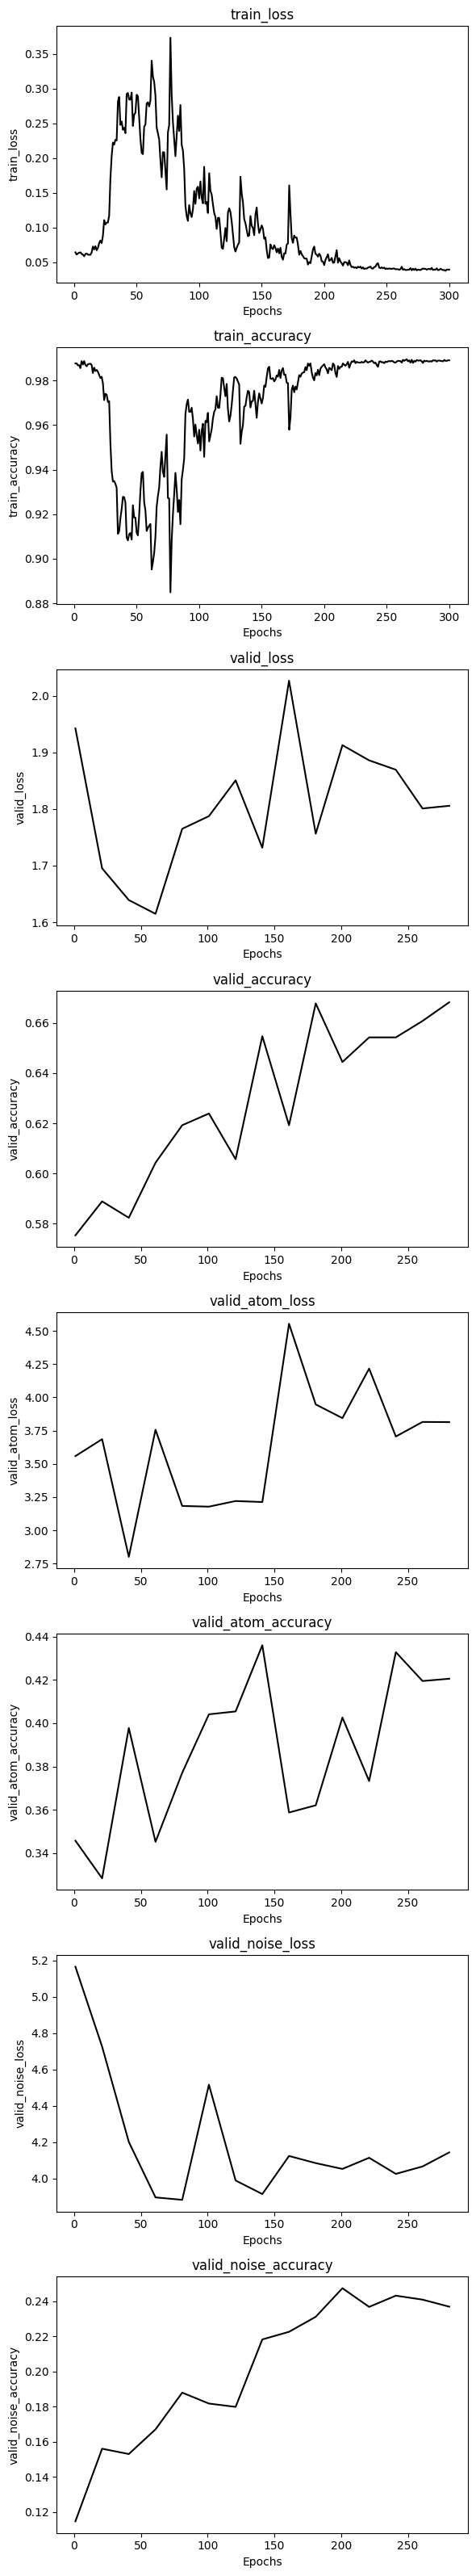

In [ ]:
trainer.plot_training_metrics()

### 100K dataset

107101


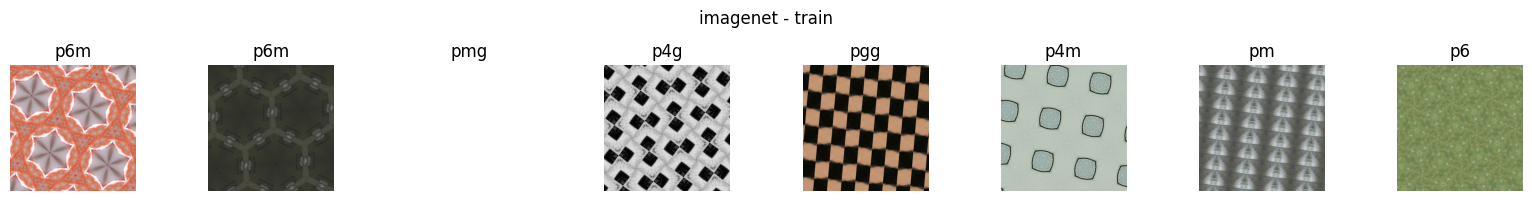

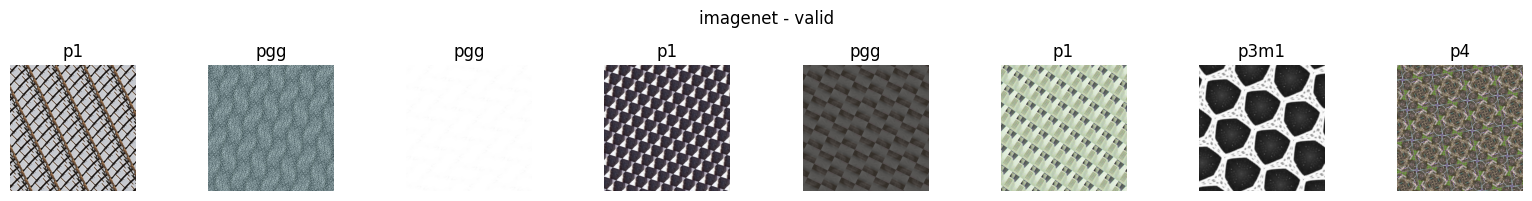

In [ ]:
# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
_, imagenet_ds = split_train_valid(imagenet_ds, 0.99, seed=42)
print(len(imagenet_ds))
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8, seed=42)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)
model.load_state_dict(torch.load('../../saved_models/08282024-resnet50-dataset_v5_size-100k/model_epoch_50.pth'))
model = torch.nn.DataParallel(model, device_ids=[7,9])
device = torch.device('cuda:7')
# model

torch.Size([2, 17])


In [ ]:
config = {'dataset': '100k datasets',
          'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
          'optimizer': 'Adam',
          'scheduler': 'OneCycleLR'}
NAME = '08282024-resnet50-dataset_v5_size-100k'
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, group='dataset_v5_size', save_code=True, config=config)
config = wandb.config

In [ ]:
lr = 1e-3
per_epoch = 5
epoch_start = 0
epochs = 50
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=None)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 1/50


100%|██████████| 72/72 [01:25<00:00,  1.19s/it]


train_loss: 3.0283, train_accuracy: 6.63%
Epoch 2/50


100%|██████████| 72/72 [01:23<00:00,  1.16s/it]


train_loss: 2.9674, train_accuracy: 6.94%
Epoch 3/50


100%|██████████| 72/72 [01:25<00:00,  1.18s/it]


train_loss: 2.9198, train_accuracy: 7.04%
Epoch 4/50


100%|██████████| 72/72 [01:25<00:00,  1.19s/it]


train_loss: 2.8854, train_accuracy: 7.24%
Epoch 5/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 2.8610, train_accuracy: 7.83%


100%|██████████| 18/18 [00:12<00:00,  1.44it/s]


valid_loss: 2.8223, valid_accuracy: 8.40%


100%|██████████| 170/170 [01:43<00:00,  1.64it/s]


valid_atom_loss: 2.8367, valid_atom_accuracy: 5.89%


100%|██████████| 85/85 [00:53<00:00,  1.59it/s]


valid_noise_loss: 3.3160, valid_noise_accuracy: 5.89%
Model saved at epoch 5
Epoch 6/50


100%|██████████| 72/72 [01:22<00:00,  1.14s/it]


train_loss: 2.8061, train_accuracy: 9.27%
Epoch 7/50


100%|██████████| 72/72 [01:22<00:00,  1.14s/it]


train_loss: 2.7176, train_accuracy: 10.88%
Epoch 8/50


100%|██████████| 72/72 [01:22<00:00,  1.14s/it]


train_loss: 2.2691, train_accuracy: 21.93%
Epoch 9/50


100%|██████████| 72/72 [01:25<00:00,  1.19s/it]


train_loss: 1.5816, train_accuracy: 41.76%
Epoch 10/50


100%|██████████| 72/72 [01:25<00:00,  1.19s/it]


train_loss: 1.2277, train_accuracy: 53.33%


100%|██████████| 18/18 [00:12<00:00,  1.48it/s]


valid_loss: 1.2990, valid_accuracy: 50.57%


100%|██████████| 170/170 [01:45<00:00,  1.62it/s]


valid_atom_loss: 1.7405, valid_atom_accuracy: 39.07%


100%|██████████| 85/85 [00:56<00:00,  1.52it/s]


valid_noise_loss: 3.1963, valid_noise_accuracy: 14.02%
Model saved at epoch 10
Epoch 11/50


100%|██████████| 72/72 [01:24<00:00,  1.18s/it]


train_loss: 1.0167, train_accuracy: 61.68%
Epoch 12/50


100%|██████████| 72/72 [01:23<00:00,  1.16s/it]


train_loss: 0.8616, train_accuracy: 67.97%
Epoch 13/50


100%|██████████| 72/72 [01:26<00:00,  1.20s/it]


train_loss: 0.7571, train_accuracy: 72.05%
Epoch 14/50


100%|██████████| 72/72 [01:24<00:00,  1.17s/it]


train_loss: 0.6735, train_accuracy: 75.44%
Epoch 15/50


100%|██████████| 72/72 [01:24<00:00,  1.17s/it]


train_loss: 0.6119, train_accuracy: 77.83%


100%|██████████| 18/18 [00:12<00:00,  1.41it/s]


valid_loss: 0.8888, valid_accuracy: 68.43%


100%|██████████| 170/170 [01:50<00:00,  1.53it/s]


valid_atom_loss: 1.4705, valid_atom_accuracy: 55.79%


100%|██████████| 85/85 [00:54<00:00,  1.56it/s]


valid_noise_loss: 3.0922, valid_noise_accuracy: 19.52%
Model saved at epoch 15
Epoch 16/50


100%|██████████| 72/72 [01:23<00:00,  1.15s/it]


train_loss: 0.5655, train_accuracy: 79.34%
Epoch 17/50


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.5180, train_accuracy: 81.22%
Epoch 18/50


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.4745, train_accuracy: 82.97%
Epoch 19/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.4569, train_accuracy: 83.69%
Epoch 20/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.4229, train_accuracy: 84.98%


100%|██████████| 18/18 [00:12<00:00,  1.42it/s]


valid_loss: 0.8623, valid_accuracy: 77.61%


100%|██████████| 170/170 [01:50<00:00,  1.54it/s]


valid_atom_loss: 1.9595, valid_atom_accuracy: 51.61%


100%|██████████| 85/85 [00:54<00:00,  1.55it/s]


valid_noise_loss: 2.8033, valid_noise_accuracy: 24.83%
Model saved at epoch 20
Epoch 21/50


100%|██████████| 72/72 [01:22<00:00,  1.14s/it]


train_loss: 0.3905, train_accuracy: 86.15%
Epoch 22/50


100%|██████████| 72/72 [01:23<00:00,  1.16s/it]


train_loss: 0.3627, train_accuracy: 87.18%
Epoch 23/50


100%|██████████| 72/72 [01:23<00:00,  1.16s/it]


train_loss: 0.3338, train_accuracy: 88.28%
Epoch 24/50


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.2974, train_accuracy: 89.53%
Epoch 25/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.2869, train_accuracy: 89.93%


100%|██████████| 18/18 [00:12<00:00,  1.46it/s]


valid_loss: 0.6492, valid_accuracy: 79.16%


100%|██████████| 170/170 [01:46<00:00,  1.59it/s]


valid_atom_loss: 1.9007, valid_atom_accuracy: 56.75%


100%|██████████| 85/85 [00:54<00:00,  1.55it/s]


valid_noise_loss: 4.2834, valid_noise_accuracy: 18.08%
Model saved at epoch 25
Epoch 26/50


100%|██████████| 72/72 [01:23<00:00,  1.16s/it]


train_loss: 0.2527, train_accuracy: 91.21%
Epoch 27/50


100%|██████████| 72/72 [01:21<00:00,  1.14s/it]


train_loss: 0.2528, train_accuracy: 91.25%
Epoch 28/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.2149, train_accuracy: 92.62%
Epoch 29/50


100%|██████████| 72/72 [01:21<00:00,  1.14s/it]


train_loss: 0.1998, train_accuracy: 93.06%
Epoch 30/50


100%|██████████| 72/72 [01:21<00:00,  1.14s/it]


train_loss: 0.1754, train_accuracy: 93.97%


100%|██████████| 18/18 [00:12<00:00,  1.46it/s]


valid_loss: 0.6560, valid_accuracy: 83.96%


100%|██████████| 170/170 [01:44<00:00,  1.63it/s]


valid_atom_loss: 2.3006, valid_atom_accuracy: 56.70%


100%|██████████| 85/85 [00:54<00:00,  1.56it/s]


valid_noise_loss: 3.2674, valid_noise_accuracy: 27.27%
Model saved at epoch 30
Epoch 31/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.1597, train_accuracy: 94.69%
Epoch 32/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.1416, train_accuracy: 95.29%
Epoch 33/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.1307, train_accuracy: 95.76%
Epoch 34/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.1154, train_accuracy: 96.36%
Epoch 35/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0982, train_accuracy: 97.01%


100%|██████████| 18/18 [00:12<00:00,  1.47it/s]


valid_loss: 0.8404, valid_accuracy: 85.84%


100%|██████████| 170/170 [01:42<00:00,  1.65it/s]


valid_atom_loss: 2.5505, valid_atom_accuracy: 58.21%


100%|██████████| 85/85 [00:52<00:00,  1.61it/s]


valid_noise_loss: 3.1738, valid_noise_accuracy: 31.28%
Model saved at epoch 35
Epoch 36/50


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.0808, train_accuracy: 97.71%
Epoch 37/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0713, train_accuracy: 97.91%
Epoch 38/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0625, train_accuracy: 98.28%
Epoch 39/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0542, train_accuracy: 98.56%
Epoch 40/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0496, train_accuracy: 98.68%


100%|██████████| 18/18 [00:12<00:00,  1.48it/s]


valid_loss: 0.6479, valid_accuracy: 86.40%


100%|██████████| 170/170 [01:42<00:00,  1.66it/s]


valid_atom_loss: 2.6783, valid_atom_accuracy: 56.88%


100%|██████████| 85/85 [00:52<00:00,  1.61it/s]


valid_noise_loss: 3.7696, valid_noise_accuracy: 29.08%
Model saved at epoch 40
Epoch 41/50


100%|██████████| 72/72 [01:22<00:00,  1.14s/it]


train_loss: 0.0474, train_accuracy: 98.74%
Epoch 42/50


100%|██████████| 72/72 [01:21<00:00,  1.14s/it]


train_loss: 0.0445, train_accuracy: 98.81%
Epoch 43/50


100%|██████████| 72/72 [01:20<00:00,  1.11s/it]


train_loss: 0.0427, train_accuracy: 98.86%
Epoch 44/50


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.0422, train_accuracy: 98.86%
Epoch 45/50


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.0409, train_accuracy: 98.89%


100%|██████████| 18/18 [00:12<00:00,  1.46it/s]


valid_loss: 0.5871, valid_accuracy: 86.93%


100%|██████████| 170/170 [01:43<00:00,  1.65it/s]


valid_atom_loss: 2.4243, valid_atom_accuracy: 59.53%


100%|██████████| 85/85 [00:50<00:00,  1.67it/s]


valid_noise_loss: 3.4254, valid_noise_accuracy: 32.33%
Model saved at epoch 45
Epoch 46/50


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.0408, train_accuracy: 98.89%
Epoch 47/50


100%|██████████| 72/72 [01:22<00:00,  1.15s/it]


train_loss: 0.0402, train_accuracy: 98.88%
Epoch 48/50


100%|██████████| 72/72 [01:22<00:00,  1.15s/it]


train_loss: 0.0402, train_accuracy: 98.90%
Epoch 49/50


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.0405, train_accuracy: 98.89%
Epoch 50/50


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0397, train_accuracy: 98.90%


100%|██████████| 18/18 [00:12<00:00,  1.39it/s]


valid_loss: 0.5886, valid_accuracy: 86.23%


100%|██████████| 170/170 [01:46<00:00,  1.59it/s]


valid_atom_loss: 2.4591, valid_atom_accuracy: 59.24%


100%|██████████| 85/85 [00:51<00:00,  1.65it/s]


valid_noise_loss: 3.5327, valid_noise_accuracy: 31.62%
Model saved at epoch 50


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [ ]:
lr = 1e-3
per_epoch = 5
epoch_start = 50
epochs = 50
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=None)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 51/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.0416, train_accuracy: 98.87%
Epoch 52/100


100%|██████████| 72/72 [01:19<00:00,  1.11s/it]


train_loss: 0.0429, train_accuracy: 98.80%
Epoch 53/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0526, train_accuracy: 98.48%
Epoch 54/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0838, train_accuracy: 97.46%
Epoch 55/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.1276, train_accuracy: 96.05%


100%|██████████| 18/18 [00:12<00:00,  1.45it/s]


valid_loss: 0.7013, valid_accuracy: 82.84%


100%|██████████| 170/170 [01:41<00:00,  1.67it/s]


valid_atom_loss: 3.2218, valid_atom_accuracy: 54.57%


100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


valid_noise_loss: 3.1110, valid_noise_accuracy: 30.87%
Model saved at epoch 55
Epoch 56/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.1591, train_accuracy: 94.91%
Epoch 57/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.1936, train_accuracy: 93.86%
Epoch 58/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.2164, train_accuracy: 93.13%
Epoch 59/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.2076, train_accuracy: 93.28%
Epoch 60/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.2094, train_accuracy: 93.15%


100%|██████████| 18/18 [00:12<00:00,  1.47it/s]


valid_loss: 0.5499, valid_accuracy: 83.77%


100%|██████████| 170/170 [01:42<00:00,  1.67it/s]


valid_atom_loss: 2.3127, valid_atom_accuracy: 56.71%


100%|██████████| 85/85 [00:51<00:00,  1.66it/s]


valid_noise_loss: 2.1498, valid_noise_accuracy: 40.27%
Model saved at epoch 60
Epoch 61/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.2106, train_accuracy: 93.15%
Epoch 62/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.1976, train_accuracy: 93.54%
Epoch 63/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.2167, train_accuracy: 92.91%
Epoch 64/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.2072, train_accuracy: 93.26%
Epoch 65/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.1811, train_accuracy: 94.08%


100%|██████████| 18/18 [00:11<00:00,  1.50it/s]


valid_loss: 0.5165, valid_accuracy: 83.93%


100%|██████████| 170/170 [01:41<00:00,  1.67it/s]


valid_atom_loss: 2.0922, valid_atom_accuracy: 57.97%


100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


valid_noise_loss: 2.6820, valid_noise_accuracy: 32.92%
Model saved at epoch 65
Epoch 66/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.1641, train_accuracy: 94.69%
Epoch 67/100


100%|██████████| 72/72 [01:22<00:00,  1.14s/it]


train_loss: 0.1582, train_accuracy: 94.90%
Epoch 68/100


100%|██████████| 72/72 [01:22<00:00,  1.14s/it]


train_loss: 0.1551, train_accuracy: 95.07%
Epoch 69/100


100%|██████████| 72/72 [01:21<00:00,  1.14s/it]


train_loss: 0.1338, train_accuracy: 95.76%
Epoch 70/100


100%|██████████| 72/72 [01:21<00:00,  1.14s/it]


train_loss: 0.1289, train_accuracy: 95.86%


100%|██████████| 18/18 [00:12<00:00,  1.43it/s]


valid_loss: 0.6064, valid_accuracy: 84.85%


100%|██████████| 170/170 [01:42<00:00,  1.65it/s]


valid_atom_loss: 2.4623, valid_atom_accuracy: 57.11%


100%|██████████| 85/85 [00:52<00:00,  1.63it/s]


valid_noise_loss: 2.1107, valid_noise_accuracy: 45.59%
Model saved at epoch 70
Epoch 71/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.1157, train_accuracy: 96.39%
Epoch 72/100


100%|██████████| 72/72 [01:22<00:00,  1.14s/it]


train_loss: 0.1023, train_accuracy: 96.81%
Epoch 73/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0928, train_accuracy: 97.09%
Epoch 74/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0909, train_accuracy: 97.17%
Epoch 75/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0884, train_accuracy: 97.24%


100%|██████████| 18/18 [00:12<00:00,  1.48it/s]


valid_loss: 0.5357, valid_accuracy: 87.26%


100%|██████████| 170/170 [01:42<00:00,  1.65it/s]


valid_atom_loss: 2.9010, valid_atom_accuracy: 56.22%


100%|██████████| 85/85 [00:51<00:00,  1.65it/s]


valid_noise_loss: 2.8983, valid_noise_accuracy: 41.57%
Model saved at epoch 75
Epoch 76/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0737, train_accuracy: 97.77%
Epoch 77/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0679, train_accuracy: 97.93%
Epoch 78/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0637, train_accuracy: 98.08%
Epoch 79/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0606, train_accuracy: 98.23%
Epoch 80/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0509, train_accuracy: 98.47%


100%|██████████| 18/18 [00:12<00:00,  1.46it/s]


valid_loss: 0.5699, valid_accuracy: 88.34%


100%|██████████| 170/170 [01:42<00:00,  1.66it/s]


valid_atom_loss: 2.8148, valid_atom_accuracy: 58.06%


100%|██████████| 85/85 [00:52<00:00,  1.63it/s]


valid_noise_loss: 2.3890, valid_noise_accuracy: 49.87%
Model saved at epoch 80
Epoch 81/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0474, train_accuracy: 98.61%
Epoch 82/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0466, train_accuracy: 98.62%
Epoch 83/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0453, train_accuracy: 98.66%
Epoch 84/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0440, train_accuracy: 98.70%
Epoch 85/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0412, train_accuracy: 98.79%


100%|██████████| 18/18 [00:12<00:00,  1.46it/s]


valid_loss: 0.5859, valid_accuracy: 88.76%


100%|██████████| 170/170 [01:42<00:00,  1.65it/s]


valid_atom_loss: 3.0160, valid_atom_accuracy: 58.38%


100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


valid_noise_loss: 2.5414, valid_noise_accuracy: 49.57%
Model saved at epoch 85
Epoch 86/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.0380, train_accuracy: 98.87%
Epoch 87/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0374, train_accuracy: 98.89%
Epoch 88/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0365, train_accuracy: 98.91%
Epoch 89/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0360, train_accuracy: 98.92%
Epoch 90/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0357, train_accuracy: 98.91%


100%|██████████| 18/18 [00:12<00:00,  1.47it/s]


valid_loss: 0.5730, valid_accuracy: 89.09%


100%|██████████| 170/170 [01:42<00:00,  1.65it/s]


valid_atom_loss: 2.9951, valid_atom_accuracy: 58.76%


100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


valid_noise_loss: 2.7443, valid_noise_accuracy: 48.54%
Model saved at epoch 90
Epoch 91/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.0350, train_accuracy: 98.92%
Epoch 92/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0357, train_accuracy: 98.92%
Epoch 93/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0355, train_accuracy: 98.90%
Epoch 94/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0347, train_accuracy: 98.94%
Epoch 95/100


100%|██████████| 72/72 [01:21<00:00,  1.14s/it]


train_loss: 0.0351, train_accuracy: 98.92%


100%|██████████| 18/18 [00:12<00:00,  1.47it/s]


valid_loss: 0.5738, valid_accuracy: 89.37%


100%|██████████| 170/170 [01:42<00:00,  1.66it/s]


valid_atom_loss: 2.9116, valid_atom_accuracy: 59.62%


100%|██████████| 85/85 [00:52<00:00,  1.63it/s]


valid_noise_loss: 2.7441, valid_noise_accuracy: 49.08%
Model saved at epoch 95
Epoch 96/100


100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


train_loss: 0.0349, train_accuracy: 98.91%
Epoch 97/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0343, train_accuracy: 98.93%
Epoch 98/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0342, train_accuracy: 98.92%
Epoch 99/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0342, train_accuracy: 98.92%
Epoch 100/100


100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


train_loss: 0.0346, train_accuracy: 98.92%


100%|██████████| 18/18 [00:12<00:00,  1.48it/s]


valid_loss: 0.5765, valid_accuracy: 89.27%


100%|██████████| 170/170 [01:42<00:00,  1.65it/s]


valid_atom_loss: 2.9461, valid_atom_accuracy: 59.54%


100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


valid_noise_loss: 2.7770, valid_noise_accuracy: 48.70%
Model saved at epoch 100


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


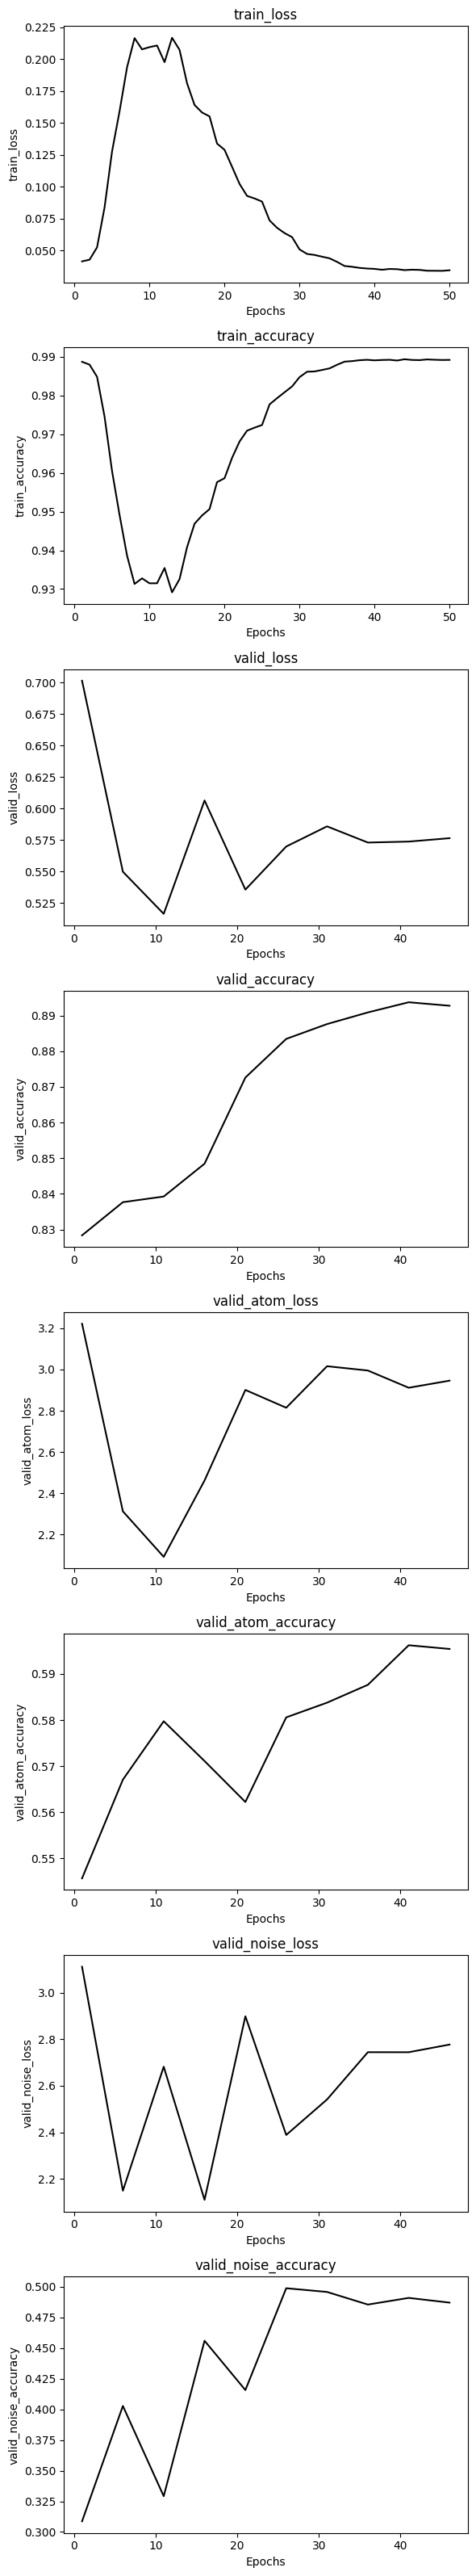

In [ ]:
trainer.plot_training_metrics()

### 500K dataset

524792


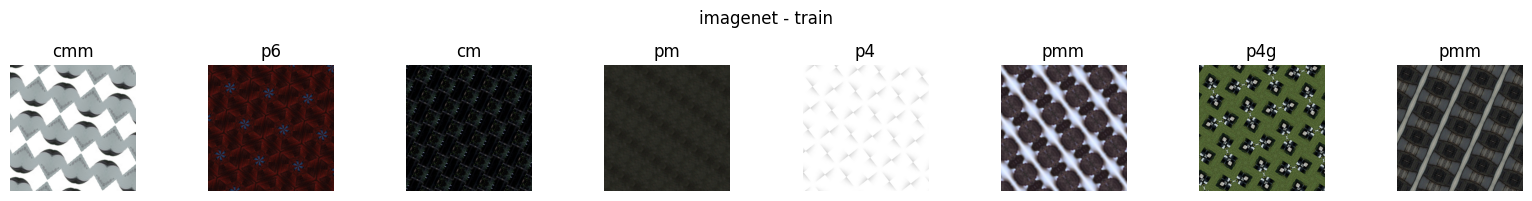

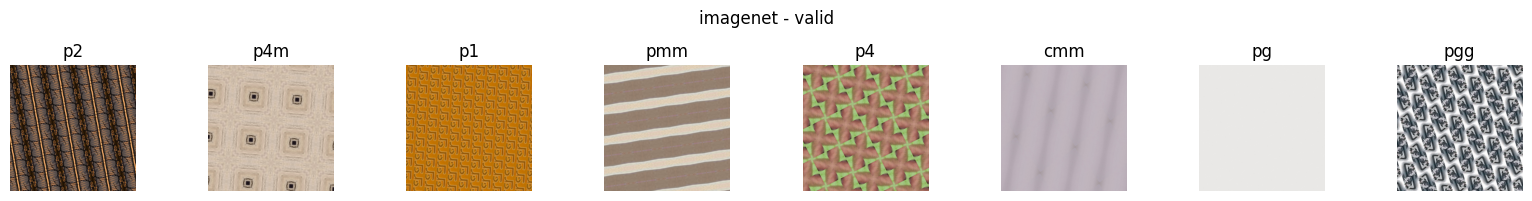

In [ ]:
# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
_, imagenet_ds = split_train_valid(imagenet_ds, 0.951, seed=42) # model can't process single image batch
print(len(imagenet_ds))
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8, seed=42)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)
model.load_state_dict(torch.load('../../saved_models/08282024-resnet50-dataset_v5_size-500k/model_epoch_10.pth'))
model = torch.nn.DataParallel(model, device_ids=[5,6,7,9])
device = torch.device('cuda:5')
# model

torch.Size([2, 17])


In [ ]:
config = {'dataset': '500k datasets',
          'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
          'optimizer': 'Adam',
          'scheduler': 'OneCycleLR'}
NAME = '08282024-resnet50-dataset_v5_size-500k'
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, group='dataset_v5_size', save_code=True, config=config, resume='must')
config = wandb.config

In [ ]:
lr = 1e-3
per_epoch = 5
epoch_start = 0
epochs = 100
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=None)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 1/100


100%|██████████| 350/350 [06:31<00:00,  1.12s/it]


train_loss: 2.9553, train_accuracy: 6.97%
Epoch 2/100


100%|██████████| 350/350 [06:35<00:00,  1.13s/it]


train_loss: 2.8429, train_accuracy: 8.08%
Epoch 3/100


100%|██████████| 350/350 [06:36<00:00,  1.13s/it]


train_loss: 2.7142, train_accuracy: 10.80%
Epoch 4/100


100%|██████████| 350/350 [06:34<00:00,  1.13s/it]


train_loss: 2.1714, train_accuracy: 25.91%
Epoch 5/100


100%|██████████| 350/350 [06:36<00:00,  1.13s/it]


train_loss: 1.3821, train_accuracy: 50.03%


100%|██████████| 88/88 [00:54<00:00,  1.61it/s]


valid_loss: 1.1169, valid_accuracy: 60.00%


100%|██████████| 170/170 [01:43<00:00,  1.65it/s]


valid_atom_loss: 1.6115, valid_atom_accuracy: 45.15%


100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


valid_noise_loss: 3.1092, valid_noise_accuracy: 9.66%
Model saved at epoch 5
Epoch 6/100


100%|██████████| 350/350 [06:30<00:00,  1.12s/it]


train_loss: 0.9870, train_accuracy: 64.49%
Epoch 7/100


100%|██████████| 350/350 [06:33<00:00,  1.13s/it]


train_loss: 0.7422, train_accuracy: 73.64%
Epoch 8/100


100%|██████████| 350/350 [06:34<00:00,  1.13s/it]


train_loss: 0.6064, train_accuracy: 78.47%
Epoch 9/100


100%|██████████| 350/350 [06:33<00:00,  1.12s/it]


train_loss: 0.5153, train_accuracy: 81.83%
Epoch 10/100


100%|██████████| 350/350 [06:34<00:00,  1.13s/it]


train_loss: 0.4346, train_accuracy: 84.97%


100%|██████████| 88/88 [00:54<00:00,  1.60it/s]


valid_loss: 0.5658, valid_accuracy: 79.53%


100%|██████████| 170/170 [01:44<00:00,  1.63it/s]


valid_atom_loss: 1.2995, valid_atom_accuracy: 60.56%


100%|██████████| 85/85 [00:53<00:00,  1.60it/s]


valid_noise_loss: 3.0156, valid_noise_accuracy: 19.21%
Model saved at epoch 10
Epoch 11/100


100%|██████████| 350/350 [06:33<00:00,  1.12s/it]


train_loss: 0.3655, train_accuracy: 87.62%
Epoch 12/100


100%|██████████| 350/350 [06:34<00:00,  1.13s/it]


train_loss: 0.3170, train_accuracy: 89.30%
Epoch 13/100


 11%|█▏        | 40/350 [00:48<06:16,  1.21s/it]


KeyboardInterrupt: 

In [ ]:
lr = 1e-3
per_epoch = 5
epoch_start = 10
epochs = 40
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=5)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 11/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.3015, train_accuracy: 90.02%
Epoch 12/50


100%|██████████| 168/168 [04:38<00:00,  1.66s/it]


train_loss: 0.2600, train_accuracy: 91.49%
Epoch 13/50


100%|██████████| 168/168 [04:31<00:00,  1.61s/it]


train_loss: 0.2531, train_accuracy: 91.60%
Epoch 14/50


100%|██████████| 168/168 [04:38<00:00,  1.66s/it]


train_loss: 0.2648, train_accuracy: 91.09%
Epoch 15/50


100%|██████████| 168/168 [04:26<00:00,  1.59s/it]


train_loss: 0.2719, train_accuracy: 90.83%


100%|██████████| 42/42 [00:48<00:00,  1.15s/it]


valid_loss: 0.4008, valid_accuracy: 86.18%


100%|██████████| 82/82 [01:29<00:00,  1.09s/it]


valid_atom_loss: 1.2540, valid_atom_accuracy: 66.91%


100%|██████████| 41/41 [00:44<00:00,  1.08s/it]


valid_noise_loss: 2.6253, valid_noise_accuracy: 24.17%
Model saved at epoch 15
Epoch 16/50


100%|██████████| 168/168 [04:40<00:00,  1.67s/it]


train_loss: 0.2644, train_accuracy: 91.18%
Epoch 17/50


100%|██████████| 168/168 [04:36<00:00,  1.65s/it]


train_loss: 0.2542, train_accuracy: 91.56%
Epoch 18/50


100%|██████████| 168/168 [04:25<00:00,  1.58s/it]


train_loss: 0.2323, train_accuracy: 92.35%
Epoch 19/50


100%|██████████| 168/168 [04:34<00:00,  1.63s/it]


train_loss: 0.2134, train_accuracy: 93.04%
Epoch 20/50


100%|██████████| 168/168 [04:32<00:00,  1.62s/it]


train_loss: 0.1948, train_accuracy: 93.75%


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


valid_loss: 0.3073, valid_accuracy: 89.53%


100%|██████████| 82/82 [01:31<00:00,  1.12s/it]


valid_atom_loss: 1.3346, valid_atom_accuracy: 66.90%


100%|██████████| 41/41 [00:46<00:00,  1.13s/it]


valid_noise_loss: 1.6559, valid_noise_accuracy: 48.98%
Model saved at epoch 20
Epoch 21/50


100%|██████████| 168/168 [04:32<00:00,  1.62s/it]


train_loss: 0.1771, train_accuracy: 94.37%
Epoch 22/50


100%|██████████| 168/168 [04:17<00:00,  1.53s/it]


train_loss: 0.1604, train_accuracy: 94.95%
Epoch 23/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.1465, train_accuracy: 95.38%
Epoch 24/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.1269, train_accuracy: 96.07%
Epoch 25/50


100%|██████████| 168/168 [04:23<00:00,  1.57s/it]


train_loss: 0.1206, train_accuracy: 96.25%


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


valid_loss: 0.1897, valid_accuracy: 93.82%


100%|██████████| 82/82 [01:33<00:00,  1.14s/it]


valid_atom_loss: 1.1363, valid_atom_accuracy: 73.00%


100%|██████████| 41/41 [00:47<00:00,  1.17s/it]


valid_noise_loss: 1.3835, valid_noise_accuracy: 58.94%
Model saved at epoch 25
Epoch 26/50


100%|██████████| 168/168 [04:35<00:00,  1.64s/it]


train_loss: 0.1080, train_accuracy: 96.64%
Epoch 27/50


100%|██████████| 168/168 [04:37<00:00,  1.65s/it]


train_loss: 0.1021, train_accuracy: 96.85%
Epoch 28/50


100%|██████████| 168/168 [04:37<00:00,  1.65s/it]


train_loss: 0.0922, train_accuracy: 97.16%
Epoch 29/50


100%|██████████| 168/168 [04:22<00:00,  1.57s/it]


train_loss: 0.0871, train_accuracy: 97.32%
Epoch 30/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.0807, train_accuracy: 97.52%


100%|██████████| 42/42 [00:46<00:00,  1.10s/it]


valid_loss: 0.1584, valid_accuracy: 95.60%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 1.4175, valid_atom_accuracy: 71.74%


100%|██████████| 41/41 [00:45<00:00,  1.10s/it]


valid_noise_loss: 1.4072, valid_noise_accuracy: 64.12%
Model saved at epoch 30
Epoch 31/50


100%|██████████| 168/168 [04:16<00:00,  1.53s/it]


train_loss: 0.0744, train_accuracy: 97.70%
Epoch 32/50


100%|██████████| 168/168 [04:21<00:00,  1.56s/it]


train_loss: 0.0703, train_accuracy: 97.83%
Epoch 33/50


100%|██████████| 168/168 [04:19<00:00,  1.54s/it]


train_loss: 0.0621, train_accuracy: 98.07%
Epoch 34/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.0593, train_accuracy: 98.14%
Epoch 35/50


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0551, train_accuracy: 98.27%


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


valid_loss: 0.1558, valid_accuracy: 96.14%


100%|██████████| 82/82 [01:24<00:00,  1.04s/it]


valid_atom_loss: 1.9099, valid_atom_accuracy: 67.59%


100%|██████████| 41/41 [00:45<00:00,  1.11s/it]


valid_noise_loss: 1.4006, valid_noise_accuracy: 68.62%
Model saved at epoch 35
Epoch 36/50


100%|██████████| 168/168 [04:22<00:00,  1.57s/it]


train_loss: 0.0522, train_accuracy: 98.35%
Epoch 37/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.0484, train_accuracy: 98.46%
Epoch 38/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.0451, train_accuracy: 98.56%
Epoch 39/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.0416, train_accuracy: 98.67%
Epoch 40/50


100%|██████████| 168/168 [04:23<00:00,  1.57s/it]


train_loss: 0.0389, train_accuracy: 98.75%


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


valid_loss: 0.1530, valid_accuracy: 96.62%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 2.1860, valid_atom_accuracy: 68.75%


100%|██████████| 41/41 [00:45<00:00,  1.11s/it]


valid_noise_loss: 1.1412, valid_noise_accuracy: 74.40%
Model saved at epoch 40
Epoch 41/50


100%|██████████| 168/168 [04:24<00:00,  1.57s/it]


train_loss: 0.0373, train_accuracy: 98.81%
Epoch 42/50


100%|██████████| 168/168 [04:23<00:00,  1.57s/it]


train_loss: 0.0374, train_accuracy: 98.81%
Epoch 43/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.0360, train_accuracy: 98.85%
Epoch 44/50


100%|██████████| 168/168 [04:24<00:00,  1.58s/it]


train_loss: 0.0352, train_accuracy: 98.88%
Epoch 45/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.0349, train_accuracy: 98.88%


100%|██████████| 42/42 [00:46<00:00,  1.11s/it]


valid_loss: 0.1497, valid_accuracy: 96.88%


100%|██████████| 82/82 [01:25<00:00,  1.05s/it]


valid_atom_loss: 2.2369, valid_atom_accuracy: 69.40%


100%|██████████| 41/41 [00:45<00:00,  1.12s/it]


valid_noise_loss: 1.2122, valid_noise_accuracy: 74.75%
Model saved at epoch 45
Epoch 46/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.0349, train_accuracy: 98.89%
Epoch 47/50


100%|██████████| 168/168 [04:24<00:00,  1.57s/it]


train_loss: 0.0346, train_accuracy: 98.89%
Epoch 48/50


100%|██████████| 168/168 [04:22<00:00,  1.56s/it]


train_loss: 0.0343, train_accuracy: 98.89%
Epoch 49/50


100%|██████████| 168/168 [04:21<00:00,  1.55s/it]


train_loss: 0.0343, train_accuracy: 98.90%
Epoch 50/50


100%|██████████| 168/168 [04:23<00:00,  1.57s/it]


train_loss: 0.0343, train_accuracy: 98.89%


100%|██████████| 42/42 [00:46<00:00,  1.11s/it]


valid_loss: 0.1489, valid_accuracy: 96.91%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 2.1520, valid_atom_accuracy: 70.07%


100%|██████████| 41/41 [00:45<00:00,  1.12s/it]


valid_noise_loss: 1.1617, valid_noise_accuracy: 75.50%
Model saved at epoch 50


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [ ]:
lr = 1e-3
per_epoch = 5
epoch_start = 50
epochs = 30
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=5)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 51/80


100%|██████████| 168/168 [04:21<00:00,  1.55s/it]


train_loss: 0.0353, train_accuracy: 98.86%
Epoch 52/80


100%|██████████| 168/168 [04:19<00:00,  1.55s/it]


train_loss: 0.0380, train_accuracy: 98.77%
Epoch 53/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0462, train_accuracy: 98.54%
Epoch 54/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0573, train_accuracy: 98.18%
Epoch 55/80


100%|██████████| 168/168 [04:21<00:00,  1.55s/it]


train_loss: 0.0711, train_accuracy: 97.75%


100%|██████████| 42/42 [00:46<00:00,  1.10s/it]


valid_loss: 0.2111, valid_accuracy: 94.47%


100%|██████████| 82/82 [01:24<00:00,  1.03s/it]


valid_atom_loss: 1.8531, valid_atom_accuracy: 66.62%


100%|██████████| 41/41 [00:44<00:00,  1.10s/it]


valid_noise_loss: 1.3861, valid_noise_accuracy: 66.46%
Model saved at epoch 55
Epoch 56/80


100%|██████████| 168/168 [04:19<00:00,  1.55s/it]


train_loss: 0.0789, train_accuracy: 97.52%
Epoch 57/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0811, train_accuracy: 97.46%
Epoch 58/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0825, train_accuracy: 97.39%
Epoch 59/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0773, train_accuracy: 97.55%
Epoch 60/80


100%|██████████| 168/168 [04:21<00:00,  1.55s/it]


train_loss: 0.0697, train_accuracy: 97.78%


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


valid_loss: 0.1831, valid_accuracy: 95.43%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 2.4577, valid_atom_accuracy: 63.06%


100%|██████████| 41/41 [00:44<00:00,  1.09s/it]


valid_noise_loss: 0.8763, valid_noise_accuracy: 76.88%
Model saved at epoch 60
Epoch 61/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0685, train_accuracy: 97.85%
Epoch 62/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0622, train_accuracy: 98.01%
Epoch 63/80


100%|██████████| 168/168 [04:21<00:00,  1.56s/it]


train_loss: 0.0596, train_accuracy: 98.09%
Epoch 64/80


100%|██████████| 168/168 [04:21<00:00,  1.56s/it]


train_loss: 0.0533, train_accuracy: 98.29%
Epoch 65/80


100%|██████████| 168/168 [04:18<00:00,  1.54s/it]


train_loss: 0.0531, train_accuracy: 98.29%


100%|██████████| 42/42 [00:46<00:00,  1.10s/it]


valid_loss: 0.1620, valid_accuracy: 96.03%


100%|██████████| 82/82 [01:24<00:00,  1.03s/it]


valid_atom_loss: 2.4083, valid_atom_accuracy: 65.43%


100%|██████████| 41/41 [00:44<00:00,  1.08s/it]


valid_noise_loss: 0.9481, valid_noise_accuracy: 77.84%
Model saved at epoch 65
Epoch 66/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0505, train_accuracy: 98.39%
Epoch 67/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0455, train_accuracy: 98.52%
Epoch 68/80


100%|██████████| 168/168 [04:21<00:00,  1.56s/it]


train_loss: 0.0415, train_accuracy: 98.65%
Epoch 69/80


100%|██████████| 168/168 [04:21<00:00,  1.56s/it]


train_loss: 0.0405, train_accuracy: 98.68%
Epoch 70/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0383, train_accuracy: 98.75%


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


valid_loss: 0.1462, valid_accuracy: 96.82%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 2.0377, valid_atom_accuracy: 71.58%


100%|██████████| 41/41 [00:45<00:00,  1.10s/it]


valid_noise_loss: 0.9212, valid_noise_accuracy: 80.23%
Model saved at epoch 70
Epoch 71/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0362, train_accuracy: 98.83%
Epoch 72/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0353, train_accuracy: 98.84%
Epoch 73/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0347, train_accuracy: 98.86%
Epoch 74/80


100%|██████████| 168/168 [04:21<00:00,  1.56s/it]


train_loss: 0.0339, train_accuracy: 98.88%
Epoch 75/80


100%|██████████| 168/168 [04:19<00:00,  1.55s/it]


train_loss: 0.0337, train_accuracy: 98.89%


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


valid_loss: 0.1394, valid_accuracy: 97.12%


100%|██████████| 82/82 [01:24<00:00,  1.03s/it]


valid_atom_loss: 2.1237, valid_atom_accuracy: 72.01%


100%|██████████| 41/41 [00:44<00:00,  1.09s/it]


valid_noise_loss: 0.9351, valid_noise_accuracy: 80.92%
Model saved at epoch 75
Epoch 76/80


100%|██████████| 168/168 [04:19<00:00,  1.55s/it]


train_loss: 0.0333, train_accuracy: 98.89%
Epoch 77/80


100%|██████████| 168/168 [04:21<00:00,  1.56s/it]


train_loss: 0.0331, train_accuracy: 98.89%
Epoch 78/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0330, train_accuracy: 98.90%
Epoch 79/80


100%|██████████| 168/168 [04:20<00:00,  1.55s/it]


train_loss: 0.0329, train_accuracy: 98.90%
Epoch 80/80


100%|██████████| 168/168 [04:21<00:00,  1.56s/it]


train_loss: 0.0331, train_accuracy: 98.90%


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


valid_loss: 0.1412, valid_accuracy: 97.13%


100%|██████████| 82/82 [01:23<00:00,  1.02s/it]


valid_atom_loss: 2.1351, valid_atom_accuracy: 72.47%


100%|██████████| 41/41 [00:44<00:00,  1.08s/it]


valid_noise_loss: 0.9313, valid_noise_accuracy: 81.10%
Model saved at epoch 80


wandb: WARNING Ensure read and write access to run files dir: /home/yichen/Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/notebooks/various_dataset_size/wandb/run-20240830_052316-08282024-resnet50-dataset_v5_size-500k/files, control this via the WANDB_DIR env var. See https://docs.wandb.ai/guides/track/environment-variables


### 1 million dataset

1071004


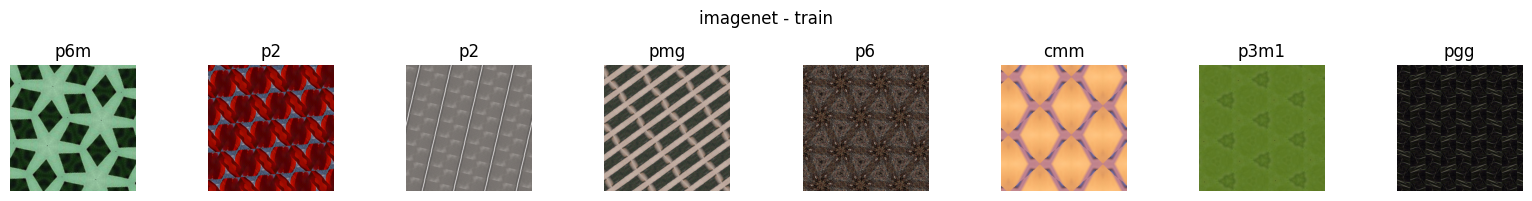

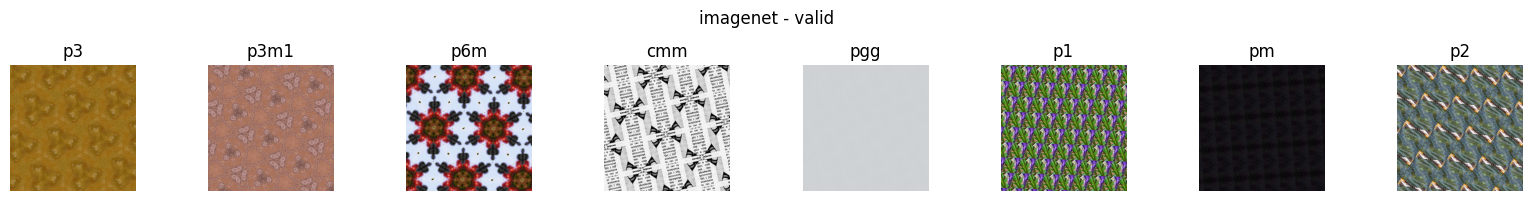

In [ ]:
# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
_, imagenet_ds = split_train_valid(imagenet_ds, 0.9, seed=42)
print(len(imagenet_ds))
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8, seed=42)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)
model = torch.nn.DataParallel(model, device_ids=[5,6,7,9])
device = torch.device('cuda:5')
# model

torch.Size([2, 17])


In [ ]:
config = {'dataset': '1m datasets',
          'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
          'optimizer': 'Adam',
          'scheduler': 'OneCycleLR'}
NAME = '08282024-resnet50-dataset_v5_size-1m'
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, group='dataset_v5_size', save_code=True, config=config)
config = wandb.config

In [ ]:
lr = 1e-3
per_epoch = 5
epoch_start = 0
epochs = 50
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=None)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 1/50


100%|██████████| 343/343 [09:08<00:00,  1.60s/it]


train_loss: 2.9565, train_accuracy: 6.78%
Epoch 2/50


100%|██████████| 343/343 [08:51<00:00,  1.55s/it]


train_loss: 2.8325, train_accuracy: 8.40%
Epoch 3/50


100%|██████████| 343/343 [09:03<00:00,  1.58s/it]


train_loss: 2.3080, train_accuracy: 22.23%
Epoch 4/50


100%|██████████| 343/343 [09:02<00:00,  1.58s/it]


train_loss: 1.1815, train_accuracy: 57.68%
Epoch 5/50


100%|██████████| 343/343 [08:41<00:00,  1.52s/it]


train_loss: 0.7301, train_accuracy: 73.92%


100%|██████████| 86/86 [01:29<00:00,  1.04s/it]


valid_loss: 0.5583, valid_accuracy: 78.88%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 1.1700, valid_atom_accuracy: 58.30%


100%|██████████| 41/41 [00:45<00:00,  1.10s/it]


valid_noise_loss: 2.9356, valid_noise_accuracy: 11.74%
Model saved at epoch 5
Epoch 6/50


100%|██████████| 343/343 [08:59<00:00,  1.57s/it]


train_loss: 0.5149, train_accuracy: 81.98%
Epoch 7/50


100%|██████████| 343/343 [09:00<00:00,  1.58s/it]


train_loss: 0.3643, train_accuracy: 87.88%
Epoch 8/50


100%|██████████| 343/343 [09:02<00:00,  1.58s/it]


train_loss: 0.2789, train_accuracy: 90.89%
Epoch 9/50


100%|██████████| 343/343 [08:51<00:00,  1.55s/it]


train_loss: 0.2300, train_accuracy: 92.60%
Epoch 10/50


100%|██████████| 343/343 [08:53<00:00,  1.56s/it]


train_loss: 0.1957, train_accuracy: 93.78%


100%|██████████| 86/86 [01:31<00:00,  1.06s/it]


valid_loss: 0.2431, valid_accuracy: 92.11%


100%|██████████| 82/82 [01:27<00:00,  1.07s/it]


valid_atom_loss: 1.6874, valid_atom_accuracy: 60.74%


100%|██████████| 41/41 [00:45<00:00,  1.11s/it]


valid_noise_loss: 2.2300, valid_noise_accuracy: 36.26%
Model saved at epoch 10
Epoch 11/50


100%|██████████| 343/343 [08:55<00:00,  1.56s/it]


train_loss: 0.1715, train_accuracy: 94.67%
Epoch 12/50


100%|██████████| 343/343 [08:53<00:00,  1.56s/it]


train_loss: 0.1518, train_accuracy: 95.34%
Epoch 13/50


100%|██████████| 343/343 [08:56<00:00,  1.56s/it]


train_loss: 0.1358, train_accuracy: 95.87%
Epoch 14/50


100%|██████████| 343/343 [08:46<00:00,  1.54s/it]


train_loss: 0.1226, train_accuracy: 96.32%
Epoch 15/50


100%|██████████| 343/343 [08:45<00:00,  1.53s/it]


train_loss: 0.1106, train_accuracy: 96.67%


100%|██████████| 86/86 [01:28<00:00,  1.03s/it]


valid_loss: 0.1329, valid_accuracy: 95.81%


100%|██████████| 82/82 [01:24<00:00,  1.03s/it]


valid_atom_loss: 1.4760, valid_atom_accuracy: 69.96%


100%|██████████| 41/41 [00:44<00:00,  1.08s/it]


valid_noise_loss: 1.2758, valid_noise_accuracy: 59.99%
Model saved at epoch 15
Epoch 16/50


100%|██████████| 343/343 [08:43<00:00,  1.53s/it]


train_loss: 0.1042, train_accuracy: 96.87%
Epoch 17/50


100%|██████████| 343/343 [08:45<00:00,  1.53s/it]


train_loss: 0.0973, train_accuracy: 97.10%
Epoch 18/50


100%|██████████| 343/343 [08:44<00:00,  1.53s/it]


train_loss: 0.0915, train_accuracy: 97.26%
Epoch 19/50


100%|██████████| 343/343 [08:44<00:00,  1.53s/it]


train_loss: 0.0862, train_accuracy: 97.41%
Epoch 20/50


100%|██████████| 343/343 [08:46<00:00,  1.53s/it]


train_loss: 0.0842, train_accuracy: 97.46%


100%|██████████| 86/86 [01:27<00:00,  1.02s/it]


valid_loss: 0.1075, valid_accuracy: 96.73%


100%|██████████| 82/82 [01:24<00:00,  1.03s/it]


valid_atom_loss: 1.0891, valid_atom_accuracy: 77.04%


100%|██████████| 41/41 [00:44<00:00,  1.08s/it]


valid_noise_loss: 0.8550, valid_noise_accuracy: 74.95%
Model saved at epoch 20
Epoch 21/50


100%|██████████| 343/343 [08:44<00:00,  1.53s/it]


train_loss: 0.0795, train_accuracy: 97.60%
Epoch 22/50


100%|██████████| 343/343 [08:44<00:00,  1.53s/it]


train_loss: 0.0754, train_accuracy: 97.71%
Epoch 23/50


100%|██████████| 343/343 [08:44<00:00,  1.53s/it]


train_loss: 0.0718, train_accuracy: 97.80%
Epoch 24/50


100%|██████████| 343/343 [08:50<00:00,  1.55s/it]


train_loss: 0.0699, train_accuracy: 97.87%
Epoch 25/50


100%|██████████| 343/343 [08:44<00:00,  1.53s/it]


train_loss: 0.0661, train_accuracy: 97.96%


100%|██████████| 86/86 [01:27<00:00,  1.02s/it]


valid_loss: 0.0988, valid_accuracy: 97.09%


100%|██████████| 82/82 [01:24<00:00,  1.03s/it]


valid_atom_loss: 1.5648, valid_atom_accuracy: 73.25%


100%|██████████| 41/41 [00:44<00:00,  1.08s/it]


valid_noise_loss: 0.7285, valid_noise_accuracy: 79.21%
Model saved at epoch 25
Epoch 26/50


100%|██████████| 343/343 [08:45<00:00,  1.53s/it]


train_loss: 0.0634, train_accuracy: 98.04%
Epoch 27/50


100%|██████████| 343/343 [08:46<00:00,  1.53s/it]


train_loss: 0.0607, train_accuracy: 98.10%
Epoch 28/50


100%|██████████| 343/343 [08:45<00:00,  1.53s/it]


train_loss: 0.0583, train_accuracy: 98.17%
Epoch 29/50


100%|██████████| 343/343 [08:45<00:00,  1.53s/it]


train_loss: 0.0552, train_accuracy: 98.25%
Epoch 30/50


100%|██████████| 343/343 [08:46<00:00,  1.53s/it]


train_loss: 0.0519, train_accuracy: 98.34%


100%|██████████| 86/86 [01:29<00:00,  1.04s/it]


valid_loss: 0.0973, valid_accuracy: 97.36%


100%|██████████| 82/82 [01:25<00:00,  1.05s/it]


valid_atom_loss: 1.3856, valid_atom_accuracy: 77.16%


100%|██████████| 41/41 [00:48<00:00,  1.18s/it]


valid_noise_loss: 0.6289, valid_noise_accuracy: 84.67%
Model saved at epoch 30
Epoch 31/50


100%|██████████| 343/343 [09:13<00:00,  1.61s/it]


train_loss: 0.0485, train_accuracy: 98.44%
Epoch 32/50


100%|██████████| 343/343 [08:48<00:00,  1.54s/it]


train_loss: 0.0473, train_accuracy: 98.47%
Epoch 33/50


100%|██████████| 343/343 [08:27<00:00,  1.48s/it]


train_loss: 0.0450, train_accuracy: 98.53%
Epoch 34/50


100%|██████████| 343/343 [08:28<00:00,  1.48s/it]


train_loss: 0.0425, train_accuracy: 98.60%
Epoch 35/50


100%|██████████| 343/343 [08:27<00:00,  1.48s/it]


train_loss: 0.0407, train_accuracy: 98.65%


100%|██████████| 86/86 [01:24<00:00,  1.02it/s]


valid_loss: 0.0968, valid_accuracy: 97.56%


100%|██████████| 82/82 [01:20<00:00,  1.02it/s]


valid_atom_loss: 1.8179, valid_atom_accuracy: 74.07%


100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


valid_noise_loss: 0.6438, valid_noise_accuracy: 84.28%
Model saved at epoch 35
Epoch 36/50


100%|██████████| 343/343 [08:26<00:00,  1.48s/it]


train_loss: 0.0397, train_accuracy: 98.69%
Epoch 37/50


100%|██████████| 343/343 [08:27<00:00,  1.48s/it]


train_loss: 0.0375, train_accuracy: 98.74%
Epoch 38/50


100%|██████████| 343/343 [08:27<00:00,  1.48s/it]


train_loss: 0.0370, train_accuracy: 98.75%
Epoch 39/50


100%|██████████| 343/343 [08:29<00:00,  1.49s/it]


train_loss: 0.0364, train_accuracy: 98.78%
Epoch 40/50


100%|██████████| 343/343 [08:27<00:00,  1.48s/it]


train_loss: 0.0347, train_accuracy: 98.83%


100%|██████████| 86/86 [01:24<00:00,  1.02it/s]


valid_loss: 0.0967, valid_accuracy: 97.76%


100%|██████████| 82/82 [01:20<00:00,  1.02it/s]


valid_atom_loss: 1.7724, valid_atom_accuracy: 76.96%


100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


valid_noise_loss: 0.6352, valid_noise_accuracy: 87.18%
Model saved at epoch 40
Epoch 41/50


100%|██████████| 343/343 [08:26<00:00,  1.48s/it]


train_loss: 0.0344, train_accuracy: 98.84%
Epoch 42/50


100%|██████████| 343/343 [08:27<00:00,  1.48s/it]


train_loss: 0.0338, train_accuracy: 98.86%
Epoch 43/50


100%|██████████| 343/343 [08:27<00:00,  1.48s/it]


train_loss: 0.0334, train_accuracy: 98.87%
Epoch 44/50


100%|██████████| 343/343 [08:28<00:00,  1.48s/it]


train_loss: 0.0332, train_accuracy: 98.88%
Epoch 45/50


100%|██████████| 343/343 [08:27<00:00,  1.48s/it]


train_loss: 0.0330, train_accuracy: 98.88%


100%|██████████| 86/86 [01:24<00:00,  1.02it/s]


valid_loss: 0.1001, valid_accuracy: 97.83%


100%|██████████| 82/82 [01:20<00:00,  1.02it/s]


valid_atom_loss: 1.7727, valid_atom_accuracy: 78.41%


100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


valid_noise_loss: 0.6226, valid_noise_accuracy: 87.64%
Model saved at epoch 45
Epoch 46/50


100%|██████████| 343/343 [08:28<00:00,  1.48s/it]


train_loss: 0.0329, train_accuracy: 98.89%
Epoch 47/50


100%|██████████| 343/343 [08:27<00:00,  1.48s/it]


train_loss: 0.0329, train_accuracy: 98.89%
Epoch 48/50


100%|██████████| 343/343 [08:28<00:00,  1.48s/it]


train_loss: 0.0327, train_accuracy: 98.89%
Epoch 49/50


100%|██████████| 343/343 [08:29<00:00,  1.48s/it]


train_loss: 0.0326, train_accuracy: 98.90%
Epoch 50/50


100%|██████████| 343/343 [08:28<00:00,  1.48s/it]


train_loss: 0.0326, train_accuracy: 98.90%


100%|██████████| 86/86 [01:24<00:00,  1.02it/s]


valid_loss: 0.1024, valid_accuracy: 97.84%


100%|██████████| 82/82 [01:20<00:00,  1.02it/s]


valid_atom_loss: 1.7852, valid_atom_accuracy: 78.65%


100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


valid_noise_loss: 0.6330, valid_noise_accuracy: 87.58%
Model saved at epoch 50


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


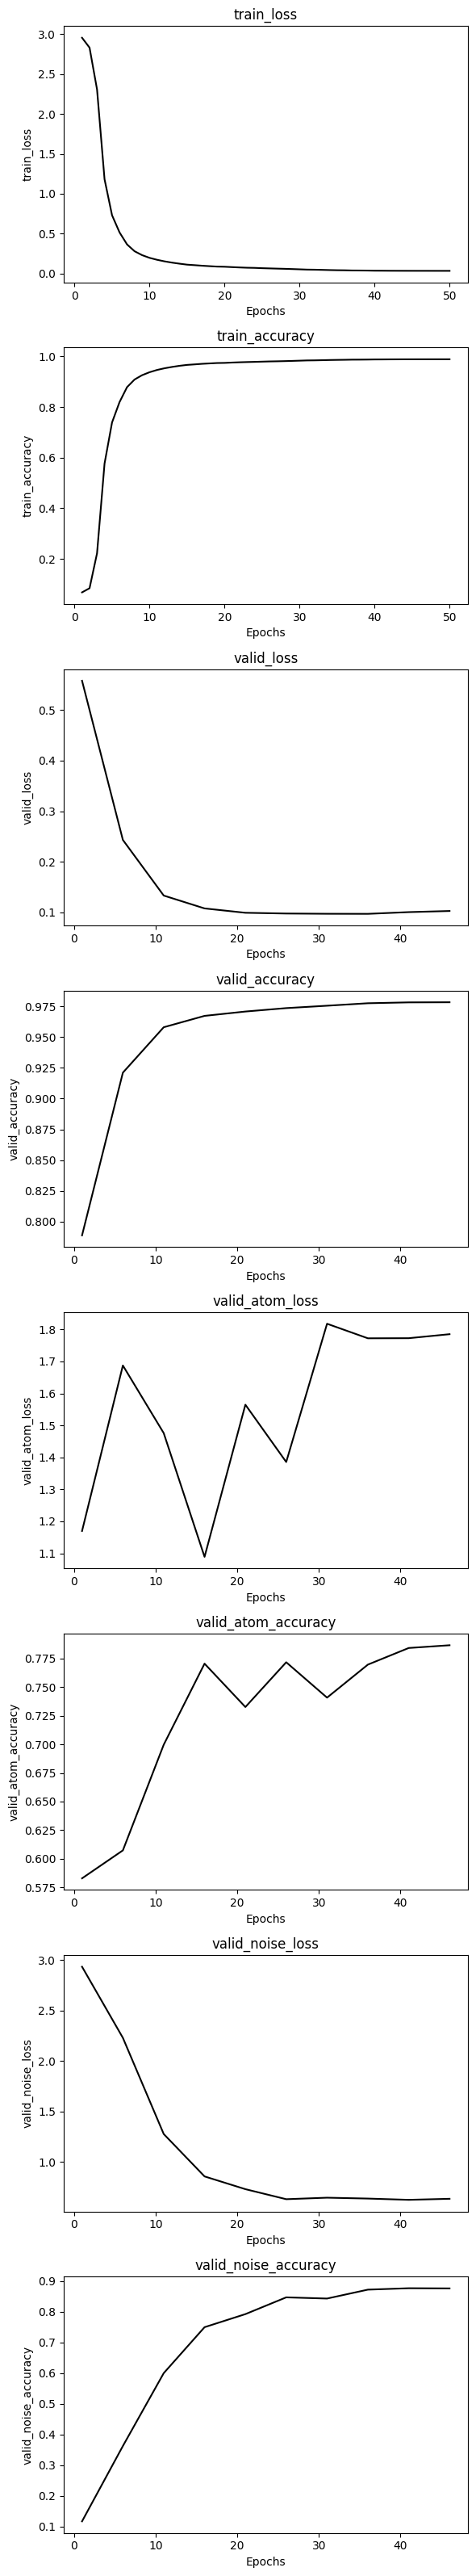

In [ ]:
trainer.plot_training_metrics()

### 2 million dataset

2142007


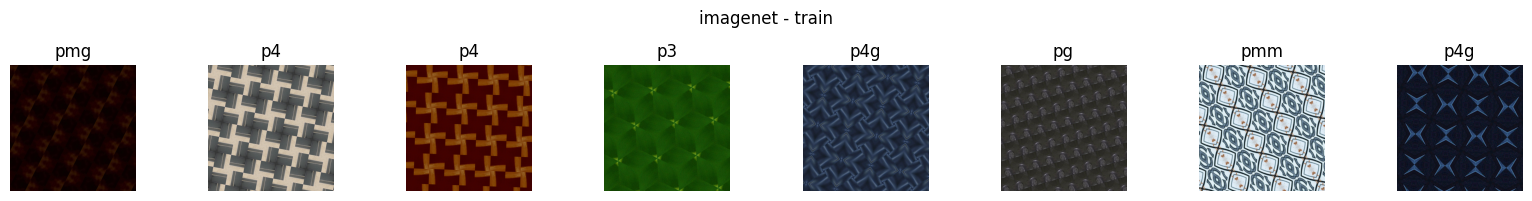

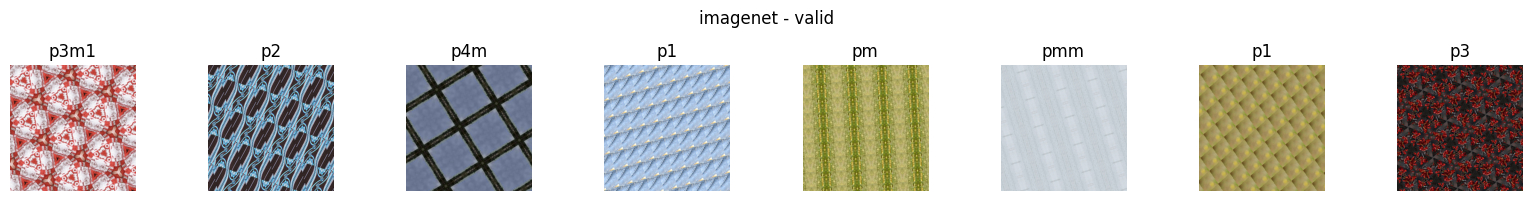

In [ ]:
# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
_, imagenet_ds = split_train_valid(imagenet_ds, 0.8, seed=42)
print(len(imagenet_ds))
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8, seed=42)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=8)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=8)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)
model = torch.nn.DataParallel(model, device_ids=[5,6,7,9])
device = torch.device('cuda:5')
# model

torch.Size([2, 17])


In [ ]:
config = {'dataset': '2m datasets',
          'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
          'optimizer': 'Adam',
          'scheduler': 'OneCycleLR'}
NAME = '08282024-resnet50-dataset_v5_size-2m'
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, group='dataset_v5_size', save_code=True, config=config)
config = wandb.config

In [ ]:
lr = 1e-3
per_epoch = 2
epoch_start = 0
epochs = 50
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=5)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 1/50


100%|██████████| 686/686 [18:20<00:00,  1.60s/it]


train_loss: 2.8528, train_accuracy: 8.60%
Epoch 2/50


100%|██████████| 686/686 [18:27<00:00,  1.61s/it]


train_loss: 1.8607, train_accuracy: 35.64%


100%|██████████| 172/172 [03:07<00:00,  1.09s/it]


valid_loss: 1.0818, valid_accuracy: 62.19%


100%|██████████| 82/82 [01:31<00:00,  1.12s/it]


valid_atom_loss: 1.8567, valid_atom_accuracy: 39.40%


100%|██████████| 41/41 [00:47<00:00,  1.17s/it]


valid_noise_loss: 2.8932, valid_noise_accuracy: 10.15%
Model saved at epoch 2
Epoch 3/50


100%|██████████| 686/686 [18:25<00:00,  1.61s/it]


train_loss: 0.9022, train_accuracy: 68.12%
Epoch 4/50


100%|██████████| 686/686 [18:19<00:00,  1.60s/it]


train_loss: 0.5540, train_accuracy: 80.59%


100%|██████████| 172/172 [03:06<00:00,  1.08s/it]


valid_loss: 0.5603, valid_accuracy: 78.10%


100%|██████████| 82/82 [01:33<00:00,  1.14s/it]


valid_atom_loss: 1.2831, valid_atom_accuracy: 63.32%


100%|██████████| 41/41 [00:46<00:00,  1.12s/it]


valid_noise_loss: 3.6820, valid_noise_accuracy: 15.02%
Model saved at epoch 4
Epoch 5/50


100%|██████████| 686/686 [18:00<00:00,  1.58s/it]


train_loss: 0.3543, train_accuracy: 88.28%
Epoch 6/50


100%|██████████| 686/686 [17:59<00:00,  1.57s/it]


train_loss: 0.2467, train_accuracy: 92.18%


100%|██████████| 172/172 [02:53<00:00,  1.01s/it]


valid_loss: 0.2219, valid_accuracy: 92.75%


100%|██████████| 82/82 [01:27<00:00,  1.07s/it]


valid_atom_loss: 1.2431, valid_atom_accuracy: 73.77%


100%|██████████| 41/41 [00:45<00:00,  1.10s/it]


valid_noise_loss: 2.1451, valid_noise_accuracy: 33.51%
Model saved at epoch 6
Epoch 7/50


100%|██████████| 686/686 [17:56<00:00,  1.57s/it]


train_loss: 0.1870, train_accuracy: 94.25%
Epoch 8/50


100%|██████████| 686/686 [17:59<00:00,  1.57s/it]


train_loss: 0.1551, train_accuracy: 95.34%


100%|██████████| 172/172 [02:57<00:00,  1.03s/it]


valid_loss: 0.1438, valid_accuracy: 95.48%


100%|██████████| 82/82 [01:27<00:00,  1.07s/it]


valid_atom_loss: 1.3468, valid_atom_accuracy: 68.41%


100%|██████████| 41/41 [00:45<00:00,  1.10s/it]


valid_noise_loss: 1.3843, valid_noise_accuracy: 54.16%
Model saved at epoch 8
Epoch 9/50


100%|██████████| 686/686 [17:54<00:00,  1.57s/it]


train_loss: 0.1338, train_accuracy: 96.04%
Epoch 10/50


100%|██████████| 686/686 [17:49<00:00,  1.56s/it]


train_loss: 0.1204, train_accuracy: 96.44%


100%|██████████| 172/172 [02:58<00:00,  1.04s/it]


valid_loss: 0.1301, valid_accuracy: 95.85%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 0.9774, valid_atom_accuracy: 74.71%


100%|██████████| 41/41 [00:43<00:00,  1.07s/it]


valid_noise_loss: 0.9963, valid_noise_accuracy: 65.54%
Model saved at epoch 10
Epoch 11/50


100%|██████████| 686/686 [17:56<00:00,  1.57s/it]


train_loss: 0.1125, train_accuracy: 96.68%
Epoch 12/50


100%|██████████| 686/686 [17:43<00:00,  1.55s/it]


train_loss: 0.1034, train_accuracy: 96.94%


100%|██████████| 172/172 [02:53<00:00,  1.01s/it]


valid_loss: 0.1277, valid_accuracy: 96.06%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 1.4214, valid_atom_accuracy: 75.03%


100%|██████████| 41/41 [00:43<00:00,  1.07s/it]


valid_noise_loss: 0.7617, valid_noise_accuracy: 75.48%
Model saved at epoch 12
Epoch 13/50


100%|██████████| 686/686 [17:56<00:00,  1.57s/it]


train_loss: 0.0959, train_accuracy: 97.16%
Epoch 14/50


100%|██████████| 686/686 [17:42<00:00,  1.55s/it]


train_loss: 0.0892, train_accuracy: 97.34%


100%|██████████| 172/172 [02:53<00:00,  1.01s/it]


valid_loss: 0.0927, valid_accuracy: 97.15%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 0.8267, valid_atom_accuracy: 80.53%


100%|██████████| 41/41 [00:44<00:00,  1.08s/it]


valid_noise_loss: 0.4603, valid_noise_accuracy: 84.54%
Model saved at epoch 14
Epoch 15/50


100%|██████████| 686/686 [17:42<00:00,  1.55s/it]


train_loss: 0.0839, train_accuracy: 97.49%
Epoch 16/50


100%|██████████| 686/686 [17:56<00:00,  1.57s/it]


train_loss: 0.0790, train_accuracy: 97.63%


100%|██████████| 172/172 [02:53<00:00,  1.01s/it]


valid_loss: 0.0838, valid_accuracy: 97.42%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 1.0896, valid_atom_accuracy: 76.15%


100%|██████████| 41/41 [00:44<00:00,  1.09s/it]


valid_noise_loss: 0.3976, valid_noise_accuracy: 87.72%
Model saved at epoch 16
Epoch 17/50


100%|██████████| 686/686 [17:55<00:00,  1.57s/it]


train_loss: 0.0754, train_accuracy: 97.73%
Epoch 18/50


100%|██████████| 686/686 [17:41<00:00,  1.55s/it]


train_loss: 0.0721, train_accuracy: 97.82%


100%|██████████| 172/172 [02:56<00:00,  1.03s/it]


valid_loss: 0.0786, valid_accuracy: 97.53%


100%|██████████| 82/82 [01:26<00:00,  1.05s/it]


valid_atom_loss: 1.3341, valid_atom_accuracy: 75.22%


100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


valid_noise_loss: 0.3767, valid_noise_accuracy: 87.78%
Model saved at epoch 18
Epoch 19/50


100%|██████████| 686/686 [17:39<00:00,  1.54s/it]


train_loss: 0.0706, train_accuracy: 97.86%
Epoch 20/50


100%|██████████| 686/686 [17:41<00:00,  1.55s/it]


train_loss: 0.0670, train_accuracy: 97.98%


100%|██████████| 172/172 [02:52<00:00,  1.00s/it]


valid_loss: 0.0709, valid_accuracy: 97.80%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 0.9331, valid_atom_accuracy: 81.62%


100%|██████████| 41/41 [00:43<00:00,  1.07s/it]


valid_noise_loss: 0.2624, valid_noise_accuracy: 91.29%
Model saved at epoch 20
Epoch 21/50


100%|██████████| 686/686 [17:40<00:00,  1.55s/it]


train_loss: 0.0624, train_accuracy: 98.11%
Epoch 22/50


100%|██████████| 686/686 [17:55<00:00,  1.57s/it]


train_loss: 0.0620, train_accuracy: 98.10%


100%|██████████| 172/172 [02:52<00:00,  1.00s/it]


valid_loss: 0.0686, valid_accuracy: 97.87%


100%|██████████| 82/82 [01:25<00:00,  1.04s/it]


valid_atom_loss: 0.9792, valid_atom_accuracy: 83.87%


100%|██████████| 41/41 [00:44<00:00,  1.07s/it]


valid_noise_loss: 0.2466, valid_noise_accuracy: 91.73%
Model saved at epoch 22
Epoch 23/50


100%|██████████| 686/686 [17:53<00:00,  1.57s/it]


train_loss: 0.0587, train_accuracy: 98.20%
Epoch 24/50


100%|██████████| 686/686 [17:41<00:00,  1.55s/it]


train_loss: 0.0567, train_accuracy: 98.25%


100%|██████████| 172/172 [02:53<00:00,  1.01s/it]


valid_loss: 0.0774, valid_accuracy: 97.97%


100%|██████████| 82/82 [01:24<00:00,  1.03s/it]


valid_atom_loss: 1.2834, valid_atom_accuracy: 77.12%


100%|██████████| 41/41 [00:45<00:00,  1.10s/it]


valid_noise_loss: 0.2850, valid_noise_accuracy: 91.75%
Model saved at epoch 24
Epoch 25/50


100%|██████████| 686/686 [17:40<00:00,  1.55s/it]


train_loss: 0.0568, train_accuracy: 98.24%
Epoch 26/50


100%|██████████| 686/686 [17:44<00:00,  1.55s/it]


train_loss: 0.0543, train_accuracy: 98.31%


100%|██████████| 172/172 [03:07<00:00,  1.09s/it]


valid_loss: 0.0818, valid_accuracy: 98.05%


100%|██████████| 82/82 [01:37<00:00,  1.19s/it]


valid_atom_loss: 1.2809, valid_atom_accuracy: 79.81%


100%|██████████| 41/41 [00:47<00:00,  1.16s/it]


valid_noise_loss: 0.2692, valid_noise_accuracy: 91.84%
Model saved at epoch 26
Epoch 27/50


100%|██████████| 686/686 [17:32<00:00,  1.53s/it]


train_loss: 0.0514, train_accuracy: 98.38%
Epoch 28/50


100%|██████████| 686/686 [17:32<00:00,  1.53s/it]


train_loss: 0.0495, train_accuracy: 98.44%


100%|██████████| 172/172 [02:54<00:00,  1.02s/it]


valid_loss: 0.0649, valid_accuracy: 98.13%


100%|██████████| 82/82 [01:23<00:00,  1.02s/it]


valid_atom_loss: 1.3266, valid_atom_accuracy: 79.99%


100%|██████████| 41/41 [00:43<00:00,  1.07s/it]


valid_noise_loss: 0.3683, valid_noise_accuracy: 90.94%
Model saved at epoch 28
Epoch 29/50


100%|██████████| 686/686 [17:50<00:00,  1.56s/it]


train_loss: 0.0478, train_accuracy: 98.47%
Epoch 30/50


100%|██████████| 686/686 [17:50<00:00,  1.56s/it]


train_loss: 0.0467, train_accuracy: 98.49%


100%|██████████| 172/172 [02:51<00:00,  1.00it/s]


valid_loss: 0.0619, valid_accuracy: 98.17%


100%|██████████| 82/82 [01:22<00:00,  1.01s/it]


valid_atom_loss: 1.2068, valid_atom_accuracy: 79.58%


100%|██████████| 41/41 [00:43<00:00,  1.05s/it]


valid_noise_loss: 0.2930, valid_noise_accuracy: 92.12%
Model saved at epoch 30
Epoch 31/50


100%|██████████| 686/686 [17:48<00:00,  1.56s/it]


train_loss: 0.0442, train_accuracy: 98.55%
Epoch 32/50


100%|██████████| 686/686 [17:47<00:00,  1.56s/it]


train_loss: 0.0429, train_accuracy: 98.58%


100%|██████████| 172/172 [02:51<00:00,  1.00it/s]


valid_loss: 0.0645, valid_accuracy: 98.19%


100%|██████████| 82/82 [01:23<00:00,  1.02s/it]


valid_atom_loss: 1.4196, valid_atom_accuracy: 80.86%


100%|██████████| 41/41 [00:42<00:00,  1.04s/it]


valid_noise_loss: 0.3137, valid_noise_accuracy: 92.21%
Model saved at epoch 32
Epoch 33/50


100%|██████████| 686/686 [17:50<00:00,  1.56s/it]


train_loss: 0.0414, train_accuracy: 98.62%
Epoch 34/50


100%|██████████| 686/686 [17:33<00:00,  1.54s/it]


train_loss: 0.0395, train_accuracy: 98.66%


100%|██████████| 172/172 [02:55<00:00,  1.02s/it]


valid_loss: 0.0823, valid_accuracy: 97.46%


100%|██████████| 82/82 [01:24<00:00,  1.03s/it]


valid_atom_loss: 1.6137, valid_atom_accuracy: 79.84%


100%|██████████| 41/41 [00:44<00:00,  1.07s/it]


valid_noise_loss: 0.3734, valid_noise_accuracy: 91.79%
Early stopping triggered.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


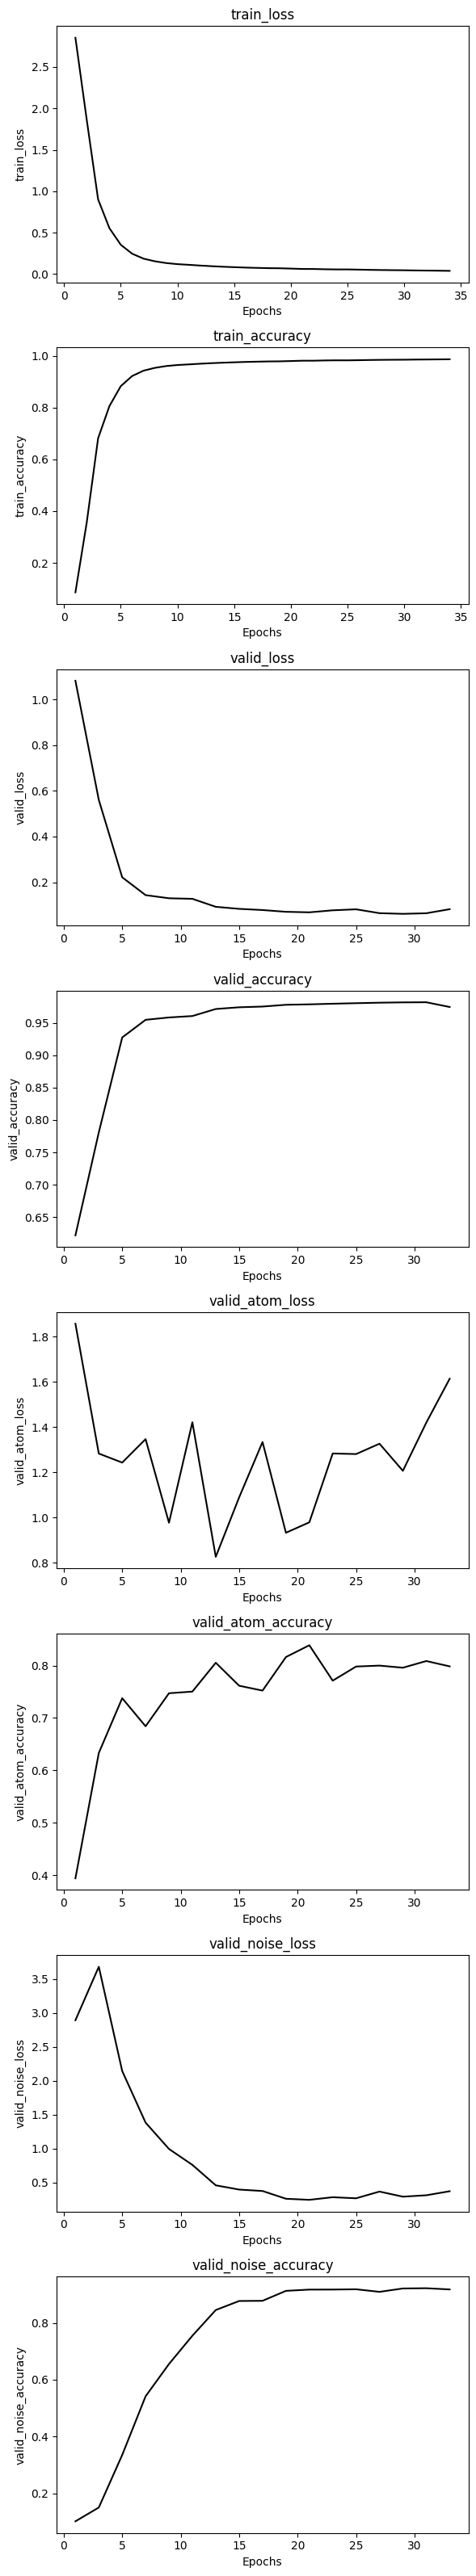

In [ ]:
trainer.plot_training_metrics()

### 5 million dataset

5355017


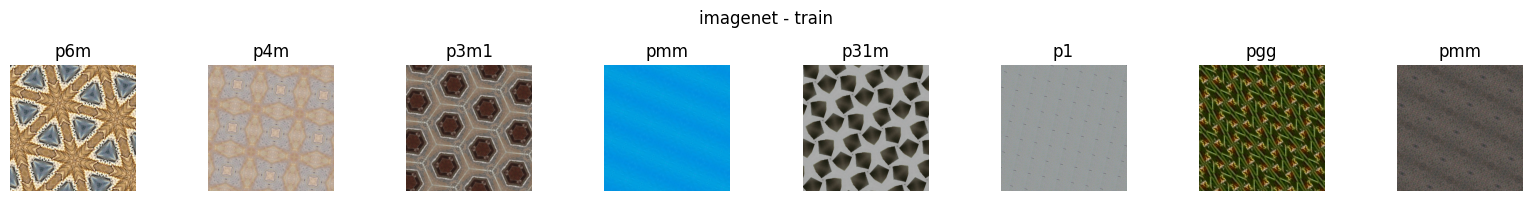

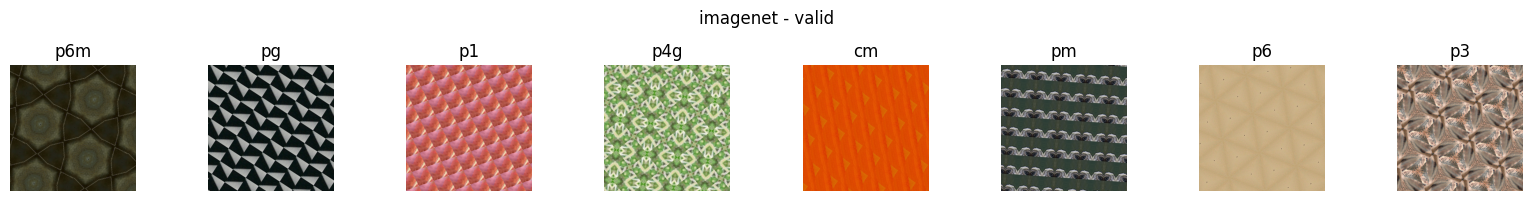

In [ ]:
# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
_, imagenet_ds = split_train_valid(imagenet_ds, 0.5, seed=42)
print(len(imagenet_ds))
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8, seed=42)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=8)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=8)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)
model = torch.nn.DataParallel(model, device_ids=[5,6,7,9])
device = torch.device('cuda:5')
# model

torch.Size([2, 17])


In [ ]:
config = {'dataset': '5m datasets',
          'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
          'optimizer': 'Adam',
          'scheduler': 'OneCycleLR'}
NAME = '08282024-resnet50-dataset_v5_size-5m'
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, group='dataset_v5_size', save_code=True, config=config, resume='must')
config = wandb.config

In [ ]:
lr = 1e-3
per_epoch = 2
epoch_start = 0
epochs = 50
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
metrics = [accuracy]  # You can add more metrics if needed
trainer = Trainer(model=model, loss_func=loss_func, optimizer=optimizer, metrics=metrics, scheduler=scheduler, 
                  device=device, save_per_epochs=per_epoch, model_path=f'../../saved_models/{NAME}/', early_stopping_patience=5)

history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)
wandb.finish()

Epoch 1/50


100%|██████████| 1714/1714 [46:35<00:00,  1.63s/it]


train_loss: 2.2895, train_accuracy: 23.92%
Epoch 2/50


100%|██████████| 1714/1714 [46:12<00:00,  1.62s/it]


train_loss: 0.7753, train_accuracy: 72.78%


100%|██████████| 429/429 [07:51<00:00,  1.10s/it]


valid_loss: 0.4628, valid_accuracy: 82.67%


100%|██████████| 82/82 [01:25<00:00,  1.05s/it]


valid_atom_loss: 1.4351, valid_atom_accuracy: 55.98%


100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


valid_noise_loss: 3.1001, valid_noise_accuracy: 12.26%
Model saved at epoch 2
Epoch 3/50


100%|██████████| 1714/1714 [46:29<00:00,  1.63s/it]


train_loss: 0.3872, train_accuracy: 86.97%
Epoch 4/50


100%|██████████| 1714/1714 [46:31<00:00,  1.63s/it]


train_loss: 0.2256, train_accuracy: 92.81%


100%|██████████| 429/429 [07:51<00:00,  1.10s/it]


valid_loss: 0.1765, valid_accuracy: 94.12%


100%|██████████| 82/82 [01:26<00:00,  1.06s/it]


valid_atom_loss: 1.2607, valid_atom_accuracy: 66.55%


100%|██████████| 41/41 [00:43<00:00,  1.05s/it]


valid_noise_loss: 1.6252, valid_noise_accuracy: 46.03%
Model saved at epoch 4
Epoch 5/50


100%|██████████| 1714/1714 [46:41<00:00,  1.63s/it]


train_loss: 0.1569, train_accuracy: 95.21%
Epoch 6/50


100%|██████████| 1714/1714 [45:37<00:00,  1.60s/it]


train_loss: 0.1223, train_accuracy: 96.37%


100%|██████████| 429/429 [07:52<00:00,  1.10s/it]


valid_loss: 0.1067, valid_accuracy: 96.69%


100%|██████████| 82/82 [01:29<00:00,  1.09s/it]


valid_atom_loss: 1.0842, valid_atom_accuracy: 76.22%


100%|██████████| 41/41 [00:43<00:00,  1.07s/it]


valid_noise_loss: 0.7596, valid_noise_accuracy: 74.59%
Model saved at epoch 6
Epoch 7/50


100%|██████████| 1714/1714 [46:36<00:00,  1.63s/it]


train_loss: 0.1046, train_accuracy: 96.92%
Epoch 8/50


100%|██████████| 1714/1714 [45:23<00:00,  1.59s/it]


train_loss: 0.0934, train_accuracy: 97.25%


100%|██████████| 429/429 [07:48<00:00,  1.09s/it]


valid_loss: 0.0831, valid_accuracy: 97.34%


100%|██████████| 82/82 [01:27<00:00,  1.06s/it]


valid_atom_loss: 0.8540, valid_atom_accuracy: 80.82%


100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


valid_noise_loss: 0.4746, valid_noise_accuracy: 83.90%
Model saved at epoch 8
Epoch 9/50


100%|██████████| 1714/1714 [46:14<00:00,  1.62s/it]


train_loss: 0.0856, train_accuracy: 97.48%
Epoch 10/50


100%|██████████| 1714/1714 [45:12<00:00,  1.58s/it]


train_loss: 0.0795, train_accuracy: 97.65%


100%|██████████| 429/429 [07:47<00:00,  1.09s/it]


valid_loss: 0.0836, valid_accuracy: 97.32%


100%|██████████| 82/82 [01:25<00:00,  1.05s/it]


valid_atom_loss: 0.6743, valid_atom_accuracy: 82.91%


100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


valid_noise_loss: 0.3816, valid_noise_accuracy: 87.26%
Early stopping triggered.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [ ]:
trainer.early_stopping_patience = None

In [ ]:
per_epoch = 2
epoch_start = 10
epochs = 40
history = trainer.train(train_dl=train_dl, epochs=epochs, epoch_start=epoch_start, valid_per_epochs=per_epoch,
                        valid_dl_list=[valid_dl, atom_dl, noise_dl], valid_dl_names=['', 'atom', 'noise'], tracking=True)

Epoch 11/50


100%|██████████| 1714/1714 [46:24<00:00,  1.62s/it]


train_loss: 0.0741, train_accuracy: 97.80%
Epoch 12/50


100%|██████████| 1714/1714 [44:59<00:00,  1.58s/it]


train_loss: 0.0695, train_accuracy: 97.93%


100%|██████████| 429/429 [07:44<00:00,  1.08s/it]


valid_loss: 0.0682, valid_accuracy: 97.87%


100%|██████████| 82/82 [01:26<00:00,  1.05s/it]


valid_atom_loss: 1.0369, valid_atom_accuracy: 78.90%


100%|██████████| 41/41 [00:46<00:00,  1.13s/it]


valid_noise_loss: 0.2183, valid_noise_accuracy: 92.33%
Model saved at epoch 12
Epoch 13/50


100%|██████████| 1714/1714 [46:58<00:00,  1.64s/it]


train_loss: 0.0663, train_accuracy: 98.01%
Epoch 14/50


100%|██████████| 1714/1714 [44:59<00:00,  1.57s/it]


train_loss: 0.0626, train_accuracy: 98.12%


100%|██████████| 429/429 [07:45<00:00,  1.09s/it]


valid_loss: 0.0618, valid_accuracy: 98.05%


100%|██████████| 82/82 [01:26<00:00,  1.06s/it]


valid_atom_loss: 1.1905, valid_atom_accuracy: 77.98%


100%|██████████| 41/41 [00:43<00:00,  1.06s/it]


valid_noise_loss: 0.2035, valid_noise_accuracy: 93.26%
Model saved at epoch 14
Epoch 15/50


100%|██████████| 1714/1714 [48:18<00:00,  1.69s/it]


train_loss: 0.0598, train_accuracy: 98.19%
Epoch 16/50


100%|██████████| 1714/1714 [48:37<00:00,  1.70s/it]


train_loss: 0.0572, train_accuracy: 98.25%


100%|██████████| 429/429 [08:36<00:00,  1.20s/it]


valid_loss: 0.0591, valid_accuracy: 98.13%


100%|██████████| 82/82 [01:40<00:00,  1.22s/it]


valid_atom_loss: 0.9674, valid_atom_accuracy: 81.61%


100%|██████████| 41/41 [00:53<00:00,  1.31s/it]


valid_noise_loss: 0.2258, valid_noise_accuracy: 92.31%
Model saved at epoch 16
Epoch 17/50


100%|██████████| 1714/1714 [48:13<00:00,  1.69s/it]


train_loss: 0.0551, train_accuracy: 98.31%
Epoch 18/50


100%|██████████| 1714/1714 [48:46<00:00,  1.71s/it]


train_loss: 0.0532, train_accuracy: 98.36%


100%|██████████| 429/429 [08:20<00:00,  1.17s/it]


valid_loss: 0.0562, valid_accuracy: 98.23%


100%|██████████| 82/82 [01:40<00:00,  1.22s/it]


valid_atom_loss: 0.9426, valid_atom_accuracy: 81.92%


100%|██████████| 41/41 [00:50<00:00,  1.22s/it]


valid_noise_loss: 0.2041, valid_noise_accuracy: 93.62%
Model saved at epoch 18
Epoch 19/50


100%|██████████| 1714/1714 [47:18<00:00,  1.66s/it]


train_loss: 0.0519, train_accuracy: 98.39%
Epoch 20/50


100%|██████████| 1714/1714 [47:28<00:00,  1.66s/it]


train_loss: 0.0503, train_accuracy: 98.44%


100%|██████████| 429/429 [07:58<00:00,  1.12s/it]


valid_loss: 0.0664, valid_accuracy: 98.31%


100%|██████████| 82/82 [01:39<00:00,  1.22s/it]


valid_atom_loss: 1.0868, valid_atom_accuracy: 79.89%


100%|██████████| 41/41 [00:51<00:00,  1.26s/it]


valid_noise_loss: 0.3191, valid_noise_accuracy: 92.07%
Model saved at epoch 20
Epoch 21/50


100%|██████████| 1714/1714 [47:06<00:00,  1.65s/it]


train_loss: 0.0492, train_accuracy: 98.46%
Epoch 22/50


100%|██████████| 1714/1714 [47:37<00:00,  1.67s/it]


train_loss: 0.0483, train_accuracy: 98.49%


100%|██████████| 429/429 [07:58<00:00,  1.12s/it]


valid_loss: 0.0557, valid_accuracy: 98.28%


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


valid_atom_loss: 1.1188, valid_atom_accuracy: 81.68%


100%|██████████| 41/41 [00:49<00:00,  1.21s/it]


valid_noise_loss: 0.2250, valid_noise_accuracy: 93.71%
Model saved at epoch 22
Epoch 23/50


100%|██████████| 1714/1714 [46:08<00:00,  1.62s/it]


train_loss: 0.0472, train_accuracy: 98.52%
Epoch 24/50


100%|██████████| 1714/1714 [46:28<00:00,  1.63s/it]


train_loss: 0.0463, train_accuracy: 98.54%


100%|██████████| 429/429 [07:47<00:00,  1.09s/it]


valid_loss: 0.0536, valid_accuracy: 98.37%


100%|██████████| 82/82 [01:37<00:00,  1.18s/it]


valid_atom_loss: 1.1081, valid_atom_accuracy: 82.69%


100%|██████████| 41/41 [00:49<00:00,  1.22s/it]


valid_noise_loss: 0.2245, valid_noise_accuracy: 94.04%
Model saved at epoch 24
Epoch 25/50


100%|██████████| 1714/1714 [46:01<00:00,  1.61s/it]


train_loss: 0.0453, train_accuracy: 98.56%
Epoch 26/50


100%|██████████| 1714/1714 [44:25<00:00,  1.55s/it]


train_loss: 0.0442, train_accuracy: 98.59%


100%|██████████| 429/429 [07:36<00:00,  1.06s/it]


valid_loss: 0.0526, valid_accuracy: 98.39%


100%|██████████| 82/82 [01:36<00:00,  1.17s/it]


valid_atom_loss: 1.3365, valid_atom_accuracy: 81.95%


100%|██████████| 41/41 [00:50<00:00,  1.22s/it]


valid_noise_loss: 0.2727, valid_noise_accuracy: 93.99%
Model saved at epoch 26
Epoch 27/50


100%|██████████| 1714/1714 [46:17<00:00,  1.62s/it]


train_loss: 0.0433, train_accuracy: 98.60%
Epoch 28/50


100%|██████████| 1714/1714 [45:55<00:00,  1.61s/it]


train_loss: 0.0420, train_accuracy: 98.63%


100%|██████████| 429/429 [06:52<00:00,  1.04it/s]


valid_loss: 0.0554, valid_accuracy: 98.41%


100%|██████████| 82/82 [01:21<00:00,  1.01it/s]


valid_atom_loss: 1.4740, valid_atom_accuracy: 80.36%


100%|██████████| 41/41 [00:49<00:00,  1.20s/it]


valid_noise_loss: 0.2705, valid_noise_accuracy: 94.17%
Model saved at epoch 28
Epoch 29/50


100%|██████████| 1714/1714 [45:37<00:00,  1.60s/it]


train_loss: 0.0407, train_accuracy: 98.65%
Epoch 30/50


100%|██████████| 1714/1714 [48:16<00:00,  1.69s/it]


train_loss: 0.0394, train_accuracy: 98.67%


100%|██████████| 429/429 [07:58<00:00,  1.12s/it]


valid_loss: 0.0541, valid_accuracy: 98.43%


100%|██████████| 82/82 [01:38<00:00,  1.20s/it]


valid_atom_loss: 1.6457, valid_atom_accuracy: 80.07%


100%|██████████| 41/41 [00:50<00:00,  1.23s/it]


valid_noise_loss: 0.2871, valid_noise_accuracy: 93.92%
Model saved at epoch 30
Epoch 31/50


100%|██████████| 1714/1714 [46:32<00:00,  1.63s/it]


train_loss: 0.0381, train_accuracy: 98.69%
Epoch 32/50


 14%|█▍        | 243/1714 [06:44<41:00,  1.67s/it]

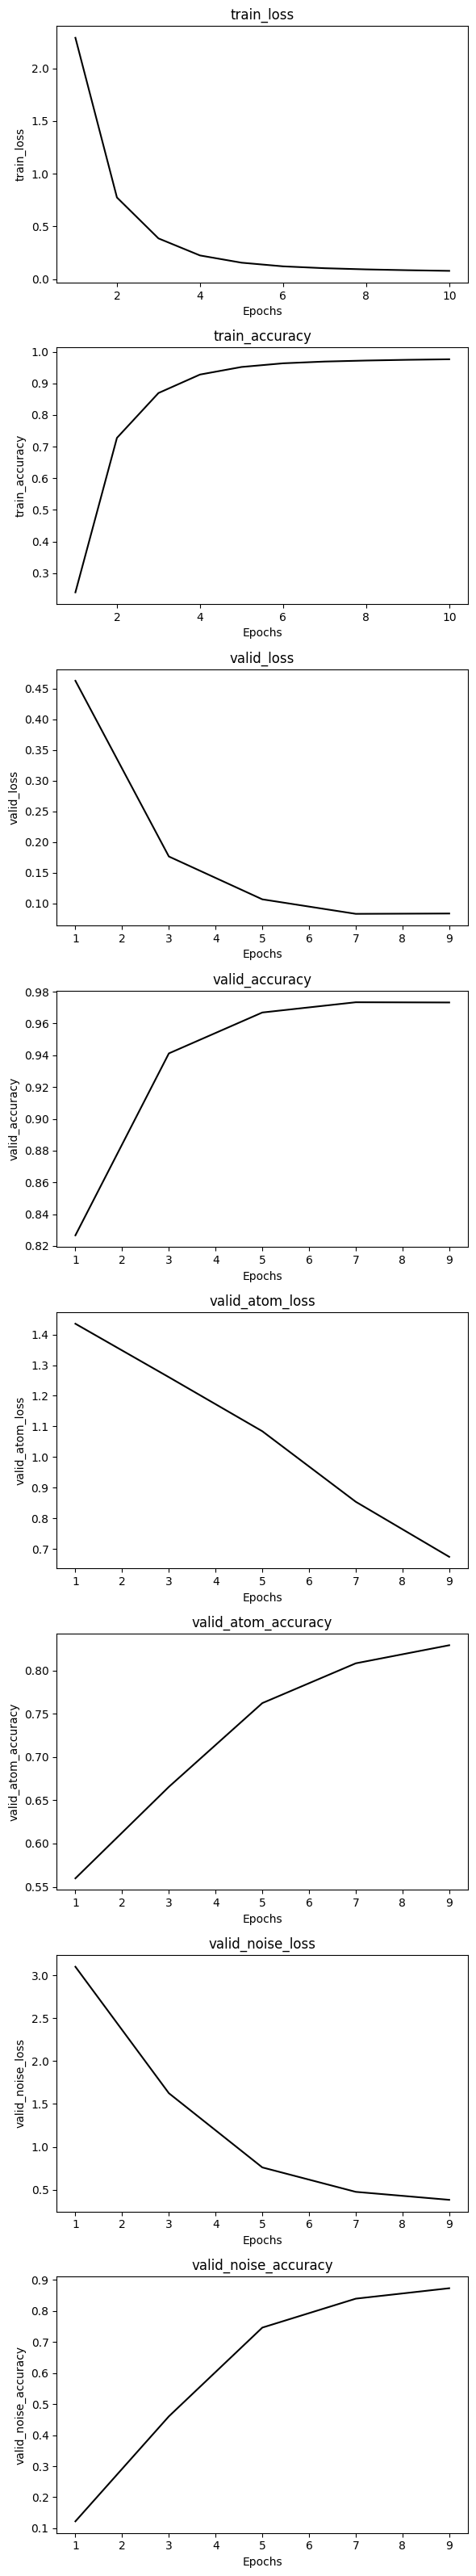

In [ ]:
wandb.finish()
trainer.plot_training_metrics()

### full size dataset - 10 million

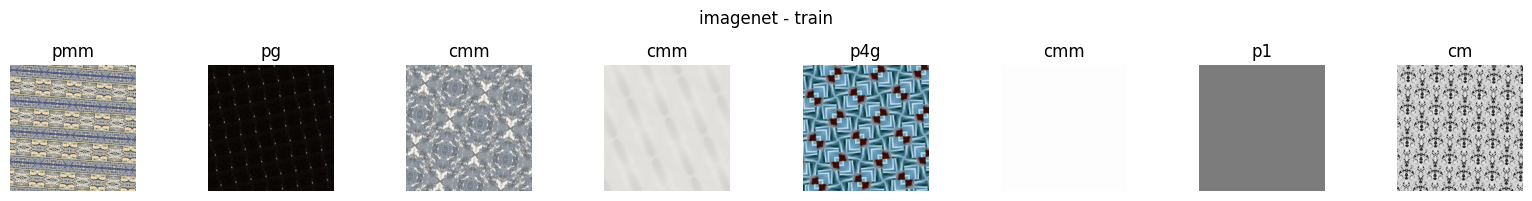

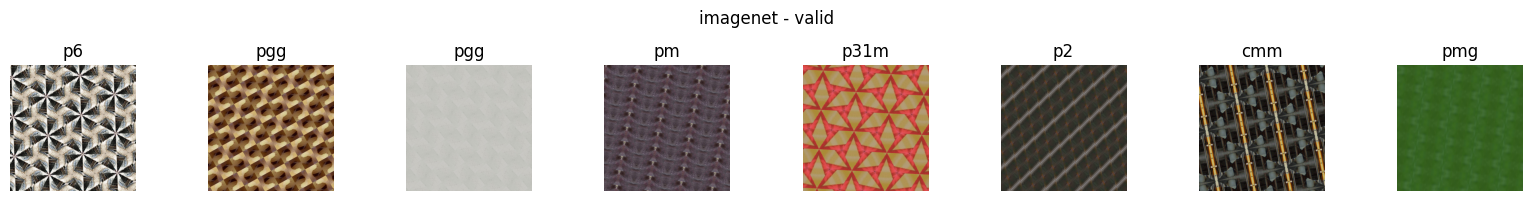

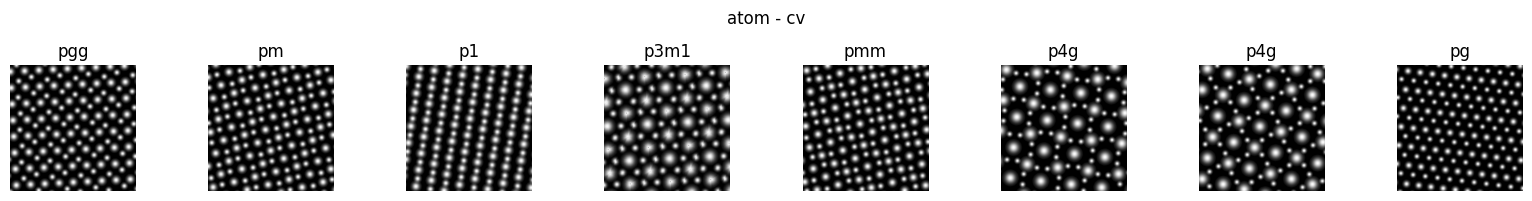

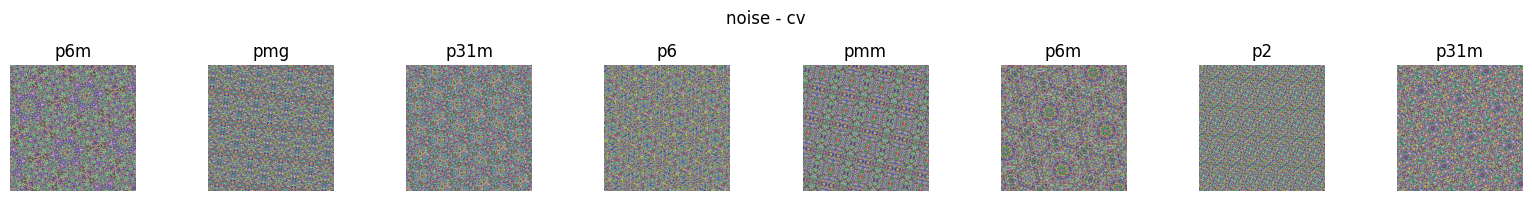

In [ ]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
imagenet_ds = hdf5_dataset('/mnt/d/datasets/symmetry_dataset/imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=300, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

# # atom
atom_ds = hdf5_dataset('/mnt/d/datasets/symmetry_dataset/atom_v5_rot_200k.h5', folder='test', transform=transforms.ToTensor())
atom_dl = DataLoader(atom_ds, batch_size=300, shuffle=False, num_workers=4)
viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

# # noise
noise_ds = hdf5_dataset('/mnt/d/datasets/symmetry_dataset/imagenet_atom_noise_v4_rot_10m_100k_subset.h5', folder='noise', transform=transforms.ToTensor())
noise_dl = DataLoader(noise_ds, batch_size=300, shuffle=False, num_workers=4)
viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')

In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)
model = torch.nn.DataParallel(model, device_ids=[7,9])
device = torch.device('cuda:7')
# model

torch.Size([2, 17])


In [ ]:
config = {
    'dataset': '10 million datasets',
    'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
    'optimizer': 'Adam',
    'scheduler': 'OneCycleLR',
}

NAME = '05242024-benchmark-resnet50_from_scratch-v5_10m'

In [ ]:
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, save_code=True, config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yig319. Use `wandb login --relogin` to force relogin


In [ ]:
device = torch.device('cuda:0')
lr = 1e-3
start = 0
epochs = 20

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
history = train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl, cv_dl_list=[atom_dl, noise_dl], cv_name_list=['atom', 'noise'],
                       epochs=epochs, start=start, scheduler=scheduler, model_dir='../../../saved_models/', tracking=True)

Epoch: 1/20


  0%|          | 0/28561 [00:00<?, ?it/s]

  6%|▌         | 1748/28561 [2:31:50<38:49:08,  5.21s/it]


KeyboardInterrupt: 